In [1]:
%%capture stored_output

!pip install git+https://github.com/uncertainty-toolbox/uncertainty-toolbox
!pip install torch-lr-finder
!pip install -U "ray[tune]"

In [2]:
import copy
import datetime
import math
import os
import random
import shutil
import time
from collections import OrderedDict
from pprint import pprint
import json
# import multiprocessing
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import sklearn.preprocessing

import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as tnf

import uncertainty_toolbox as uct
from torch_lr_finder import LRFinder

from ray import tune
from ray.tune.schedulers import ASHAScheduler


## generate data

In [3]:
# %load_ext line_profiler

In [4]:
pltparams = {
    "legend.fontsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "large",
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "figure.titlesize": "large",
    "lines.linewidth": 2,
    "lines.markersize": 3,
    "savefig.dpi": 100,
}
plt.style.use('fivethirtyeight')
plt.rcParams.update(pltparams)

# sns.set(font_scale = 1.2)

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cpu')
# data_path = "/mnt/beegfs/projects/power-conv/data"
random_seed = 2022

# saved_model_dir = "/home/phan/Workspace/saved_model"
# result_dir = "/home/phan/Workspace/result"
# fig_dir = "../fig"

saved_model_dir = "./saved_model"
result_dir = "./result"
fig_dir = "./fig"

In [6]:
def set_all_random_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# random_seed=2022
# set_all_random_seeds(random_seed)

https://blog.tensorflow.org/2018/10/industrial-ai-bhges-physics-based.html

The phenomenon of fatigue crack propagation can be modeled with the Paris law. Paris law relates the rate of crack growth $\left(da/dN\right)$ to the stress intensity factor  $\left(\Delta K = \Delta\sigma\sqrt{\pi a}\right)$ through the equation below:

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$
\begin{align}
ln\ \frac {da}{dN} = ln\ C + m\ ln\ (\Delta\sigma\sqrt{\pi a}) = ln\ C + m\ (ln \Delta \sigma + 0.5 ln\ \pi + 0.5 ln\ a)
\end{align}

Where $a$ is the crack length, $N$ is the number of loading cycles, $\sigma$ is the stress, and $C, m$ are material properties.
Integrating the Paris law for a specific geometry and loading configuration, we arrive at the analytical formulation for the size of a crack as a function of the loading cycle as shown below:

$a(N) = \left[ N  C \left(1-\frac{m}{2}\right) \left(\Delta\sigma\sqrt{\pi}\right)^m + a_0^{1-\frac{m}{2}}\right]^\frac{2}{2-m}$

where $a_0$ is the initial crack length.
The parameters $C$ and $m$ need to be calibrated for each application with crack length $(a)$ vs loading cycles $(N)$ data

\begin{align}
\int_{N_0}^{N_f} dN = \int_{a_0}^{a_f} \frac {da} {C ( \sigma \sqrt{\pi a})^m} 
=> N |_{N_0}^{N_f} = \frac 1 {C (\sigma \sqrt \pi)^m} \int_{a_0}^{a_f} a^{-m/2} da 
=> N_f - N_0 = \frac 1 {C (\sigma \sqrt \pi)^m} \frac 1 {1 - m/2} a^{1-m/2} |_{a_0}^{a_f}
=> N_f - N_0 = \frac 1 {C (\sigma \sqrt \pi)^m} \frac 1 {1 - m/2} (a_f^{1 - m/2} - a_0^{1 - m/2})
\end{align}

In [7]:
def paris_law(a, C, m, dsigma):
    righthandside = C * dsigma**m * (np.pi * a) ** (m / 2)
    return righthandside

In [8]:
def cycle_to_crack(N, C, m, a0, dsigma):
    a_N = (N * C * (1 - m / 2) * (dsigma * np.pi**0.5) ** m + a0 ** (1 - m / 2)) ** (
        2 / (2 - m)
    )
    return a_N

Text(0, 0.5, 'crack length')

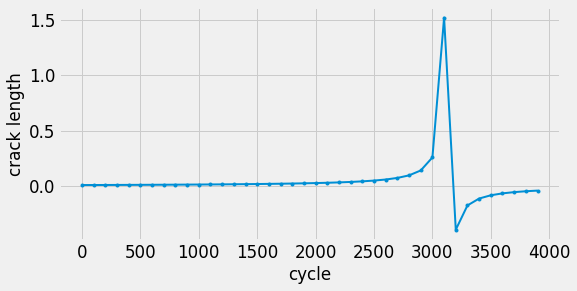

In [9]:
paris_C = np.exp(-23)
paris_m = 4.0
paris_dsigma = 75.0
paris_a0 = 0.01

N = np.arange(0.0, 4000.0, 100)
plt.figure(figsize=(8, 4))
plt.plot(N, cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma), marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

## preprocess

In [10]:
def generate_data(
    C,
    m,
    a0,
    dsigma,
    trainsize,
    startN=0.0,
    endN=1000.0,
    stepN=10,
    noise_strength=1e-2,
    random_seed=None,
):
    """
    Generate datapoints with Paris' law
    """
    N = np.arange(startN, endN, stepN)
    true_target = cycle_to_crack(N, C, m, a0, dsigma)
    if random_seed:
        np.random.seed(random_seed)

    noise = np.random.normal(0, 1, N.shape[0]) * noise_strength
    #     print(np.max(true_target) - np.min(true_target), np.mean(true_target), np.std(true_target))
    noisy_target = true_target + noise
    # noisy_target = noisy_target.clip(min=0)

    trainidx = int(N.shape[0] * trainsize)

    trainx = N[:trainidx]
    testx = N[trainidx:]
    trainy = noisy_target[:trainidx]
    testy = noisy_target[trainidx:]

    return trainx, trainy, testx, testy

In [11]:
def plot_target_prediction(
    traininput,
    traintarget,
    trainprediction,
    testinput,
    testtarget,
    testprediction=None,
    title=None,
    figsize=(8, 4),
    marker="o",
):

    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker)
    plt.plot(testinput, testtarget, label="test target", marker=marker)
    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)

    if testprediction is not None:
        plt.plot(testinput, testprediction, marker=marker, label="test prediction")
    # plt.ylim(-0.01, 0.02)

    if title:
        plt.title(title)

    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

## Data tensor

In [12]:
class TorchMinMaxScaler:
    def fit(self, data):
        self.min = torch.min(data)
        self.max = torch.max(data)
        return self

    def forward(self, data):
        scaled = (data - self.min) / (self.max - self.min)
        return scaled

    def inverse(self, data):
        rescaled = data * (self.max - self.min) + self.min
        return rescaled

In [13]:
def totensor(array):
    return torch.tensor(array).reshape(-1, 1).float()

def tensor_to_array(tensor):
    return tensor.detach().cpu().numpy().squeeze()

def array_to_tensor(array):
    return torch.tensor(array, device=device)


In [15]:
def sample_physics_points(xmin, xmax, xstep):
    return (
        torch.linspace(xmin, xmax, steps=xstep)
        .reshape(-1, 1)
        .requires_grad_(True)
        .to(DEVICE)
    )


def generate_data_tensor(noise_strength=1e-2):
    """
    Generate datapoints as torch tensor
    """
    paris_C = np.exp(-23)
    paris_m = 4.0
    paris_dsigma = 75.0
    paris_a0 = 0.01

    train_input, train_target, test_input, test_target = generate_data(
        paris_C,
        paris_m,
        paris_a0,
        paris_dsigma,
        trainsize=0.8,
        startN=0.0,
        endN=3000.0,
        stepN=20,
        noise_strength=noise_strength,
        random_seed=random_seed,
    )

    train_xscaler_torch = TorchMinMaxScaler().fit(totensor(train_input))
    train_yscaler_torch = TorchMinMaxScaler().fit(totensor(train_target))

    train_xtensor = train_xscaler_torch.forward(totensor(train_input)).to(DEVICE)
    train_ytensor = train_yscaler_torch.forward(totensor(train_target)).to(DEVICE)
    test_xtensor = train_xscaler_torch.forward(totensor(test_input)).to(DEVICE)
    test_ytensor = train_yscaler_torch.forward(totensor(test_target)).to(DEVICE)

    print(
        train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape
    )

    fig = plt.figure(figsize=(8, 4))
    plt.plot(train_xtensor, train_ytensor, marker="o", label="train")
    plt.plot(test_xtensor, test_ytensor, marker="o", label="test")
    plt.legend()
    plt.title("rescaled")

    return train_xtensor, train_ytensor, test_xtensor, test_ytensor, train_xscaler_torch, train_yscaler_torch, fig

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])
torch.Size([100, 1])


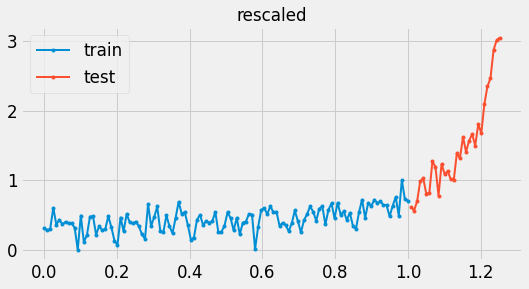

In [22]:
# generate data with noise strength 1e-2
train_xtensor, train_ytensor, test_xtensor, test_ytensor, train_xscaler_torch1, train_yscaler_torch1, fig = generate_data_tensor(noise_strength=1e-2)

min_xphysics = min(min(train_xtensor), min(test_xtensor)).detach().item()
max_xphysics = max(max(train_xtensor), max(test_xtensor)).detach().item()
# min_xphysics = min(test_xtensor).detach().item()
# max_xphysics = max(test_xtensor).detach().item()
physics_xtensor = sample_physics_points(min_xphysics, max_xphysics, xstep=100)
print(physics_xtensor.shape)

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


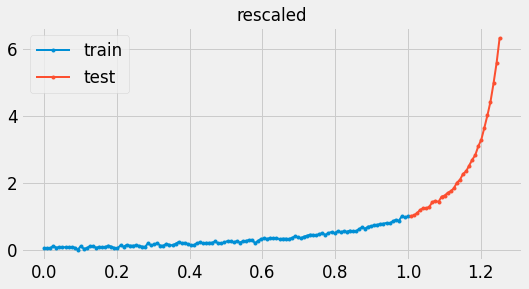

In [23]:
# the scaler must be generated with noise strength 1e-3, otherwise, ensemble mixture, 2 variants of MCDropout, bayes backprop will fail
# not yet understood why

train_xtensor1, train_ytensor1, test_xtensor1, test_ytensor1, train_xscaler_torch, train_yscaler_torch, fig = generate_data_tensor(noise_strength=1e-3)

In [24]:
# same input => same x scaler. Only yscaler changes

print(f'xscaler1 : {train_xscaler_torch1.min}, {train_xscaler_torch1.max}')
print(f'xscaler : {train_xscaler_torch.min}, {train_xscaler_torch.max}')

print(f'yscaler1 : {train_yscaler_torch1.min}, {train_yscaler_torch1.max}')
print(f'yscaler : {train_yscaler_torch.min}, {train_yscaler_torch.max}')

print(f'scaley / scalex = {(train_yscaler_torch.max - train_yscaler_torch.min)/(train_xscaler_torch.max - train_xscaler_torch.min)}')
print(f'1 scaley / scalex = {(train_yscaler_torch1.max - train_yscaler_torch1.min)/(train_xscaler_torch1.max - train_xscaler_torch1.min)}')

xscaler1 : 0.0, 2380.0
xscaler : 0.0, 2380.0
yscaler1 : -0.012300950475037098, 0.05808178707957268
yscaler : 0.008452539332211018, 0.041789863258600235


## regular neural network

In [25]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"

    def __init__(self, layer_size, activation=nn.Tanh, need_output_exp=False):
        super().__init__()
        layers = []
        self.need_output_exp = need_output_exp

        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i + 1]))
            layers.append(activation())

        self.layers = nn.Sequential(*layers, nn.Linear(layer_size[-2], layer_size[-1]))

    def forward(self, indata):
        outdata = self.layers(indata)
        if self.need_output_exp:
            return torch.exp(outdata)
        else:
            return outdata

model = FullyConnected([1, 16, 8, 1])
model(torch.rand(2, 1)).shape

torch.Size([2, 1])

In [26]:
def predict_model(model, inputdata, targetdata=None):
    model.eval()
    loss = None

    with torch.no_grad():
        outputdata = model(inputdata.to(DEVICE))
        #         predictions = outputdata
        if targetdata is not None:
            loss = tnf.mse_loss(outputdata, targetdata.to(DEVICE)).detach().item()

    return outputdata.detach().cpu(), loss

## Learning rate finder

https://github.com/davidtvs/pytorch-lr-finder

In [27]:
train_dataset = torch.utils.data.TensorDataset(train_xtensor, train_ytensor)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_xtensor), shuffle=False
)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-02


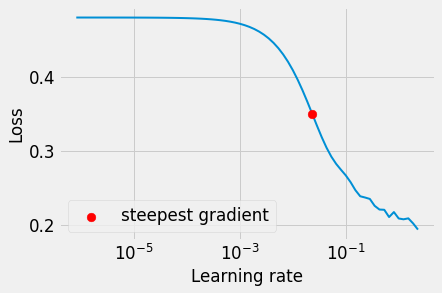

In [28]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-6)

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state

## data and physics loss

\begin{align}
\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m
\end{align}

Rescale derivative after normalization
\begin{align}
T_x(x) = \tilde x = \frac {x - min_x} {max_x - min_x} \\
T_y(y) = \tilde y = \frac {y - min_y} {max_y - min_y} \\
\hat y = model(\tilde x) \\
\\
paris(T_y^{-1}(\hat y)) = \frac d {dx} T_y^{-1} (\hat y) \\
\\
paris(T_y^{-1}(\hat y)) = paris(\hat y(max_y - min_y) + min_y) \\
\\
\frac d {dx} T_y^{-1} (\hat y) = \frac d {d \tilde x} (T_Y^{-1}(\hat y) ) \frac {d \tilde x} {dx} \\
= \frac d {d \tilde x} (model(\tilde x) (max_y - min_y) + min_y) . \frac d {dx} (\frac {x - min_x} {max_x - min_x}) \\
= (max_y - min_y) . \frac {d\ model(\tilde x)} {d \tilde x} . \frac 1 {max_x - min_x}
\end{align}

<!-- paris(\hat y(max_y - min_y) + min_y) = \frac d {dx} (\hat y(max_y - min_y) + min_y) \\ -->


In [29]:
def compute_data_physics_loss(
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    input_data,
    target_data,
    input_physics,
    input_scaler,
    output_scaler,
    physics_coeff=1,
    data_coeff=1,
):
    """
    Base computation of observation data and physics MSE
    """
    data_prediction = model(input_data)
    data_loss = tnf.mse_loss(data_prediction, target_data)

    input_physics.requires_grad_(True)
    prediction_physics = model(input_physics)
    #     physics_diff = torch.diff(prediction_physics, dim=0)

    derivative = torch.autograd.grad(
        outputs=prediction_physics,
        inputs=input_physics,
        grad_outputs=torch.ones_like(input_physics),
        retain_graph=True,
        create_graph=True,
    )[0]
    # detach ?
    rescaled_derivative = (
        derivative
        * (output_scaler.max - output_scaler.min)
        / (input_scaler.max - input_scaler.min)
    )

    physics_constraint = 1 * paris_law(
        output_scaler.inverse(prediction_physics), paris_C, paris_m, paris_dsigma
    )
    physics_loss = (rescaled_derivative - physics_constraint) ** 2

    result = dict(
        data_loss = data_loss,
        physics_loss = torch.mean(physics_loss),
        rescaled_derivative = rescaled_derivative,
        physics_constraint = physics_constraint,
        backward_loss = torch.mean(data_coeff * data_loss + physics_coeff * physics_loss),
    )
    
    return result

## generic train function

In [30]:
def train(train_args, result_args):
    """
    Generic train function
    """
    
    model = train_args['loss_func_args']['model']
    
    # default optimizer if not provided
    optim = train_args.get('optim', torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8))

    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)
    
    # call initializa result function
    all_result = result_args['initialize_result_func']()
    model.train()

    for epoch in range(train_args['epochs']):
        # call function to compute loss with arguments
        epoch_result = train_args['loss_func'](**train_args['loss_func_args'])
        
        # backward pass
        optim.zero_grad()
        epoch_result['backward_loss'].backward()
        optim.step()
        #         scheduler.step(loss)
        
        # call update result function
        all_result = result_args['update_result_func'](all_result, epoch_result)
        
        # call log result function
        if train_args['verbose'] and (train_args['epochs'] < 10 or epoch % (train_args['epochs'] // 10) == 0):
            result_args['log_result_func'](epoch, all_result, epoch_result)
            
    return all_result

In [31]:
def pinn_update_result(result, epoch_result):
    result['data_loss'].append(epoch_result['data_loss'].detach().item())
    result['physics_loss'].append(epoch_result['physics_loss'].detach().item())
    return result

def pinn_log_result(epoch, result, epoch_result):
    print(f"\n Epoch {epoch+1} loss = {epoch_result['backward_loss'].detach().item()}")
    print(f"data loss = {epoch_result['data_loss']} ; physics loss = {epoch_result['physics_loss']}")
    

pinn_result_args = dict(
    initialize_result_func = lambda :dict(data_loss=[], physics_loss=[]),
    update_result_func = pinn_update_result,
    log_result_func = pinn_log_result,
)

In [32]:
#
base_loss_func_args = dict(
    paris_C = paris_C,
    paris_m = paris_m,
    paris_dsigma = paris_dsigma,
    input_data = train_xtensor,
    target_data = train_ytensor,
    input_physics = physics_xtensor,
    input_scaler = train_xscaler_torch,
    output_scaler = train_yscaler_torch,
)

## Only data or physics loss


 Epoch 1 loss = 0.2875828444957733
data loss = 0.2875828146934509 ; physics loss = 1.7341097308110065e-11

 Epoch 101 loss = 0.023380933329463005
data loss = 0.023380933329463005 ; physics loss = 2.680101696128645e-10

 Epoch 201 loss = 0.020527949556708336
data loss = 0.020527951419353485 ; physics loss = 2.6163757271824295e-10

 Epoch 301 loss = 0.020385989919304848
data loss = 0.0203859880566597 ; physics loss = 2.617857597364548e-10

 Epoch 401 loss = 0.020248888060450554
data loss = 0.020248884335160255 ; physics loss = 2.6177343626088145e-10

 Epoch 501 loss = 0.020118724554777145
data loss = 0.020118724554777145 ; physics loss = 2.6181426471261204e-10

 Epoch 601 loss = 0.019985737279057503
data loss = 0.0199857410043478 ; physics loss = 2.619451044960641e-10

 Epoch 701 loss = 0.019825298339128494
data loss = 0.019825298339128494 ; physics loss = 2.622437822452639e-10

 Epoch 801 loss = 0.019587067887187004
data loss = 0.019587066024541855 ; physics loss = 2.629662043673875e-1

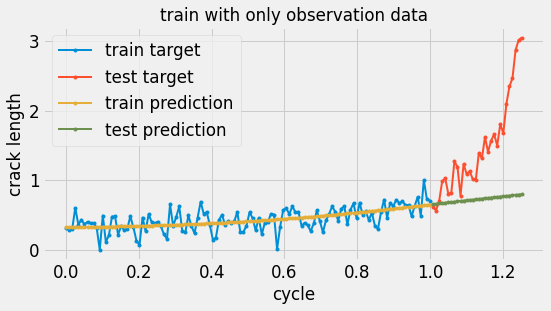

In [33]:
pinn_model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)

pinn_train_args = dict(
    loss_func = compute_data_physics_loss,
    loss_func_args = dict(
        **base_loss_func_args,
        model = pinn_model,
        physics_coeff = 0,
        data_coeff = 1,
    ),
    epochs = 1000,
    verbose=True,
)

pinn_result = train(pinn_train_args, pinn_result_args)

train_predictions, _ = predict_model(pinn_model, train_xtensor)
test_predictions, test_loss = predict_model(pinn_model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    title='train with only observation data'
)
# fig.savefig(os.path.join(fig_dir, "only-data.pdf"), bbox_inches="tight")


 Epoch 1 loss = 2.3417606395681467e-11
data loss = 0.12985672056674957 ; physics loss = 2.3417606395681467e-11

 Epoch 101 loss = 4.248876424306491e-12
data loss = 0.22811076045036316 ; physics loss = 4.248876424306491e-12

 Epoch 201 loss = 4.1732494196478065e-12
data loss = 0.2306680530309677 ; physics loss = 4.1732494196478065e-12

 Epoch 301 loss = 4.47504013012523e-12
data loss = 0.22704628109931946 ; physics loss = 4.47504013012523e-12

 Epoch 401 loss = 4.593283652737368e-12
data loss = 0.22563762962818146 ; physics loss = 4.593283652737368e-12

 Epoch 501 loss = 4.629657768262518e-12
data loss = 0.22520847618579865 ; physics loss = 4.629657768262518e-12

 Epoch 601 loss = 4.640316342979789e-12
data loss = 0.2250831574201584 ; physics loss = 4.640316342979789e-12

 Epoch 701 loss = 4.643424967448739e-12
data loss = 0.22504664957523346 ; physics loss = 4.643424967448739e-12

 Epoch 801 loss = 4.644336130954496e-12
data loss = 0.22503595054149628 ; physics loss = 4.64433613095449

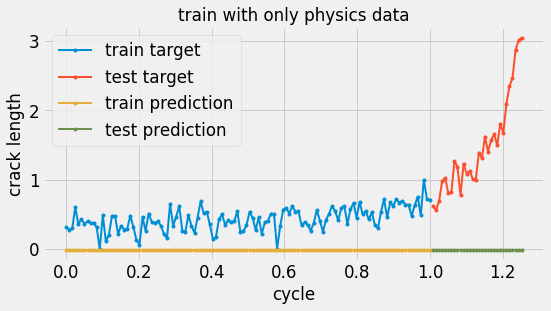

In [34]:
pinn_model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)

pinn_train_args = dict(
    loss_func = compute_data_physics_loss,
    loss_func_args = dict(
        **base_loss_func_args,
        model = pinn_model,
        physics_coeff = 1,
        data_coeff = 0,
    ),
    epochs = 1000,
    verbose=True,
)

pinn_result = train(pinn_train_args, pinn_result_args)

train_predictions, _ = predict_model(pinn_model, train_xtensor)
test_predictions, test_loss = predict_model(pinn_model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    title='train with only physics data'
)
# fig.savefig(os.path.join(fig_dir, "only-physics.pdf"), bbox_inches="tight")

## static scalarization


 Epoch 1 loss = 0.08569254726171494
data loss = 0.08569254726171494 ; physics loss = 9.141356005493151e-10

 Epoch 1001 loss = 0.01814904622733593
data loss = 0.01814904436469078 ; physics loss = 3.079910770864558e-10

 Epoch 2001 loss = 0.018120499327778816
data loss = 0.018120499327778816 ; physics loss = 3.4546751570552203e-10

 Epoch 3001 loss = 0.01811417005956173
data loss = 0.01811417005956173 ; physics loss = 3.8197975338327694e-10

 Epoch 4001 loss = 0.018112750723958015
data loss = 0.018112750723958015 ; physics loss = 4.111967710773712e-10

 Epoch 5001 loss = 0.018112333491444588
data loss = 0.018112333491444588 ; physics loss = 4.2051298554390826e-10

 Epoch 6001 loss = 0.01813068985939026
data loss = 0.01813068985939026 ; physics loss = 4.366116634901829e-10

 Epoch 7001 loss = 0.01811172626912594
data loss = 0.018111728131771088 ; physics loss = 4.20159101954809e-10

 Epoch 8001 loss = 0.01811140961945057
data loss = 0.018111413344740868 ; physics loss = 4.11748690698487

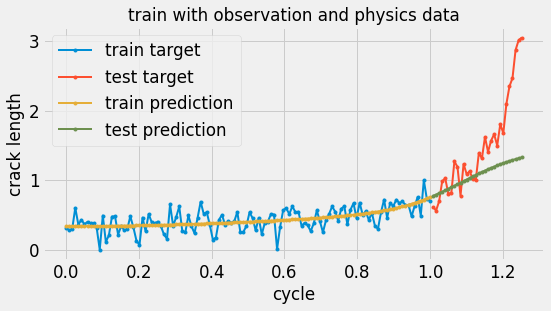

In [35]:
pinn_model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)

pinn_train_args = dict(
    loss_func = compute_data_physics_loss,
    loss_func_args = dict(
        **base_loss_func_args,
        model = pinn_model,
        physics_coeff = 1e-6,
        data_coeff = 1,
    ),
    epochs = 10000,
    verbose=True,
)

pinn_result = train(pinn_train_args, pinn_result_args)

train_predictions, _ = predict_model(pinn_model, train_xtensor)
test_predictions, test_loss = predict_model(pinn_model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    title='train with observation and physics data'
)
# fig.savefig(os.path.join(fig_dir, "only-physics.pdf"), bbox_inches="tight")

## gradient magnitude normalization

Physics law:
\begin{align} 
    f_\nabla(y) = f \left(\nabla_x y, \nabla_x^2 y , ... , \nabla_x^d y  \right)  = \Phi(y)
\end{align}

Model prediction:
\begin{align}
    \hat y = \hat h(x; w)
\end{align}

Data and physics loss scalarization
\begin{align}
    L_{obs} = \sum_{i=1}^{n\_obs} || \hat y_i - y_i ||^2 \\
    L_{phy} = \sum_{i=1}^{n\_phy} || f_\nabla(\hat y_i) - \Phi(\hat y_i) ||^2 \\
    L = \lambda_{obs} L_{obs} + \lambda_{phy} L_{phy}
\end{align}


Gradient magnitude scalarization according to "Optimally weighted loss functions for solving PDEs with Neural Networks"
(https://arxiv.org/pdf/2002.06269.pdf)

\begin{align}
L = \frac {L_{obs}} {\sum_{i=1}^{n\_obs} y_i^2} + \frac {L_{phy}} {\sum_{i=1}^{n\_phy} (|f_\nabla(\hat y_i)| + |\Phi(\hat y_i)|)^2}
= \frac {\sum_{i=1}^{n\_obs} (\hat y_i - y_i)^2} {\sum_{i=1}^{n\_obs} y_i^2}
+ \frac {\sum_{j=1}^{n\_phy} (f_\nabla(\hat y_i) - \Phi(\hat y_i))^2} {\sum_{i=1}^{n\_phy} (|f_\nabla(\hat y_i)| + |\Phi(\hat y_i)|)^2}
\end{align}

In [36]:
def compute_data_physics_loss_gradmagnorm(**base_loss_func_args):
    loss_result = compute_data_physics_loss(**base_loss_func_args)
    
    # detach ???
    differential_norm = torch.abs(loss_result['rescaled_derivative']) + torch.abs(loss_result['physics_constraint'])
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(base_loss_func_args['target_data']**2)
    
    loss_result['data_norm'] = data_norm
    loss_result['differential_norm'] = differential_norm
    loss_result['backward_loss'] = loss_result['data_loss'] / data_norm + loss_result['physics_loss'] / differential_norm
    
    return loss_result


In [37]:
def initialize_result(metric_name, separator):
    result = {metric:[] for metric in metric_name.split(separator)}
    return result

def gradmagnorm_update_result(result, epoch_result):
    result['data_loss'].append(epoch_result['data_loss'].detach().item())
    result['physics_loss'].append(epoch_result['physics_loss'].detach().item())
    result['data_norm'].append(epoch_result['data_norm'].detach().item())
    result['differential_norm'].append(epoch_result['differential_norm'].detach().item())
    return result

def gradmagnorm_log_result(epoch, result, epoch_result):
    print(f"\n Epoch {epoch+1} loss = {epoch_result['backward_loss'].detach().item()}")
    print(f"data loss = {epoch_result['data_loss']} ; physics loss = {epoch_result['physics_loss']}")
    print(f"data norm = {epoch_result['data_norm']} ; physics norm = {epoch_result['differential_norm']}")
    print(f"normalized data loss = {epoch_result['data_loss']/epoch_result['data_norm']} ; normalized physics loss = {epoch_result['physics_loss']/epoch_result['differential_norm']}")

    
gradmagnorm_initialize_result = partial(
    initialize_result, 
    metric_name="data_loss physics_loss data_norm differential_norm",
    separator=' ',
)
gradmagnorm_result_args = dict(
    initialize_result_func = gradmagnorm_initialize_result,
    update_result_func = gradmagnorm_update_result,
    log_result_func = gradmagnorm_log_result,
)


 Epoch 1 loss = 0.028246544301509857
data loss = 0.47819212079048157 ; physics loss = 3.1594902475534647e-12
data norm = 26.207273483276367 ; physics norm = 3.1594901694909083e-10
normalized data loss = 0.018246542662382126 ; normalized physics loss = 0.010000000707805157

 Epoch 2001 loss = 0.0007636958616785705
data loss = 0.018266653642058372 ; physics loss = 1.0721579873917975e-10
data norm = 26.207273483276367 ; physics norm = 1.6077021882665576e-06
normalized data loss = 0.0006970069953240454 ; normalized physics loss = 6.668884452665225e-05

 Epoch 4001 loss = 0.0007257185061462224
data loss = 0.01823045127093792 ; physics loss = 1.1588279641427945e-10
data norm = 26.207273483276367 ; physics norm = 3.850833309115842e-06
normalized data loss = 0.000695625611115247 ; normalized physics loss = 3.009291503985878e-05

 Epoch 6001 loss = 0.0007183525594882667
data loss = 0.01821761764585972 ; physics loss = 1.423784423693064e-10
data norm = 26.207273483276367 ; physics norm = 6.1325

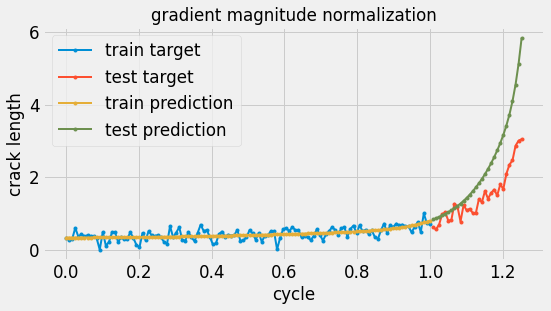

In [38]:
%%time

gradmagnorm_model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)

gradmagnorm_train_args = dict(
    loss_func = compute_data_physics_loss_gradmagnorm,
    loss_func_args = dict(
        **base_loss_func_args,
        model = gradmagnorm_model,
    ),
    epochs = 20000,
    verbose=True,
)

gradmagnorm_result = train(gradmagnorm_train_args, gradmagnorm_result_args)

train_predictions, _ = predict_model(gradmagnorm_model, train_xtensor)
test_predictions, test_loss = predict_model(gradmagnorm_model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    title='gradient magnitude normalization'
)
# fig.savefig(os.path.join(fig_dir, "only-physics.pdf"), bbox_inches="tight")

## ray tune gradient magnitude norm

In [39]:
def raytune_train_gradmagnorm(config, checkpoint_dir=None):
    gradmagnorm_model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)

    gradmagnorm_train_args = dict(
        loss_func = compute_data_physics_loss_gradmagnorm,
        loss_func_args = dict(
            **base_loss_func_args,
            model = gradmagnorm_model,
        ),
        epochs = 20000,
        verbose = False,
        optim = torch.optim.Adam(gradmagnorm_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    )

    gradmagnorm_result = train(gradmagnorm_train_args, gradmagnorm_result_args)

    train_predictions, _ = predict_model(gradmagnorm_model, train_xtensor)
    test_predictions, test_loss = predict_model(gradmagnorm_model, test_xtensor, test_ytensor)

    # print(f"{test_loss = }")
    # tune.report(test_loss=test_loss)
    return dict(test_loss=test_loss)
    
search_space = {
    'lr': tune.loguniform(1e-3, 1e-1),
    'weight_decay': tune.loguniform(1e-9, 1e-5),
}

# analysis = tune.run(
#     raytune_train_gradmagnorm, config=search_space, 
#     scheduler=ASHAScheduler(metric="test_loss", mode="min"),
#     # metric='test_loss', mode='min',
#     verbose=1, num_samples=10,
#     # resources_per_trial={'gpu': 1},
#     local_dir=f"./raytune",
# )

In [40]:
# print("Best config: ", analysis.get_best_config(metric="test_loss", mode="min"))

# analysis.dataframe(metric='test_loss', mode='min')
# analysis.results_df

## Uncertainty calibration metric

https://uncertainty-toolbox.github.io/tutorial/

Miscalibration area: for a varying confidence level from 0 to 1, what proportion of true value lies within the prediction interval

Sharpness: average width of prediction interval

## Deep ensemble basic

In [62]:
def plot_target_prediction_ensemble(
    traininput,
    traintarget,
    testinput,
    testtarget,
    ensemble,
    title=None,
    figsize=(8, 4),
    marker='o',
    markersize=3,
):

    fig = plt.figure(figsize=figsize)
    plt.plot(
        traininput, traintarget, label="train target", marker=marker, linestyle="-", markersize=markersize
    )
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-", markersize=markersize,)

    for index, model in enumerate(ensemble):
        trainprediction, _ = predict_model(model, traininput, traintarget)
        testprediction, testloss = predict_model(model, testinput, testtarget)
        # print(trainprediction.shape, testprediction.shape)
        # label=f"train prediction {index}"
        plt.plot(
            traininput,
            trainprediction,
            marker=marker,
            alpha=0.6,
            linestyle="--",
            linewidth=3,
        )
        plt.plot(
            testinput,
            testprediction,
            marker=marker,
            alpha=0.6,
            linestyle="--",
            linewidth=3,
        )
    # plt.ylim(-0.01, 0.02)

    if title:
        plt.title(title)

    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

CPU times: user 1min 43s, sys: 211 ms, total: 1min 43s
Wall time: 1min 44s


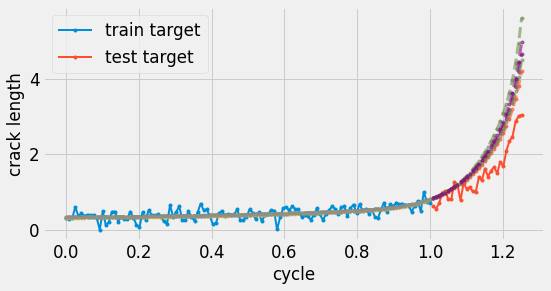

In [63]:
%%time

ensemble_size = 5
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    gradmagnorm_model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(DEVICE)

    gradmagnorm_train_args = dict(
        loss_func = compute_data_physics_loss_gradmagnorm,
        loss_func_args = dict(
            **base_loss_func_args,
            model = gradmagnorm_model,
        ),
        epochs = 10000,
        verbose = False,
    )

    gradmagnorm_result = train(gradmagnorm_train_args, gradmagnorm_result_args)

    ensemble_model.append(gradmagnorm_model)
    ensemble_metric.append(gradmagnorm_result)

fig = plot_target_prediction_ensemble(
    train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model
)

## Deep Ensemble Gaussian Mixture

https://arxiv.org/pdf/1612.01474.pdf

https://github.com/mpritzkoleit/deep-ensembles/blob/master/Deep%20Ensembles.ipynb

Each model in the ensemble receives the input, then produces a predictive mean $\mu(x)$ and variance $\sigma^2(x)$

\begin{align}
-ln\ p(y|x) = -ln\ \mathcal N (y; \mu(x), \sigma^2(x)) = \frac 1 2 ln\ 2 \pi + ln\ \sigma(x) + \frac {(y-\mu(x))^2} {2 \sigma^2(x)}
\end{align}

The prediction of the ensemble is a Gaussian mixture with uniform contribution

\begin{align}
\mu(x) = \frac 1 M \sum_{i=1}^M \mu_i(x) \\
\sigma^2(x) = \frac 1 M \sum_{i=1}^M [\sigma^2_i(x) + \mu_i^2(x)] - \mu^2(x)
\end{align}

In [64]:
def create_mlp(layersize, activation):
    layers = []
    for i in range(len(layersize) - 2):
        layers.append(nn.Linear(layersize[i], layersize[i + 1]))
        layers.append(activation())

    mlp = nn.Sequential(*layers, nn.Linear(layersize[-2], layersize[-1]))

    return mlp


class GaussianFullyConnected(nn.Module):
    """
    Defines a fully connected neural network with mean and variance of a Gaussian as output
    """

    def __init__(
        self,
        body_size,
        mean_head_size,
        logvar_head_size,
        activation=nn.ReLU,
        need_mean_exp=False,
    ):
        super().__init__()
        self.need_mean_exp = need_mean_exp
        self.body = create_mlp(body_size, activation)
        self.mean_head = create_mlp(mean_head_size, activation)
        self.logvar_head = create_mlp(logvar_head_size, activation)

    def forward(self, indata):
        outdata = self.body(indata)
        mean, logvar = self.mean_head(outdata), self.logvar_head(outdata)

        # var = tnf.softplus(logvar) + 1e-6
        # var = torch.exp(logvar)

        if self.need_mean_exp:
            mean = torch.exp(mean)

        return mean, logvar


model = GaussianFullyConnected(
    body_size=[1, 4, 4], mean_head_size=[4, 1], logvar_head_size=[4, 1]
)
test_input_size = (4, 1)
mean, logvar = model(torch.rand(test_input_size))
assert mean.shape == test_input_size
assert logvar.shape == test_input_size

In [65]:
# https://github.com/mpritzkoleit/deep-ensembles/blob/master/Deep%20Ensembles.ipynb
def gaussian_mixture_ensemble_forward(ensemble_models, inputtensor):
    means = []
    logvariances = []
    for index, model in enumerate(ensemble_models):
        mean, logvariance = model(inputtensor)
        means.append(mean)
        logvariances.append(logvariance)

    means = torch.stack(means)
    logvariances = torch.stack(logvariances)
    mixture_mean = means.mean(0)
    mixture_var = (torch.exp(logvariances) + means**2).mean(0) - mixture_mean**2

    return mixture_mean, mixture_var


def negative_gaussian_loglikelihood(mean, logvariance, target, mse_coeff=1):
    return torch.mean(
        logvariance / 2 + mse_coeff * (target - mean) ** 2 / torch.exp(logvariance)
    )

In [89]:
def compute_data_physics_loss_gaussian_mixture_ensemble(
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    input_data,
    target_data,
    input_physics,
    input_scaler,
    output_scaler,
):

    input_physics.requires_grad_(True)
    data_mean, data_logvar = model(input_data)
    physics_mean, physics_logvar = model(input_physics)
    physics_constraint = paris_law(
        output_scaler.inverse(physics_mean), paris_C, paris_m, paris_dsigma
    )

    derivative = torch.autograd.grad(
        outputs=physics_mean,
        inputs=input_physics,
        grad_outputs=torch.ones_like(input_physics),
        retain_graph=True,
        create_graph=True,
    )[0]
    rescaled_derivative = (
        derivative
        * (output_scaler.max - output_scaler.min)
        / (input_scaler.max - input_scaler.min)
    )

    differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(target_data**2)

    data_loss = negative_gaussian_loglikelihood(
        data_mean, data_logvar, target_data,
        1 / data_norm
    )
    physics_loss = negative_gaussian_loglikelihood(
        rescaled_derivative, physics_logvar, physics_constraint, 
        1 / differential_norm
    )

    result = dict(
        data_loss = data_loss, 
        data_norm = data_norm, 
        physics_loss = physics_loss, 
        differential_norm = differential_norm,
        backward_loss = data_loss + physics_loss,
        # backward_loss = data_loss - torch.log(data_norm) + physics_loss - torch.log(differential_norm)
    ) 

    return result

In [90]:
def ensemble_mixture_log_result(epoch, result, epoch_result):
    gradmagnorm_log_result(epoch, result, epoch_result)
    print(f"log data norm = {torch.log(epoch_result['data_norm'])}; log differential norm = {torch.log(epoch_result['differential_norm'])}")

ensemble_mixture_result_args = {
    **gradmagnorm_result_args,
    'log_result_func': ensemble_mixture_log_result,
}

In [108]:
%%time

ensemble_size = 2
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    gaussian_model = GaussianFullyConnected(
        body_size=[1, 4, 4],
        mean_head_size=[4, 1],
        logvar_head_size=[4, 1],
        activation=nn.Tanh,
        need_mean_exp=False,
    ).to(DEVICE)

    ensemble_train_args = dict(
        loss_func = compute_data_physics_loss_gaussian_mixture_ensemble,
        loss_func_args = dict(
            **base_loss_func_args,
            model = gaussian_model,
        ),
        epochs = 10000,
        verbose = True,
    )

    ensemble_result = train(ensemble_train_args, ensemble_mixture_result_args)

    ensemble_model.append(gaussian_model)
    ensemble_metric.append(ensemble_result)

# fig = plot_target_prediction_ensemble(train_xtensor, train_ytensor,
#     test_xtensor, test_ytensor, ensemble_model)


 Epoch 1 loss = 0.09637649357318878
data loss = 0.04241380840539932 ; physics loss = 0.05396268889307976
data norm = 26.207273483276367 ; physics norm = 1.9274093432386508e-08
normalized data loss = 0.0016183983534574509 ; normalized physics loss = 2799752.5
log data norm = 3.2660369873046875; log differential norm = -17.764503479003906

 Epoch 1001 loss = -5.9927825927734375
data loss = -2.7018096446990967 ; physics loss = -3.29097318649292
data norm = 26.207273483276367 ; physics norm = 1.1080041986133438e-06
normalized data loss = -0.10309388488531113 ; normalized physics loss = -2970181.25
log data norm = 3.2660369873046875; log differential norm = -13.712949752807617

 Epoch 2001 loss = -6.112649917602539
data loss = -2.6947317123413086 ; physics loss = -3.4179184436798096
data norm = 26.207273483276367 ; physics norm = 1.5718810573162045e-06
normalized data loss = -0.10282380878925323 ; normalized physics loss = -2174413.0
log data norm = 3.2660369873046875; log differential nor

In [109]:
def predict_gaussian_ensemble_model(model, inputtensor):
    with torch.no_grad():
        mean, logvar = model(inputtensor)
    return mean.detach().cpu().numpy(), logvar.exp().detach().cpu().numpy()


def plot_target_prediction_ensemble_gaussian(
    traininput,
    traintarget,
    testinput,
    testtarget,
    ensemble,
    title=None,
    figsize=(8, 4),
    marker='o',
    markersize=3,
):

    fig = plt.figure(figsize=figsize)
    plt.plot(
        traininput, traintarget, label="train target", marker=marker, linestyle="-", markersize=markersize
    )
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-", markersize=markersize)

    for index, model in enumerate(ensemble):
        train_mean, train_var = predict_gaussian_ensemble_model(model, traininput)
        test_mean, test_var = predict_gaussian_ensemble_model(model, testinput)

        plt.plot(
            traininput,
            train_mean,
            alpha=0.6,
            linestyle="--",
            linewidth=3,
        )
        plt.plot(
            testinput, test_mean, alpha=0.6, linestyle="--", linewidth=3
        )
        plt.fill_between(
            traininput.squeeze(),
            (train_mean - 2 * np.sqrt(train_var)).squeeze(),
            (train_mean + 2 * np.sqrt(train_var)).squeeze(),
            # color="gray",
            alpha=0.3,
            # label="train CI 0.95",
        )
        plt.fill_between(
            testinput.squeeze(),
            (test_mean - 2 * np.sqrt(test_var)).squeeze(),
            (test_mean + 2 * np.sqrt(test_var)).squeeze(),
            # color="gray",
            alpha=0.3,
            # label="test CI 0.95",
        )

    if title:
        plt.title(title)
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

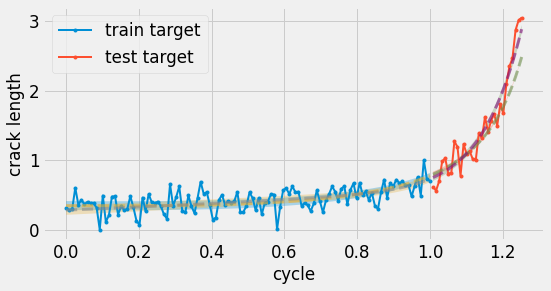

In [110]:
fig = plot_target_prediction_ensemble_gaussian(
    train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model
)

In [111]:
def plot_target_prediction_ensemble_gaussian_mixture(
    traininput,
    traintarget,
    testinput,
    testtarget,
    ensemble,
    title=None,
    figsize=(8, 4),
    marker='o',
    markersize=3,
):

    fig = plt.figure(figsize=figsize)
    plt.plot(
        traininput, traintarget, label="train target", marker=marker, linestyle="-", markersize=markersize, alpha=0.6
    )
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-", markersize=markersize, alpha=0.6)

    train_mean, train_var = gaussian_mixture_ensemble_forward(ensemble, traininput)
    test_mean, test_var = gaussian_mixture_ensemble_forward(ensemble, testinput)
    train_mean, train_var = train_mean.detach().numpy(), train_var.detach().numpy()
    test_mean, test_var = test_mean.detach().numpy(), test_var.detach().numpy()

    plt.plot(
        traininput, train_mean, marker=None, alpha=0.6, linestyle="--", linewidth=3, label="train prediction mean",

    )
    plt.plot(
        testinput, test_mean, marker=None, alpha=0.6, linestyle="--", linewidth=3, label="test prediction mean",

    )
    plt.fill_between(
        traininput.squeeze(),
        (train_mean - 2 * np.sqrt(train_var)).squeeze(),
        (train_mean + 2 * np.sqrt(train_var)).squeeze(),
        # color="gray",
        alpha=0.3,
        label="train CI 0.95",        
    )
    plt.fill_between(
        testinput.squeeze(),
        (test_mean - 2 * np.sqrt(test_var)).squeeze(),
        (test_mean + 2 * np.sqrt(test_var)).squeeze(),
        # color="gray",
        alpha=0.3,
        label="test CI 0.95",
    )

    if title:
        plt.title(title)
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

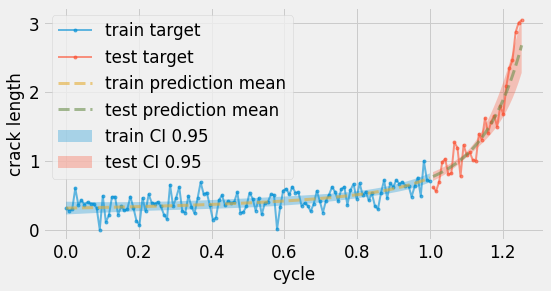

In [112]:
fig = plot_target_prediction_ensemble_gaussian_mixture(
    train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.758
  RMSE          1.887
  MDAE          1.581
  MARPD         200.000
  R2            -6.620
  Correlation   -0.887
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.461
  Mean-absolute Calibration Error       0.408
  Miscalibration Area                   0.412
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.464
     Group Size: 0.56 -- Calibration Error: 0.435
     Group Size: 1.00 -- Calibration Error: 0.408
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.540
     Group Size: 0.56 -- Calibration Error: 0.488
     Group Size: 1.00 -- Calibration Error: 0.461
============

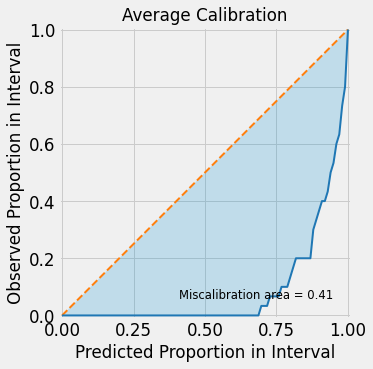

In [52]:
test_mean, test_var = predict_gaussian_ensemble_model(model, test_xtensor)
test_mean, test_std = test_mean.squeeze(), np.sqrt(test_var.squeeze())
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.709
  RMSE          0.730
  MDAE          0.702
  MARPD         200.000
  R2            -17.638
  Correlation   -0.551
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.202
  Mean-absolute Calibration Error       0.172
  Miscalibration Area                   0.174
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.207
     Group Size: 0.56 -- Calibration Error: 0.184
     Group Size: 1.00 -- Calibration Error: 0.172
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.248
     Group Size: 0.56 -- Calibration Error: 0.218
     Group Size: 1.00 -- Calibration Error: 0.202
===========

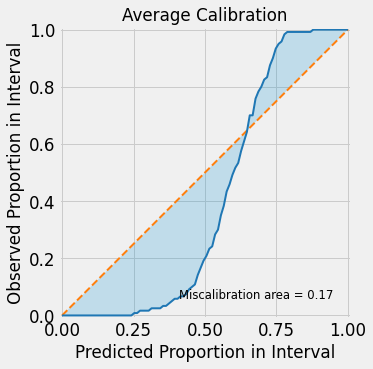

In [53]:
train_mean, train_var = predict_gaussian_ensemble_model(model, train_xtensor)
train_mean, train_std = train_mean.squeeze(), np.sqrt(train_var.squeeze())
uct.viz.plot_calibration(train_mean, train_std, train_ytensor.numpy().squeeze())
metrics = uct.metrics.get_all_metrics(
    train_mean, train_std, train_ytensor.numpy().squeeze()
)

In [54]:
%%time

ensemble_size = 10
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = GaussianFullyConnected(
        body_size=[1, 4, 4],
        mean_head_size=[4, 1],
        logvar_head_size=[4, 1],
        activation=nn.Tanh,
        need_mean_exp=False,
    ).to(device)
    # figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)
    metric = train_model_physics_magnitude_norm_ensemble(
        model,
        train_xtensor,
        train_ytensor,
        physics_xtensor,
        train_xscaler_torch,
        train_yscaler_torch,
        paris_C,
        paris_m,
        paris_dsigma,
        epochs=epochs,
        optim=optim,
        verbose=False,
    )

    ensemble_model.append(model)
    ensemble_metric.append(metric)


fig = plot_target_prediction_ensemble_gaussian_mixture(
    train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model
)

fig.savefig(f"../fig/ensemble-uncertainty-{ensemble_size}-samples.pdf", bbox_inches="tight")

test_mean, test_var = predict_gaussian_ensemble_model(model, test_xtensor)
test_mean, test_std = test_mean.squeeze(), np.sqrt(test_var.squeeze())

ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
ax.figure.savefig(f"../fig/ensemble-calibration-{ensemble_size}-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

with open(os.path.join(result_dir, f'ensemble-calibration-{ensemble_size}-samples.json'), 'w') as metrics_file:
    json.dump(str(metrics), metrics_file)

NameError: ignored

In [55]:
%%capture stored_output1
%%time

ensemble_size = 100
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = GaussianFullyConnected(
        body_size=[1, 4, 4],
        mean_head_size=[4, 1],
        logvar_head_size=[4, 1],
        activation=nn.Tanh,
        need_mean_exp=False,
    ).to(device)
    # figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)
    metric = train_model_physics_magnitude_norm_ensemble(
        model,
        train_xtensor,
        train_ytensor,
        physics_xtensor,
        train_xscaler_torch,
        train_yscaler_torch,
        paris_C,
        paris_m,
        paris_dsigma,
        epochs=epochs,
        optim=optim,
        verbose=False,
    )

    ensemble_model.append(model)
    ensemble_metric.append(metric)


fig = plot_target_prediction_ensemble_gaussian_mixture(
    train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model
)

fig.savefig(f"../fig/ensemble-uncertainty-{ensemble_size}-samples.pdf", bbox_inches="tight")

test_mean, test_var = predict_gaussian_ensemble_model(model, test_xtensor)
test_mean, test_std = test_mean.squeeze(), np.sqrt(test_var.squeeze())

ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
ax.figure.savefig(f"../fig/ensemble-calibration-{ensemble_size}-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

with open(os.path.join(result_dir, f'ensemble-calibration-{ensemble_size}-samples.json'), 'w') as metrics_file:
    json.dump(str(metrics), metrics_file)

NameError: ignored

In [56]:
stored_output1.show()

In [ ]:
for i, model in enumerate(ensemble_model):
    torch.save(model.state_dict(), os.path.join(saved_model_dir, f"ensemble/model_{i}.pt"))


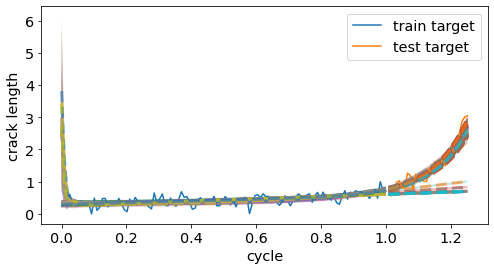

In [ ]:
fig = plot_target_prediction_ensemble_gaussian(
    train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model
)


In [80]:
def plot_target_prediction_sample(
    traininput,
    traintarget,
    trainprediction,
    testinput,
    testtarget,
    testprediction=None,
    title=None,
    figsize=(8, 4),
    marker="o",
    markersize=2,
):
    """
    Plot prediction interval, along with 0.025 and 0.975 quantile
    """

    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, alpha=0.6, markersize=markersize)
    plt.plot(testinput, testtarget, label="test target", marker=marker, alpha=0.6, markersize=markersize)
    # plt.scatter(traininput, traintarget, label="train target", marker=marker, alpha=0.6, s=markersize)
    # plt.scatter(testinput, testtarget, label="test target", marker=marker, alpha=0.6, s=markersize)
    plt.plot(
        traininput,
        trainprediction.mean(0),
        label="train prediction mean",
        # marker=marker,
        linestyle="--",
        linewidth=3,
    )

    high_quantile = np.quantile(trainprediction, 0.975, axis=0)
    low_quantile = np.quantile(trainprediction, 0.025, axis=0)
    #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
    plt.fill_between(
        traininput.squeeze(),
        low_quantile.squeeze(),
        high_quantile.squeeze(),
        # color="green",
        alpha=0.3,
        label="train CI 0.95",
    )

    if testprediction is not None:
        plt.plot(
            testinput,
            testprediction.mean(0),
            # marker=marker,
            label="test prediction mean",
            linestyle="--",
            linewidth=3,
        )
        high_quantile = np.quantile(testprediction, 0.975, axis=0)
        low_quantile = np.quantile(testprediction, 0.025, axis=0)
        #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
        plt.fill_between(
            testinput.squeeze(),
            low_quantile.squeeze(),
            high_quantile.squeeze(),
            # color="red",
            alpha=0.3,
            label="test CI 0.95",
        )
        # plt.ylim(-0.01, 0.02)

    plt.legend(loc="upper left")
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    if title:
        plt.title(title)

    return fig


# fig = plot_target_prediction_sample(
#     train_xtensor,
#     train_ytensor,
#     train_dropout_predictions,
#     test_xtensor,
#     test_ytensor,
#     test_dropout_predictions,
#     marker="o",
#     markersize=2,
# )

## Monte Carlo Dropout

https://stackoverflow.com/questions/63285197/measuring-uncertainty-using-mc-dropout-on-pytorch


In [ ]:
# default dropout uses a different mask for each input in the batch
dropout_test_model = nn.Sequential(nn.Linear(2, 4), nn.Dropout(0.5))
dropout_test_model(torch.rand(3, 2))

tensor([[-0.4315,  0.0000, -0.0000,  1.3635],
        [-0.6787,  0.2196, -0.0000,  1.5378],
        [-0.2293,  0.0000, -1.2206,  0.0000]], grad_fn=<MulBackward0>)

In [73]:
class FullyConnectedDropout(nn.Module):
    def __init__(
        self, layer_size, drop_proba=0.05, activation=nn.Tanh, need_output_exp=True
    ):
        super().__init__()
        self.need_output_exp = need_output_exp
        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i + 1]))
            layers.append(activation())
            layers.append(nn.Dropout(drop_proba))

        self.layers = nn.Sequential(*layers, nn.Linear(layer_size[-2], layer_size[-1]))

    def forward(self, inpt):
        outpt = self.layers(inpt)
        if self.need_output_exp:
            outpt = torch.exp(outpt)
        return outpt


 Epoch 1 loss = 0.1445389688014984
data loss = 3.5516977310180664 ; physics loss = 5.743535425040136e-08
data norm = 26.207273483276367 ; physics norm = 6.370664323185338e-06
normalized data loss = 0.13552336394786835 ; normalized physics loss = 0.009015599265694618

 Epoch 1001 loss = 0.0024553099647164345
data loss = 0.03464626520872116 ; physics loss = 2.988247149726675e-10
data norm = 26.207273483276367 ; physics norm = 2.636765259467211e-07
normalized data loss = 0.001322009484283626 ; normalized physics loss = 0.0011333003640174866

 Epoch 2001 loss = 0.0012657283805310726
data loss = 0.025605013594031334 ; physics loss = 1.6468082453258148e-10
data norm = 26.207273483276367 ; physics norm = 5.704041541321203e-07
normalized data loss = 0.000977019313722849 ; normalized physics loss = 0.0002887090086005628

 Epoch 3001 loss = 0.0011475072242319584
data loss = 0.023370258510112762 ; physics loss = 1.7350824943473953e-10
data norm = 26.207273483276367 ; physics norm = 6.78402216180

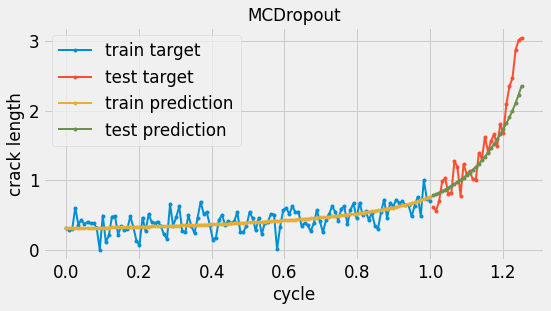

In [74]:
dropout_model = FullyConnectedDropout(
    [1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh
).to(DEVICE)

dropout_train_args = dict(
    loss_func = compute_data_physics_loss_gradmagnorm,
    loss_func_args = dict(
        **base_loss_func_args,
        model = dropout_model,
    ),
    epochs = 10000,
    verbose=True,
)

dropout_result = train(dropout_train_args, gradmagnorm_result_args)

train_predictions, _ = predict_model(dropout_model, train_xtensor)
test_predictions, test_loss = predict_model(dropout_model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    title='MCDropout'
)
# fig.savefig(os.path.join(fig_dir, "only-physics.pdf"), bbox_inches="tight")

In [75]:
"""
def train_model_physics_magnitude_norm(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=5,
    physics_coeff=1,
    optim=None,
    verbose=True,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

    traininput = traininput.to(DEVICE)
    trainlabel = trainlabel.to(DEVICE)
    physicsinput = physicsinput.to(DEVICE)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(
        dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[]
    )
    model.train()

    for epoch in range(epochs):
        optim.zero_grad()

        epoch_result = compute_data_physics_loss(
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
            physics_coeff=physics_coeff,
        )
        dataloss = epoch_result['data_loss']
        physicsloss = epoch_result['physics_loss']
        rescaled_derivative = epoch_result['rescaled_derivative']
        physics_constraint = epoch_result['physics_constraint']

        # # detach ???
        # differential_norm = torch.abs(rescaled_derivative.detach()) + torch.abs(physics_constraint.detach())
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(
            physics_constraint
        )
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(trainlabel**2)

        #         differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        #         differential_norm = torch.sum(differential_norm)
        #         data_norm = torch.sum(trainlabel)

        loss = dataloss / data_norm + physicsloss / differential_norm
        loss.backward()
        optim.step()
        #         scheduler.step(loss)
        metric["dataloss"].append(dataloss.detach().item())
        metric["physicsloss"].append(physicsloss.detach().item())
        metric["normalized_dataloss"].append((dataloss / data_norm).detach().item())
        metric["normalized_physicsloss"].append(
            (physicsloss / differential_norm).detach().item()
        )

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}")
            #             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
            print(
                f"normalized data loss = {metric['normalized_dataloss'][-1]} ; normalized physics loss = {metric['normalized_physicsloss'][-1]}"
            )
            print(f"{data_norm = } {differential_norm = }")

            #             print(f"physic loss 2 = {physicsloss2.detach().item()}")
            #             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
            #                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8, 4))
            plt.plot(
                tensor_to_array(physicsinput),
                tensor_to_array(rescaled_derivative),
                label="rescaled derivative",
                marker="o",
            )
            plt.plot(
                tensor_to_array(physicsinput),
                tensor_to_array(physics_constraint),
                label="paris",
                marker="o",
            )
            plt.legend()
            figs.append(fig)

            plt.close()

    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)

    return metric
"""

'\ndef train_model_physics_magnitude_norm(\n    model,\n    traininput,\n    trainlabel,\n    physicsinput,\n    xscaler,\n    yscaler,\n    paris_C,\n    paris_m,\n    paris_dsigma,\n    epochs=5,\n    physics_coeff=1,\n    optim=None,\n    verbose=True,\n):\n\n    if optim is None:\n        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)\n\n    traininput = traininput.to(DEVICE)\n    trainlabel = trainlabel.to(DEVICE)\n    physicsinput = physicsinput.to(DEVICE)\n    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode=\'min\',\n    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)\n\n    metric = dict(\n        dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[]\n    )\n    model.train()\n\n    for epoch in range(epochs):\n        optim.zero_grad()\n\n        epoch_result = compute_data_physics_loss(\n            paris_C,\n            paris_m,\n            paris_dsigma,\n     

In [76]:
"""
%%time
model_dropout = FullyConnectedDropout(
    [1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh
).to(DEVICE)
figs = []
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model_dropout.parameters(), lr=1e-2, weight_decay=1e-8)
metric = train_model_physics_magnitude_norm(
    model_dropout,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
    optim=optim,
)

train_predictions, _ = predict_model(model_dropout, train_xtensor)
test_predictions, test_loss = predict_model(model_dropout, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions),
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
)

print(f"{test_loss = }")
"""

'\n%%time\nmodel_dropout = FullyConnectedDropout(\n    [1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh\n).to(DEVICE)\nfigs = []\nepochs = 10000\nphysics_coeff = 1\n\noptim = torch.optim.Adam(model_dropout.parameters(), lr=1e-2, weight_decay=1e-8)\nmetric = train_model_physics_magnitude_norm(\n    model_dropout,\n    train_xtensor,\n    train_ytensor,\n    physics_xtensor,\n    train_xscaler_torch,\n    train_yscaler_torch,\n    paris_C,\n    paris_m,\n    paris_dsigma,\n    epochs=epochs,\n    physics_coeff=physics_coeff,\n    optim=optim,\n)\n\ntrain_predictions, _ = predict_model(model_dropout, train_xtensor)\ntest_predictions, test_loss = predict_model(model_dropout, test_xtensor, test_ytensor)\n# print(train_predictions.shape, test_predictions.shape)\n\n# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions),\n#                        test_xscaled, test_yscaled, torch.exp(test_predictions))\nfig = plot_target_prediction(\n    train_xtensor,\n    

In [77]:
def enable_dropout(model):
    """Enable dropout during test time"""
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

    return model


def predict_dropout(model, sample_size, inputdata, targetdata=None):
    model.eval()
    model = enable_dropout(model)
    loss = None
    all_predictions = []

    with torch.no_grad():
        for iteration in range(sample_size):
            outputdata = model(inputdata.to(DEVICE))
            #         predictions = outputdata
            if targetdata is not None:
                loss = tnf.mse_loss(outputdata, targetdata.to(DEVICE)).detach().item()

            all_predictions.append(outputdata.detach().cpu().numpy())

    return np.stack(all_predictions, 0)

In [78]:
"""
def plot_multiple_target_prediction(
    traininput,
    traintarget,
    trainprediction,
    testinput,
    testtarget,
    testprediction=None,
    title=None,
    figsize=(12, 4),
    marker="o",
):

    fig = plt.figure(figsize=figsize)
    plt.plot(
        traininput, traintarget, label="train target", marker=marker, linestyle="--"
    )
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="--")
    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)

    plt.plot([], [], label="test prediction", color="black")

    if testprediction is not None:
        #         for sample_testprediction in testprediction:
        # #             print(sample_testprediction.shape)
        #             plt.plot(testinput, sample_testprediction, marker=marker, color="black", alpha=0.6)

        plt.plot(
            testinput, np.mean(testprediction, axis=0), marker=marker, color="black"
        )
        high_quantile = np.quantile(testprediction, 0.975, axis=0)
        low_quantile = np.quantile(testprediction, 0.025, axis=0)
        #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
        plt.fill_between(
            testinput.squeeze(),
            low_quantile.squeeze(),
            high_quantile.squeeze(),
            # color="black",
            alpha=0.4,
        )

    plt.legend()
    if title:
        plt.title(title)

    return fig
"""

'\ndef plot_multiple_target_prediction(\n    traininput,\n    traintarget,\n    trainprediction,\n    testinput,\n    testtarget,\n    testprediction=None,\n    title=None,\n    figsize=(12, 4),\n    marker="o",\n):\n\n    fig = plt.figure(figsize=figsize)\n    plt.plot(\n        traininput, traintarget, label="train target", marker=marker, linestyle="--"\n    )\n    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="--")\n    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)\n\n    plt.plot([], [], label="test prediction", color="black")\n\n    if testprediction is not None:\n        #         for sample_testprediction in testprediction:\n        # #             print(sample_testprediction.shape)\n        #             plt.plot(testinput, sample_testprediction, marker=marker, color="black", alpha=0.6)\n\n        plt.plot(\n            testinput, np.mean(testprediction, axis=0), marker=marker, color="black"\n        )\n        hi

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.215
  RMSE          0.282
  MDAE          0.147
  MARPD         14.906
  R2            0.829
  Correlation   0.965
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.181
  Mean-absolute Calibration Error       0.154
  Miscalibration Area                   0.155
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.387
     Group Size: 0.56 -- Calibration Error: 0.231
     Group Size: 1.00 -- Calibration Error: 0.154
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.452
     Group Size: 0.56 -- Calibration Error: 0.271
     Group Size: 1.00 -- Calibration Error: 0.181
===============

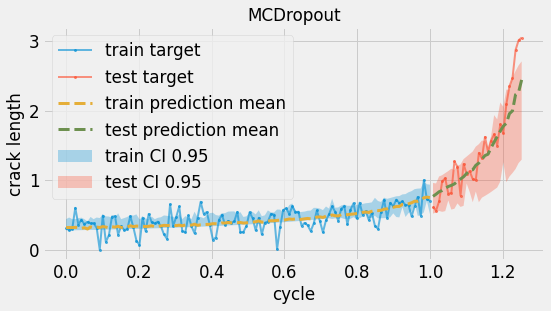

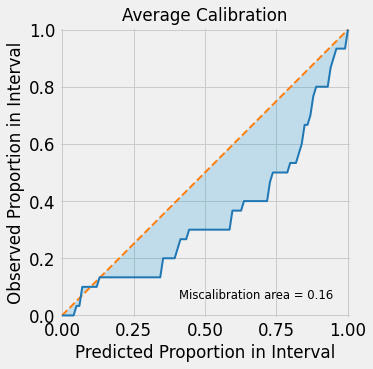

In [81]:
train_dropout_predictions = predict_dropout(
    dropout_model, 100, train_xtensor, train_ytensor
)
test_dropout_predictions = predict_dropout(
    dropout_model, 100, test_xtensor, test_ytensor
)
# print(dropout_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_dropout_predictions,
    test_xtensor,
    test_ytensor,
    test_dropout_predictions,
    marker="o",
    markersize=2,
    title="MCDropout",
)
# fig.savefig("../fig/monte-carlo-dropout-uncertainty-100-samples.pdf", bbox_inches="tight")

test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(
    test_dropout_predictions.squeeze(), 0
)
ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
# ax.figure.savefig("../fig/monte-carlo-dropout-calibration-100-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.568
  RMSE          0.744
  MDAE          0.453
  MARPD         40.493
  R2            -0.186
  Correlation   0.961
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.461
  Mean-absolute Calibration Error       0.394
  Miscalibration Area                   0.398
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.490
     Group Size: 0.56 -- Calibration Error: 0.462
     Group Size: 1.00 -- Calibration Error: 0.394
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.570
     Group Size: 0.56 -- Calibration Error: 0.513
     Group Size: 1.00 -- Calibration Error: 0.461
==============

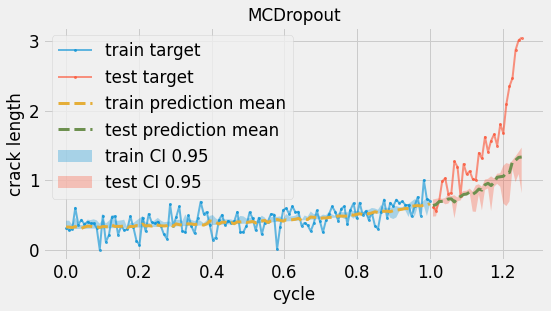

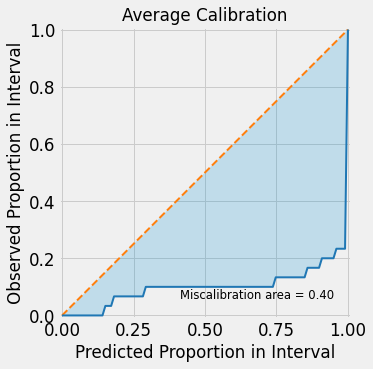

In [ ]:
train_dropout_predictions = predict_dropout(
    dropout_model, 10, train_xtensor, train_ytensor
)
test_dropout_predictions = predict_dropout(
    dropout_model, 10, test_xtensor, test_ytensor
)
# print(dropout_predictions.shape)

# fig = plot_multiple_target_prediction(train_xtensor, train_ytensor, train_predictions,
#                        test_xtensor, test_ytensor, dropout_predictions, marker="")

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_dropout_predictions,
    test_xtensor,
    test_ytensor,
    test_dropout_predictions,
    marker="o",
    markersize=2,
    title="MCDropout",
)
# fig.savefig("../fig/monte-carlo-dropout-uncertainty-10-samples.pdf", bbox_inches="tight")


test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(
    test_dropout_predictions.squeeze(), 0
)
ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
# ax.figure.savefig("../fig/monte-carlo-dropout-calibration-10-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)


## Monte Carlo Dropout same mask

In [82]:
class DropoutSameMask(nn.Module):
    def __init__(self, drop_proba):
        super().__init__()
        self.drop_proba = drop_proba
        self.mask = None

    def forward(self, indata):

        if self.mask == None:
            self.mask = torch.empty(indata.shape[1:]).bernoulli_(1 - self.drop_proba)
        # print(indata, self.mask)
        return indata * self.mask

    def reset_mask(self):
        self.mask = None


class FullyConnectedDropoutSameMask(nn.Module):
    def __init__(
        self, layer_size, drop_proba=0.05, activation=nn.Tanh, need_output_exp=True
    ):
        super().__init__()
        self.need_output_exp = need_output_exp
        self.drop_proba = drop_proba
        layers = []
        self.need_new_mask = True

        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i + 1]))
            layers.append(activation())
            layers.append(DropoutSameMask(drop_proba))

        self.layers = nn.Sequential(*layers, nn.Linear(layer_size[-2], layer_size[-1]))
        # self.masks.append(self.bernoulli.sample((layer_size[-1], layer_size[-2])))

    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            if self.need_new_mask and isinstance(layer, DropoutSameMask):
                layer.reset_mask()
            outpt = layer(outpt)

        # enforce positive value by model the ln and take exp
        if self.need_output_exp:
            outpt = torch.exp(outpt)
        return outpt

    def reset_mask(self):
        self.need_new_mask = True

    def keep_mask(self):
        self.need_new_mask = False

In [83]:
model_dropout_same_mask = FullyConnectedDropoutSameMask(
    [1, 4, 8, 1], drop_proba=0.5, activation=nn.Tanh
).to(DEVICE)
model_dropout_same_mask(torch.rand(3, 1))

tensor([[1.0529],
        [1.1056],
        [1.0491]], grad_fn=<ExpBackward0>)

In [84]:
def predict_dropout_same_mask(model, sample_size, inputdata, targetdata=None):
    model.eval()
    model = enable_dropout(model)
    loss = None
    all_predictions = []

    with torch.no_grad():
        for iteration in range(sample_size):
            model.reset_mask()
            outputdata = model(inputdata.to(DEVICE))
            #         predictions = outputdata
            if targetdata is not None:
                loss = tnf.mse_loss(outputdata, targetdata.to(DEVICE)).detach().item()

            all_predictions.append(outputdata.detach().cpu().numpy())

    return np.stack(all_predictions, 0)


 Epoch 1 loss = 0.02649524062871933
data loss = 0.43982601165771484 ; physics loss = 4.581163004502287e-09
data norm = 26.207273483276367 ; physics norm = 4.716698640550021e-07
normalized data loss = 0.016782592982053757 ; normalized physics loss = 0.009712647646665573

 Epoch 1001 loss = 0.00092987873358652
data loss = 0.018832895904779434 ; physics loss = 2.943476851147153e-10
data norm = 26.207273483276367 ; physics norm = 1.393260163240484e-06
normalized data loss = 0.000718613329809159 ; normalized physics loss = 0.00021126541832927614

 Epoch 2001 loss = 0.0011124149896204472
data loss = 0.02660406567156315 ; physics loss = 1.072258393186587e-10
data norm = 26.207273483276367 ; physics norm = 1.1023024626410916e-06
normalized data loss = 0.0010151405585929751 ; normalized physics loss = 9.72744237515144e-05

 Epoch 3001 loss = 0.0009918486466631293
data loss = 0.022569773718714714 ; physics loss = 1.57664034605709e-10
data norm = 26.207273483276367 ; physics norm = 1.20680329018

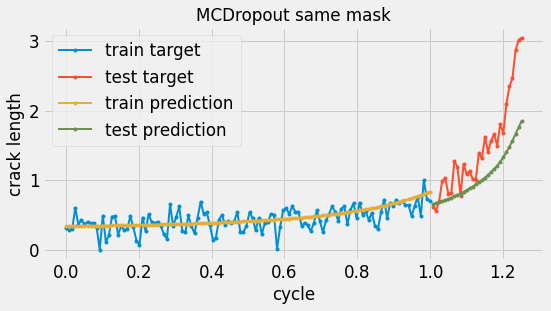

In [85]:
dropout_model_same_mask = FullyConnectedDropoutSameMask(
    [1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh
).to(DEVICE)

dropout_same_mask_train_args = dict(
    loss_func = compute_data_physics_loss_gradmagnorm,
    loss_func_args = dict(
        **base_loss_func_args,
        model = dropout_model_same_mask,
    ),
    epochs = 10000,
    verbose=True,
)

dropout_result = train(dropout_same_mask_train_args, gradmagnorm_result_args)

train_predictions, _ = predict_model(dropout_model_same_mask, train_xtensor)
test_predictions, test_loss = predict_model(dropout_model_same_mask, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    title='MCDropout same mask'
)
# fig.savefig(os.path.join(fig_dir, "only-physics.pdf"), bbox_inches="tight")

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.195
  RMSE          0.240
  MDAE          0.174
  MARPD         14.400
  R2            0.877
  Correlation   0.969
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.134
  Mean-absolute Calibration Error       0.125
  Miscalibration Area                   0.126
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.365
     Group Size: 0.56 -- Calibration Error: 0.202
     Group Size: 1.00 -- Calibration Error: 0.125
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.400
     Group Size: 0.56 -- Calibration Error: 0.214
     Group Size: 1.00 -- Calibration Error: 0.134
===============

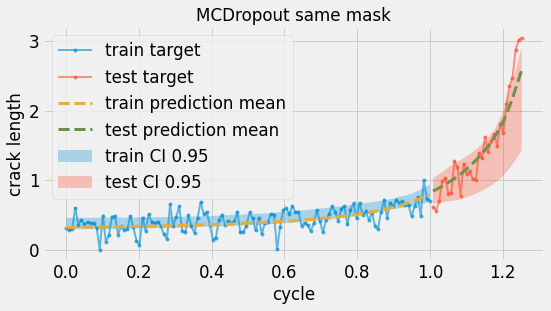

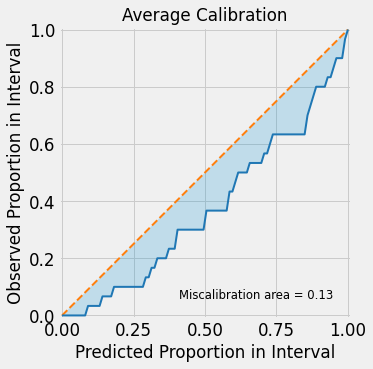

In [86]:
train_dropout_predictions = predict_dropout_same_mask(
    dropout_model_same_mask, 100, train_xtensor, train_ytensor
)
test_dropout_predictions = predict_dropout_same_mask(
    dropout_model_same_mask, 100, test_xtensor, test_ytensor
)
# print(dropout_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_dropout_predictions,
    test_xtensor,
    test_ytensor,
    test_dropout_predictions,
    marker="o",
    markersize=3,
    title="MCDropout same mask",
)

# fig.savefig("../fig/monte-carlo-dropout-same-mask-uncertainty-100-samples.pdf", bbox_inches="tight")

test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(
    test_dropout_predictions.squeeze(), 0
)

ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
# ax.figure.savefig("../fig/monte-carlo-dropout-same-mask-calibration-100-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.690
  RMSE          0.882
  MDAE          0.575
  MARPD         52.761
  R2            -0.665
  Correlation   0.962
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.544
  Mean-absolute Calibration Error       0.468
  Miscalibration Area                   0.473
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.490
     Group Size: 0.56 -- Calibration Error: 0.490
     Group Size: 1.00 -- Calibration Error: 0.468
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.570
     Group Size: 0.56 -- Calibration Error: 0.570
     Group Size: 1.00 -- Calibration Error: 0.544
==============

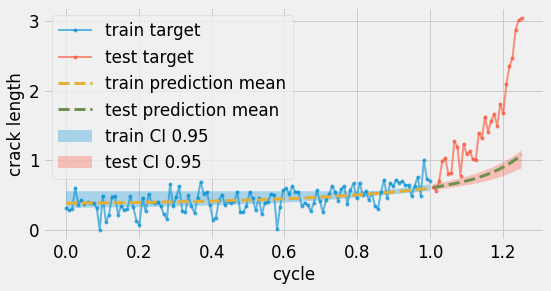

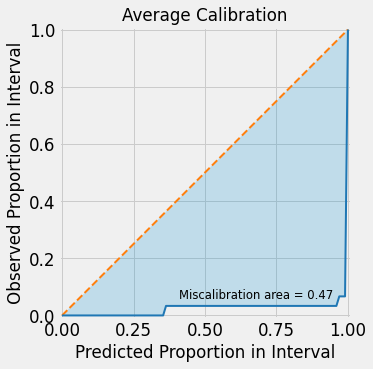

In [ ]:
train_dropout_predictions = predict_dropout_same_mask(
    dropout_model_same_mask, 10, train_xtensor, train_ytensor
)
test_dropout_predictions = predict_dropout_same_mask(
    dropout_model_same_mask, 10, test_xtensor, test_ytensor
)
# print(dropout_predictions.shape)

# fig = plot_multiple_target_prediction(train_xtensor, train_ytensor, train_predictions,
#                        test_xtensor, test_ytensor, dropout_predictions, marker="")

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_dropout_predictions,
    test_xtensor,
    test_ytensor,
    test_dropout_predictions,
    marker="o",
    markersize=3,
)

# fig.savefig("../fig/monte-carlo-dropout-same-mask-uncertainty-10-samples.pdf", bbox_inches="tight")

test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(
    test_dropout_predictions.squeeze(), 0
)

ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
# ax.figure.savefig("../fig/monte-carlo-dropout-same-mask-calibration-10-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

## Bayes by backprop model

Plot evolution of parameters' Gaussian variance. More data and less noise should lead to smaller variance.

https://arxiv.org/pdf/1505.05424.pdf

Weights are drawn from Gaussian with learned mean and variance

\begin{align}
w \sim \mathcal N (\mu, \sigma^2) \\
ln\ \mathcal N (x; \mu, \sigma^2) = ln\ (\frac {1} {\sqrt(2 \pi) \sigma} exp(\frac {-(x - \mu)^2} {2 \sigma^2}))
= - \frac 1 2 ln\ 2 \pi - ln\ \sigma - \frac {(x-\mu)^2} {2 \sigma^2}
\end{align}

Variational inference and ELBO: approximate posterior $p(w|D)$ with proposal $q(w; \theta)$
\begin{align}
\theta^* = argmin_\theta\ KL [q(w; \theta) | p(w | D) ] = argmin_\theta\ \int q(w; \theta)\ ln\ \frac {q(w; \theta)} {p(D|w) p(w)} dw
= argmin_\theta\ \int q(w; \theta)\ ln\ \frac {q(w; \theta)} {p(w)} dw - \int q(w; \theta)\ ln\ p(D|w) dw \\
=> argmin_\theta\ \beta KL[ q(w; \theta) | p(w)] - E_{q(w; \theta)} [p(D|w)]
\end{align}


In [96]:
def mse_to_log_gaussian(mse, sigma):
    return float(-0.5 * np.log(2 * np.pi) - torch.log(torch.abs(sigma))) - mse / (
        2 * sigma**2
    )


def log_gaussian(x, mu, sigma):
    return float(-0.5 * np.log(2 * np.pi) - torch.log(torch.abs(sigma))) - (
        x - mu
    ) ** 2 / (2 * sigma**2)


def log_gaussian_logsigma(x, mu, logsigma):
    return (
        float(-0.5 * np.log(2 * np.pi))
        - logsigma
        - (x - mu) ** 2 / (2 * torch.exp(logsigma) ** 2)
    )


def reparameterize_std(reparam_std):
    return torch.log1p(torch.exp(reparam_std))

In [97]:
def plot_metric(ax, metric, metrickey):
    return ax.plot(metric[metrickey], label=metrickey)


def plot_variational_training_metrics(metric, title=None, figsize=(20, 6)):

    fig, axes = plt.subplots(1, 2, figsize=(figsize))
    axes = axes.flatten()

    axes[0].set_xlabel("epoch")
    plot_metric(axes[0], metric, "logprior")
    plot_metric(axes[0], metric, "logproposal")
    axes[0].plot(metric["logproposal"] - metric["logprior"], label="KL divergence")
    axes[0].legend()

    plot_metric(axes[1], metric, "data_loglikelihood")
    plot_metric(axes[1], metric, "physics_loglikelihood")
    axes[1].plot(
        metric["data_loglikelihood"] + metric["physics_loglikelihood"],
        label="loglikelihood",
    )
    axes[1].set_xlabel("epoch")
    axes[1].legend()

    if title:
        plt.title(title)

    return fig

In [101]:
# https://gist.github.com/vvanirudh/9e30b2f908e801da1bd789f4ce3e7aac
# https://github.com/cpark321/uncertainty-deep-learning/blob/master/01.%20Bayes-by-Backprop.ipynb


class BayesBackpropLinear(nn.Module):
    def __init__(self, inputsize, outputsize, prior_std):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.prior_std = torch.tensor(prior_std)

        self.weight_mean = nn.Parameter(
            torch.Tensor(inputsize, outputsize).normal_(0, prior_std)
        )
        self.weight_logstd = nn.Parameter(
            torch.Tensor(inputsize, outputsize).normal_(0, prior_std)
        )

        self.bias_mean = nn.Parameter(torch.Tensor(1, outputsize).uniform_(-1, 1))
        self.bias_logstd = nn.Parameter(torch.Tensor(1, outputsize).uniform_(-1, 1))

        self.logprior = 0
        self.logproposal = 0
        self.normal01 = td.Normal(0, 1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(
                inputdata.size()[0], self.outputsize
            )
            return output, self.logprior, self.logproposal

        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(DEVICE)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(DEVICE)
        weight = (
            self.weight_mean + torch.exp(self.weight_logstd) * epsilon_weight
            # self.weight_mean + tnf.softplus(self.weight_logstd) * epsilon_weight
            # self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        )
        bias = (
            self.bias_mean + torch.exp(self.bias_logstd) * epsilon_bias
            # self.bias_mean + tnf.softplus(self.bias_logstd) * epsilon_bias
            # self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        )

        output = torch.mm(inputdata, weight) + bias.expand(
            inputdata.size()[0], self.outputsize
        )
        self.logprior = (
            log_gaussian(weight, torch.zeros(1), self.prior_std).sum()
            + log_gaussian(bias, torch.zeros(1), self.prior_std).sum()
        )
        self.logproposal = (
            log_gaussian_logsigma(weight, self.weight_mean, self.weight_logstd).sum()
            + log_gaussian_logsigma(bias, self.bias_mean, self.bias_logstd).sum()
        )

        return output, self.logprior, self.logproposal


class BayesBackpropFullyConnected(nn.Module):
    def __init__(
        self,
        layer_size,
        likelihood_std=0.1,
        prior_std=1.0,
        activation=nn.Tanh,
        need_output_exp=False,
    ):
        super().__init__()
        self.prior_std = torch.tensor(prior_std)
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.logprior_layers = 0
        self.logproposal_layers = 0

        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(BayesBackpropLinear(layer_size[i], layer_size[i + 1], prior_std))
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers, BayesBackpropLinear(layer_size[-2], layer_size[-1], prior_std)
        )

    def forward(self, indata, need_sample=True):
        outdata = indata
        self.logprior_layers = 0
        self.logproposal_layers = 0

        for layer in self.layers:
            if isinstance(layer, BayesBackpropLinear):
                outdata, logprior, logproposal = layer(outdata, need_sample)
                self.logprior_layers += logprior
                self.logproposal_layers += logproposal
            else:
                outdata = layer(outdata)

        if self.need_output_exp:
            outdata = torch.exp(outdata)

        return outdata, self.logprior_layers, self.logproposal_layers

    def forward_sample(inputdata, targetdata, sample_size=10):

        samples_logprior, samples_logproposal, samples_loglikelihood = 0.0, 0.0, 0.0

        for samplecount in range(sample_size):
            prediction, logprior_layers, logproposal_layers = self.forward(inputdata)

            samples_logprior += logprior_layers
            samples_logproposal += logproposal_layers
            samples_loglikelihood += log_gaussian(
                prediction, targetdata, self.likelihood_std
            ).sum()

        return (
            samples_logprior / sample_size,
            samples_logproposal / sample_size,
            samples_loglikelihood / sample_size,
        )

In [102]:
def sample_prediction(model, inputdata, targetdata=None, sample_size=10):
    model.eval()
    predictions = []

    with torch.no_grad():
        for sample_count in range(sample_size):
            outdata = model(inputdata.to(DEVICE), need_sample=True)
            predictions.append(outdata[0].detach().cpu())
    return torch.stack(predictions, dim=0)

In [103]:
model = BayesBackpropFullyConnected(
    [1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh
).to(DEVICE)
model(torch.randn(2, 1))

(tensor([[-3.2949],
         [-3.3061]], grad_fn=<AddBackward0>),
 tensor(-1920.5054, grad_fn=<AddBackward0>),
 tensor(-45.0945, grad_fn=<AddBackward0>))

## Bayes by backprop training

In [104]:
def compute_data_physics_loss_bayes_backprop(
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    input_data,
    target_data,
    input_physics,
    input_scaler,
    output_scaler,
    sample_size=10,
    kldiv_coeff=1,
):

    keys = "prior proposal data_likelihood physics_likelihood"
    result = {key: 0.0 for key in keys.split(' ')}
    input_physics.requires_grad_(True)

    for samplecount in range(sample_size):
        # same sample for data and physics ?
        data_output = model.forward(input_data)
        physics_output = model.forward(input_physics)
        physics_constraint = 1 * paris_law(
            output_scaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma
        )
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")

        result['prior'] += data_output[1] + physics_output[1]
        result['proposal'] += data_output[2] + physics_output[2]
        #         print(f"{samples_logprior = } {samples_logproposal = }")

        derivative = torch.autograd.grad(
            outputs=physics_output[0],
            inputs=input_physics,
            grad_outputs=torch.ones_like(input_physics),
            retain_graph=True,
            create_graph=True,
        )[0]
        rescaled_derivative = (
            derivative
            * (output_scaler.max - output_scaler.min)
            / (input_scaler.max - input_scaler.min)
        )

        differential_norm = torch.abs(rescaled_derivative) + torch.abs(
            physics_constraint
        )
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(target_data**2)
        #         print(f"{data_norm = } {differential_norm = }")

        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(data_prediction, targetdata, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(rescaled_derivative, physics_constraint, model.likelihood_std).mean()

        result['data_likelihood'] += log_gaussian(
            data_output[0] / torch.sqrt(data_norm),
            target_data / torch.sqrt(data_norm),
            model.likelihood_std,
        ).mean()
        result['physics_likelihood'] += log_gaussian(
            rescaled_derivative / torch.sqrt(differential_norm),
            physics_constraint / torch.sqrt(differential_norm),
            model.likelihood_std,
        ).mean()
    #         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")

    # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
    # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)

    averaged_result = {key:value / sample_size for key, value in result.items()}
    averaged_result['backward_loss'] = kldiv_coeff * (averaged_result['proposal'] - averaged_result['prior']) 
    - (averaged_result['data_likelihood'] + averaged_result['physics_likelihood'])

    return averaged_result

In [105]:
bayes_backprop_initialize_result = partial(
    initialize_result, 
    metric_name="prior proposal data_likelihood physics_likelihood",
    separator=' ',
)

def bayes_backprop_update_result(result, epoch_result):
    for key, value in epoch_result.items():
        if not key == 'backward_loss':
            result[key].append(value.detach().item())
    return result

def bayes_backprop_log_result(epoch, result, epoch_result):
    print(f"\n Epoch {epoch+1} loss = {epoch_result['backward_loss'].detach().item()}")
    print(f"data likelihood = {epoch_result['data_likelihood']} ; physics likelihood = {epoch_result['physics_likelihood']}")
    print(f"log prior = {epoch_result['prior']} ; log proposal = {epoch_result['proposal']}")
    # print(f"data norm = {epoch_result['data_norm']} ; physics norm = {epoch_result['differential_norm']}")
    # print(f"normalized data loss = {epoch_result['data_loss']/epoch_result['data_norm']} ; normalized physics loss = {epoch_result['physics_loss']/epoch_result['differential_norm']}")

bayes_backprop_result_args = dict(
    initialize_result_func = bayes_backprop_initialize_result,
    update_result_func = bayes_backprop_update_result,
    log_result_func = bayes_backprop_log_result,
)

In [106]:
%%time

bayes_backprop_model = BayesBackpropFullyConnected([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(DEVICE)

bayes_backprop_train_args = dict(
    loss_func = compute_data_physics_loss_bayes_backprop,
    loss_func_args = dict(
        **base_loss_func_args,
        model = bayes_backprop_model,
        sample_size=10,
        kldiv_coeff=1e-6,
    ),
    epochs = 10000,
    verbose=True,
)

bayes_backprop_result = train(bayes_backprop_train_args, bayes_backprop_result_args)
# torch.save(model_bayes_backprop.state_dict(), os.path.join(saved_model_dir, "bayes-backprop-10-samples.pt"))


 Epoch 1 loss = 6.695374759146944e-05
data likelihood = -1.018736481666565 ; physics likelihood = -0.9232791066169739
log prior = -160.60748291015625 ; log proposal = -93.65373229980469

 Epoch 1001 loss = 8.221435621180717e-08
data likelihood = -1.033629298210144 ; physics likelihood = -0.9233113527297974
log prior = -92.64286804199219 ; log proposal = -92.56065368652344

 Epoch 2001 loss = 2.526473963371245e-07
data likelihood = -1.0101174116134644 ; physics likelihood = -0.9233828783035278
log prior = -91.65644073486328 ; log proposal = -91.40379333496094

 Epoch 3001 loss = 3.7117004580977664e-08
data likelihood = -1.0271037817001343 ; physics likelihood = -0.9232460856437683
log prior = -88.68253326416016 ; log proposal = -88.64541625976562

 Epoch 4001 loss = -1.6916656875309855e-07
data likelihood = -0.9771572351455688 ; physics likelihood = -0.9229615926742554
log prior = -95.27018737792969 ; log proposal = -95.4393539428711

 Epoch 5001 loss = 1.9760131308999007e-09
data like

torch.Size([2, 120, 1]) torch.Size([2, 30, 1])
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.868
  RMSE          1.117
  MDAE          0.669
  MARPD         72.036
  R2            -1.672
  Correlation   -0.870
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.130
  Mean-absolute Calibration Error       0.114
  Miscalibration Area                   0.115
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.303
     Group Size: 0.56 -- Calibration Error: 0.177
     Group Size: 1.00 -- Calibration Error: 0.114
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.406
     Group Size: 0.56 -- Calibration Error: 0.219
     Group Size: 1.00 -- Calibration Error: 0.130
=============

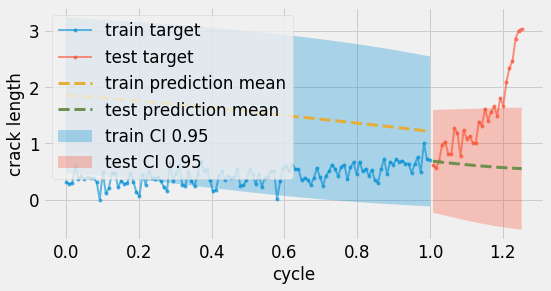

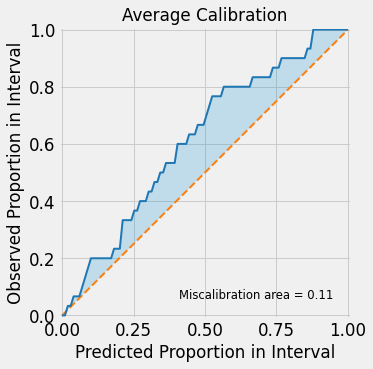

In [107]:
train_predictions = sample_prediction(bayes_backprop_model, train_xtensor, sample_size=2)
test_predictions = sample_prediction(bayes_backprop_model, test_xtensor, test_ytensor, sample_size=2)
print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="o",
    markersize=3,
)

# fig.savefig("../fig/monte-carlo-dropout-same-mask-uncertainty-10-samples.pdf", bbox_inches="tight")

test_mean = torch.mean(test_predictions, 0).numpy().squeeze()
test_std = torch.std(test_predictions, 0).numpy().squeeze()

ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
# ax.figure.savefig("../fig/monte-carlo-dropout-same-mask-calibration-10-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

In [ ]:
with open(os.path.join(result_dir, 'bayes-backprop-calibration-10-samples.json'), 'w') as metrics_file:
    json.dump(str(metrics), metrics_file)
    

In [ ]:
metrics

{'accuracy': {'mae': 0.18486539,
  'rmse': 0.22725601,
  'mdae': 0.16672137,
  'marpd': 13.67882639169693,
  'r2': 0.8894390903078422,
  'corr': 0.9687201904133127},
 'avg_calibration': {'rms_cal': 0.27109889854924313,
  'ma_cal': 0.24433333333333343,
  'miscal_area': 0.24680134680134685},
 'adv_group_calibration': {'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
   'adv_group_cali_mean': array([0.484     , 0.483     , 0.40614286, 0.3569    , 0.34876923,
          0.29558824, 0.30945   , 0.2903913 , 0.277     , 0.24433333]),
   'adv_group_cali_stderr': array([0.012202  , 0.00867094, 0.06468851, 0.03046473, 0.03464899,
          0.01984223, 0.02454525, 0.02347151, 0.01363787, 0.        ])},
  'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        

In [ ]:
# %%capture stored_output
# %%time


In [ ]:
# stored_output.show()

## load saved model

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 10.37it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 10.90it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.212
  RMSE          0.285
  MDAE          0.168
  MARPD         14.539
  R2            0.826
  Correlation   0.959
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.383
  Mean-absolute Calibration Error       0.340
  Miscalibration Area                   0.343
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.489
     Group Size: 0.56 -- Calibration Error: 0.397
     Group Size: 1.00 -- Calibration Error: 0.340
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.559
     Group Size: 0.56 -- Calibration Error: 0.457
     Group Size: 1.00 -- Calibration Error: 0.383
===============

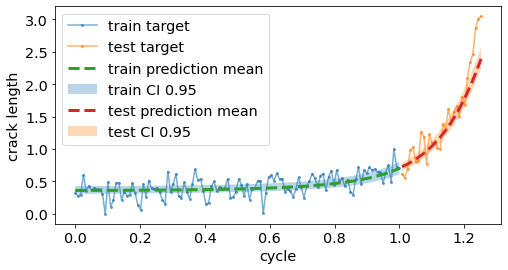

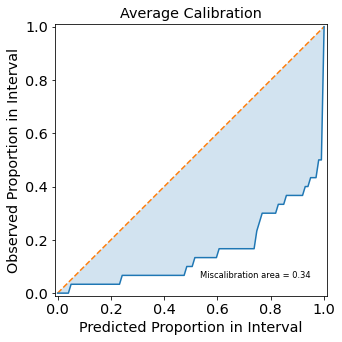

In [ ]:
loaded_model = GaussianMLP(
    [1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh
)

loaded_model.load_state_dict(
    torch.load(os.path.join(saved_model_dir, "bayes-backprop-10-samples.pt"))
)
loaded_model.eval()

train_predictions = (
    sample_prediction(loaded_model, train_xtensor, sample_size=10).squeeze().detach().numpy()
)
test_predictions = (
    sample_prediction(loaded_model, test_xtensor, sample_size=10).squeeze().detach().numpy()
)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="o",
    markersize=2,
)
fig.savefig("../fig/bayes-backprop-uncertainty-10-samples.pdf", bbox_inches="tight")


test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
ax.figure.savefig("../fig/bayes-backprop-calibration-10-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)


 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 10.39it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 10.69it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.184
  RMSE          0.237
  MDAE          0.173
  MARPD         13.252
  R2            0.880
  Correlation   0.961
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.334
  Mean-absolute Calibration Error       0.276
  Miscalibration Area                   0.279
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.484
     Group Size: 0.56 -- Calibration Error: 0.350
     Group Size: 1.00 -- Calibration Error: 0.276
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.559
     Group Size: 0.56 -- Calibration Error: 0.407
     Group Size: 1.00 -- Calibration Error: 0.334
===============

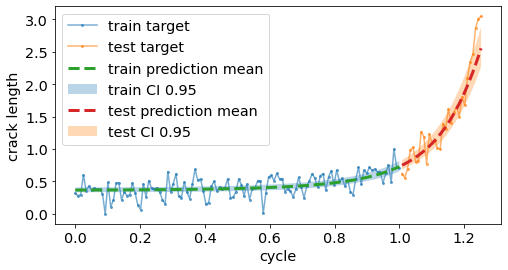

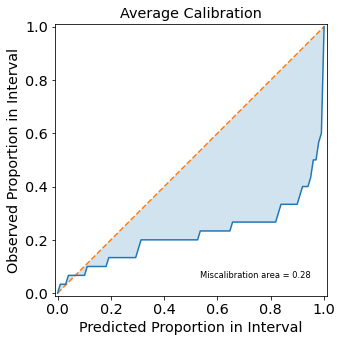

In [ ]:
loaded_model = GaussianMLP(
    [1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh
)

loaded_model.load_state_dict(
    torch.load(os.path.join(saved_model_dir, "bayes-backprop-100-samples.pt"))
)
loaded_model.eval()

train_predictions = (
    sample_prediction(loaded_model, train_xtensor, sample_size=100).squeeze().detach().numpy()
)
test_predictions = (
    sample_prediction(loaded_model, test_xtensor, sample_size=100).squeeze().detach().numpy()
)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="o",
    markersize=2,
)
fig.savefig("../fig/bayes-backprop-uncertainty-100-samples.pdf", bbox_inches="tight")


test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
ax.figure.savefig("../fig/bayes-backprop-calibration-100-samples.pdf", bbox_inches="tight")

metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)


## Inspect Bayes by backprop

In [ ]:
loaded_model = GaussianMLP(
    [1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh
)

loaded_model.load_state_dict(
    torch.load(os.path.join(saved_model_dir, "bayes-backprop-10-samples.pt"))
)
loaded_model.eval()

GaussianMLP(
  (layers): Sequential(
    (0): GaussianLinear()
    (1): Tanh()
    (2): GaussianLinear()
    (3): Tanh()
    (4): GaussianLinear()
  )
)

torch.Size([100, 120, 1]) torch.Size([100, 30, 1])


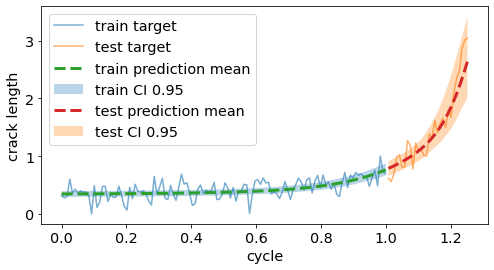

In [ ]:
train_predictions = sample_prediction(loaded_model, train_xtensor, sample_size=100)
test_predictions = sample_prediction(loaded_model, test_xtensor, test_ytensor, sample_size=100)
print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="",
)

In [ ]:
# for name, params in loaded_model.named_parameters():
#     print(name, "=", params)
loaded_model.state_dict()

OrderedDict([('layers.0.weight_mean',
              tensor([[ 0.0116, -1.2247, -2.2184, -0.0546]])),
             ('layers.0.weight_logstd',
              tensor([[-1.5764, -3.4394, -4.0681, -1.6140]])),
             ('layers.0.bias_mean',
              tensor([[-0.0374,  1.3839,  2.7647,  0.0204]])),
             ('layers.0.bias_logstd',
              tensor([[-1.5435, -3.3320, -3.9313, -1.7500]])),
             ('layers.2.weight_mean',
              tensor([[-1.0756e-01,  3.0579e-02,  2.2353e-02, -4.2608e-02],
                      [ 3.1735e-01,  9.3018e-03, -8.2449e-01, -1.6175e+00],
                      [-7.2592e-02, -6.4570e-02, -1.4871e+00, -3.9015e+00],
                      [ 1.8964e-02,  2.4528e-04, -3.8814e-02, -8.1190e-03]])),
             ('layers.2.weight_logstd',
              tensor([[-0.0581,  0.3013, -2.0760, -1.2987],
                      [-0.6297, -0.0204, -2.3553, -1.0474],
                      [-0.9125, -0.2468, -2.8952, -1.3940],
                      [-0.0299,

In [ ]:
# OrderedDict({key:value for key, value in loaded_model.state_dict().items() if "weight_mean" in key})
for param in loaded_model.state_dict():
    print(param)

layers.0.weight_mean
layers.0.weight_logstd
layers.0.bias_mean
layers.0.bias_logstd
layers.2.weight_mean
layers.2.weight_logstd
layers.2.bias_mean
layers.2.bias_logstd
layers.4.weight_mean
layers.4.weight_logstd
layers.4.bias_mean
layers.4.bias_logstd


In [ ]:
def plot_model_parameter(model, selected_key, figsize=(16, 4)):
    statedict = model.state_dict()
    selected_params = OrderedDict(
        {key: param for key, param in statedict.items() if selected_key in key}
    )

    fig, axes = plt.subplots(len(selected_params) // 3, 3, figsize=(figsize))
    axes = axes.flatten()

    for ax, (key, param) in zip(axes, selected_params.items()):
        # print(key, param.shape, param.ndim)
        if "logstd" in selected_key:
            param = reparameterize_std(param)
            key += " reparam"
        im = ax.imshow(param)
        ax.set_title(key)
        ax.figure.colorbar(im, ax=ax)

    return fig

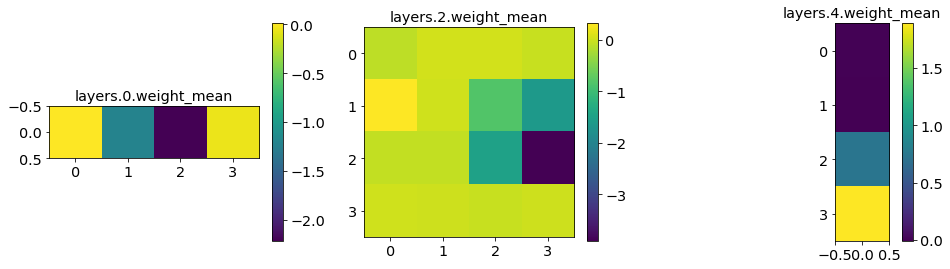

In [ ]:
fig = plot_model_parameter(loaded_model, "weight_mean")

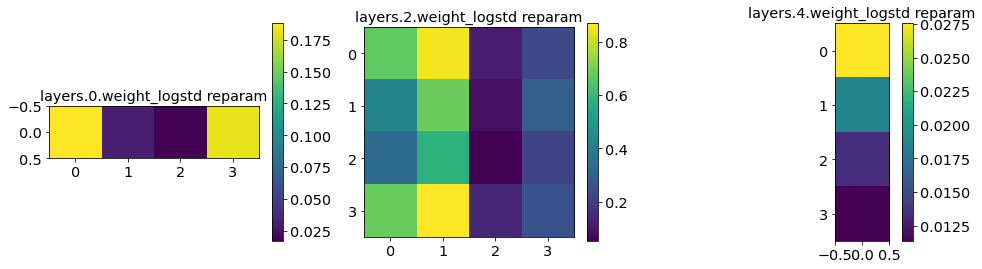

In [ ]:
fig = plot_model_parameter(loaded_model, "weight_logstd")

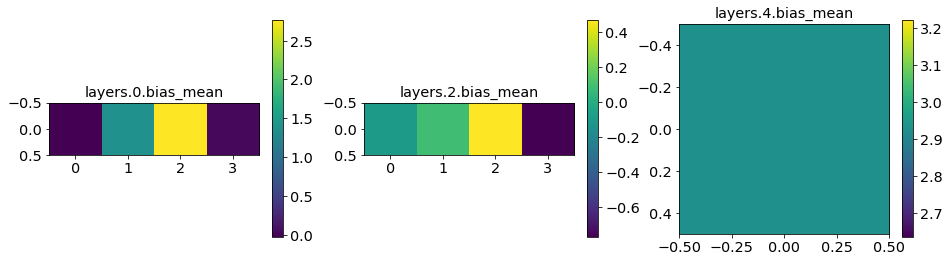

In [ ]:
fig = plot_model_parameter(loaded_model, "bias_mean")

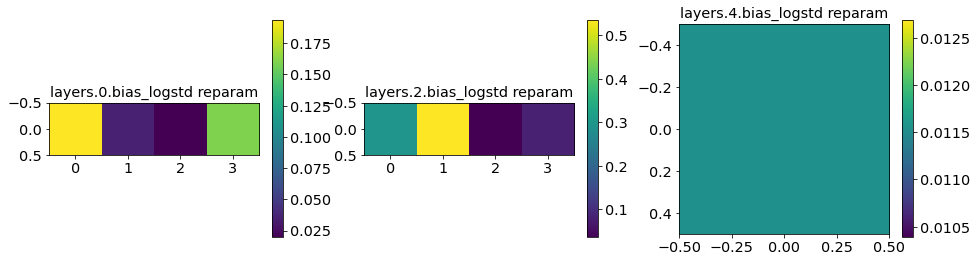

In [ ]:
fig = plot_model_parameter(loaded_model, "bias_logstd")

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

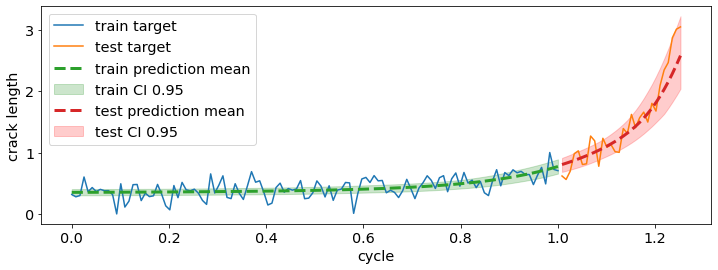

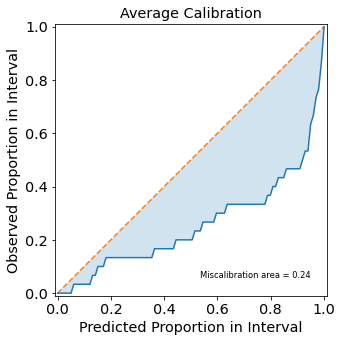

In [ ]:
train_predictions = (
    sample_prediction(loaded_model, train_xtensor, sample_size=100)
    .squeeze()
    .detach()
    .numpy()
)
test_predictions = (
    sample_prediction(loaded_model, test_xtensor, sample_size=100)
    .squeeze()
    .detach()
    .numpy()
)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="",
)

test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

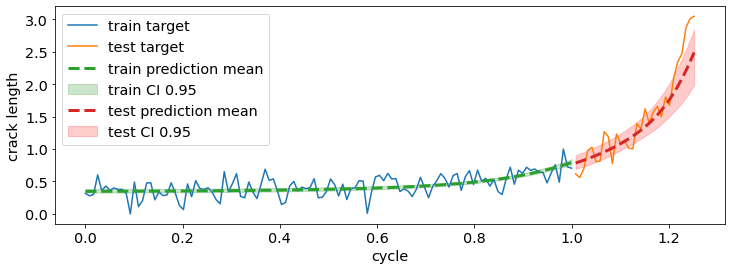

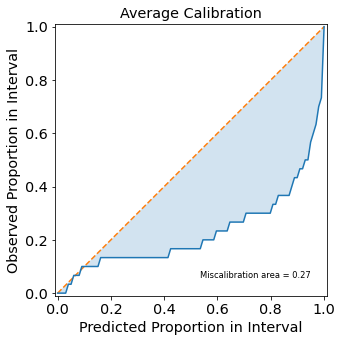

In [ ]:
train_predictions = (
    sample_prediction(loaded_model, train_xtensor, sample_size=10)
    .squeeze()
    .detach()
    .numpy()
)
test_predictions = (
    sample_prediction(loaded_model, test_xtensor, sample_size=10)
    .squeeze()
    .detach()
    .numpy()
)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="",
)

test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.203
  RMSE          0.262
  MDAE          0.148
  MARPD         14.386
  R2            0.854
  Correlation   0.969
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.293
  Mean-absolute Calibration Error       0.251
  Miscalibration Area                   0.253
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.469
     Group Size: 0.56 -- Calibration Error: 0.327
     Group Size: 1.00 -- Calibration Error: 0.251
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.547
     Group Size: 0.56 -- Calibration Error: 0.381
     Group Size: 1.00 -- Calibration Error: 0.293
===============

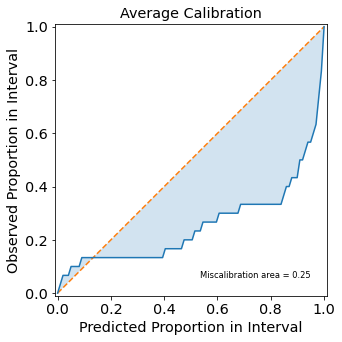

In [ ]:
metrics = uct.metrics.get_all_metrics(
    test_mean, test_std, test_ytensor.numpy().squeeze()
)

## Result radar plot

https://betterdatascience.com/radar-charts-matplotlib-plotly/

https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652


In [ ]:
# datadict = {
#     'MCDropout 10': ,
#     'MCDropout 100': ,
#     'MCDropout* 10',
#     'MCDropout* 100',
#     'Bayes backprop 10',
#     'Bayes backprop 100',
#     'Ensemble 10',
#     'Ensemble 100'
# }

labels = \
"""
MCDropout 100
MCDropout* 10
MCDropout* 100
Bayes backprop 10
Bayes backprop 100
Ensemble 10
Ensemble 100"""\
.split('\n')
labels


['',
 'MCDropout 100',
 'MCDropout* 10',
 'MCDropout* 100',
 'Bayes backprop 10',
 'Bayes backprop 100',
 'Ensemble 10',
 'Ensemble 100']

In [ ]:
def convert_duration(duration_str):
    minute, second = duration_str.split(':')
    return int(minute)*60 + int(second)

test_duration = '01:10'
assert convert_duration(test_duration) == 70

In [ ]:
result_df = pd.read_csv(f'{result_dir}/result - Sheet2.csv', index_col=0)
result_df = result_df.infer_objects()
result_df['Minutes'] = result_df['Time'].transform(convert_duration)
# result_df.drop('Time', axis='columns', inplace=True)
result_df['Log Minutes'] = result_df['Minutes'].apply(np.log)
result_df

,NLL,RMSE,Miscalibration,Sharpness,Time,Minutes,Log Minutes
Method,,,,,,,
MCDropout 10,40.7570,0.265,0.369,0.118,00:12,12,2.484907
MCDropout 100,0.0360,0.269,0.144,0.231,00:12,12,2.484907
MCDropout* 10,0.5160,0.183,0.217,0.172,00:24,24,3.178054
MCDropout* 100,0.0004,0.249,0.127,0.212,00:24,24,3.178054
Bayes backprop 10,1.8370,0.227,0.247,0.158,06:54,414,6.025866
Bayes backprop 100,2.2220,0.238,0.281,0.090,92:18,5538,8.619389
Ensemble 10,22.6470,0.181,0.460,0.025,02:02,122,4.804021
Ensemble 100,22.3460,0.182,0.443,0.026,20:31,1231,7.115582


In [ ]:
# https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable

    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations

    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            # https://matplotlib.org/stable/api/figure_api.html
            'axes_args': {},
            # Tick labels on the scales
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rgrids.html
            'rgrid_tick_lbls_args': {'fontsize':8},
            # Radial (circle) lines
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
            'rad_ln_args': {},
            # Angle lines
            # https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
            'angle_ln_args': {},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center'},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            # https://matplotlib.org/stable/api/spines_api.html
            'outer_ring':{'visible':True, 'color':'#d6d6d6'}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, 
                                          labels=gridlabel, 
                                          angle=angles[j],
                                          **self.format_cfg['rgrid_tick_lbls_args']
                                         )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                                          break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

In [ ]:
"""
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import textwrap

# Prepare our example data
data = load_wine(as_frame=True)['data']

pipe = make_pipeline(StandardScaler(),
                           KMeans(init="k-means++", n_clusters=3, n_init=4, random_state=0)
                          )

data['cluster'] = pipe.fit_predict(data)
result = data.groupby(['cluster']).mean()
"""

,NLL,RMSE,Miscalibration,Sharpness,Log Minutes
Method,,,,,
MCDropout 100,0.0360,0.269,0.144,0.231,2.484907
MCDropout* 100,0.0004,0.249,0.127,0.212,3.178054
Bayes backprop 100,2.2220,0.238,0.281,0.090,8.619389
Ensemble 100,22.3460,0.182,0.443,0.026,7.115582


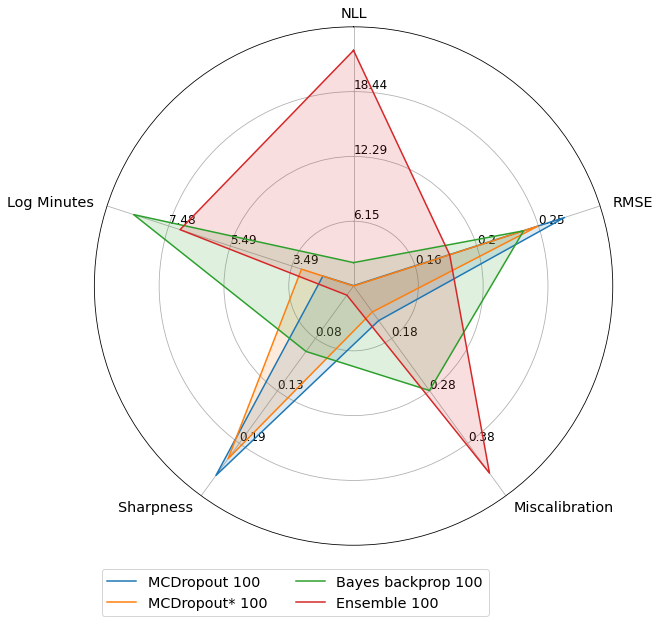

In [ ]:
selected_result_df = result_df[result_df.index.str.endswith('100')].drop('Time;Minutes'.split(';'), axis='columns')
# selected_result_df = result_df.drop('Time;Minutes'.split(';'), axis='columns')
display(selected_result_df)

min_max_per_variable = selected_result_df.describe().T[['min', 'max']]
# min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
# min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))
min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: 0.6*x)
min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: 1.1*x)

variables = selected_result_df.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))   

format_cfg = {
    'rad_ln_args': {'visible':True},
    'outer_ring': {'visible':True},
    'angle_ln_args':{'visible':True},
    'rgrid_tick_lbls_args': {'fontsize':'large'},
    'theta_tick_lbls': {'fontsize':'x-large'},
    'theta_tick_lbls_pad':3
}


fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=4, show_scales=True, format_cfg=format_cfg)

# custom_colors = ['#F67280', '#6C5B7B', '#355C7D']

# for index, row in result_df[result_df.index.str.contains('100')].drop('Time;Minutes'.split(';'), axis='columns').iterrows():
for index, row in selected_result_df.iterrows():
    # print(row)
    radar.plot(row.values, label=index)
    radar.fill(row.values, alpha=0.15)

# radar.set_title("Uncertainty metrics")
# radar.use_legend(**{'loc':'lower left', 'bbox_to_anchor':(0.15, -0.15), 'ncol':radar.plot_counter})
radar.use_legend(**{'loc':'lower left', 'bbox_to_anchor':(0, -0.15), 'ncol':2})
plt.show() 

# fig1.savefig("../fig/metric-100-samples-radarplot.pdf", bbox_inches="tight")

,NLL,RMSE,Miscalibration,Sharpness,Log Minutes
Method,,,,,
MCDropout 10,40.757,0.265,0.369,0.118,2.484907
MCDropout* 10,0.516,0.183,0.217,0.172,3.178054
Bayes backprop 10,1.837,0.227,0.247,0.158,6.025866
Ensemble 10,22.647,0.181,0.460,0.025,4.804021


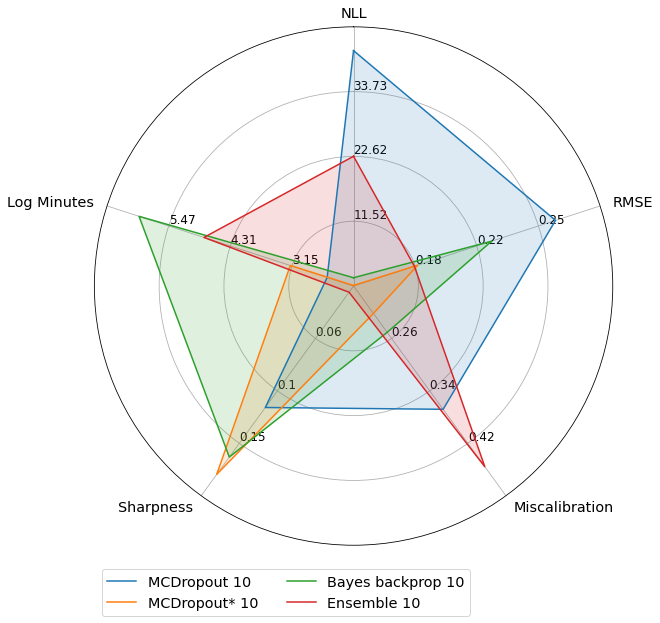

In [ ]:
selected_result_df = result_df[result_df.index.str.endswith('10')].drop('Time;Minutes'.split(';'), axis='columns')
# selected_result_df = result_df.drop('Time;Minutes'.split(';'), axis='columns')
display(selected_result_df)

min_max_per_variable = selected_result_df.describe().T[['min', 'max']]
# min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
# min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))
min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: 0.8*x)
min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: 1.1*x)

variables = selected_result_df.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))   

format_cfg = {
    'rad_ln_args': {'visible':True},
    'outer_ring': {'visible':True},
    'angle_ln_args':{'visible':True},
    'rgrid_tick_lbls_args': {'fontsize':'large'},
    'theta_tick_lbls': {'fontsize':'x-large'},
    'theta_tick_lbls_pad':3
}


fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=4, show_scales=True, format_cfg=format_cfg)

# custom_colors = ['#F67280', '#6C5B7B', '#355C7D']

# for index, row in result_df[result_df.index.str.contains('100')].drop('Time;Minutes'.split(';'), axis='columns').iterrows():
for index, row in selected_result_df.iterrows():
    # print(row)
    radar.plot(row.values, label=index)
    radar.fill(row.values, alpha=0.15)

# radar.set_title("Uncertainty metrics")
# radar.use_legend(**{'loc':'lower left', 'bbox_to_anchor':(0.15, -0.15), 'ncol':radar.plot_counter})
radar.use_legend(**{'loc':'lower left', 'bbox_to_anchor':(0, -0.15), 'ncol':2})
plt.show() 

# fig1.savefig("../fig/metric-10-samples-radarplot.pdf", bbox_inches="tight")

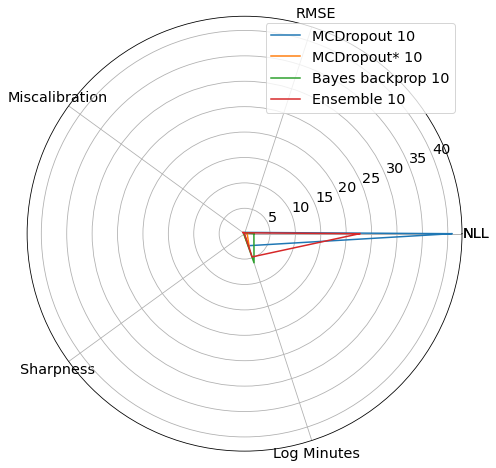

In [ ]:
# https://betterdatascience.com/radar-charts-matplotlib-plotly/

def radar_plot(datadf, figsize=(8,8), title=''):
    newlabels = [*datadf.columns, datadf.columns[0]]
    # print(newlabels)
    # raise Exception()

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(newlabels))

    fig = plt.figure(figsize=figsize)
    plt.subplot(polar=True)
    for index, row in datadf.iterrows():
        # print(row)
        plot_values = [*row.values, row.values[0]]
        plt.plot(label_loc, plot_values, label=index)
    
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=newlabels)
    plt.title(title)
    plt.legend()
    return fig 

fig = radar_plot(selected_result_df)

## Gaussian Neural Network with Maximum Mean Discrepancy 

https://arxiv.org/pdf/2003.00952.pdf

https://github.com/Saswatm123/MMD-VAE/blob/master/MMD_VAE.ipynb

https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb

https://chchannn.github.io/posts/maximum-mean-discrepancy-for-dummies/

https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution

https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/


RBF kernel:
$$k(x,y) = exp \left(- \frac {||x-y||^2} {2l^2} \right)$$

\begin{align}
X \sim p(X), Y \sim q(Y) \\
MMD^2[p,q] = E_{p} [k(X, X)] + E_{q} [k(Y, Y)] - 2 E_{p, q} [k(X,Y)]
\end{align}

In [ ]:
def rbf_kernel(x, y, lengthscale=1):
    distance2 = torch.linalg.norm(x - y) ** 2
    # print(x, y, x-y, distance2, sep='\n')
    return torch.exp(-1 / 2 * distance2 / lengthscale**2)

    # dim1_1, dim1_2 = a.shape[0], b.shape[0]
    # depth = a.shape[1]
    # a = a.view(dim1_1, 1, depth)
    # b = b.view(1, dim1_2, depth)
    # a_core = a.expand(dim1_1, dim1_2, depth)
    # b_core = b.expand(dim1_1, dim1_2, depth)
    # numerator = (a_core - b_core).pow(2).mean(2)/depth
    # return torch.exp(-numerator)


def MMD(x, y):
    return (
        rbf_kernel(x, x).mean() + rbf_kernel(y, y).mean() - 2 * rbf_kernel(x, y).mean()
    )

Distance matrix:
\begin{align}
X = \begin{bmatrix} x_{11} & x_{12} & x_{13} \\ x_{21} & x_{22} & x_{23} \\ x_{31} & x_{32} & x_{33} 
\end{bmatrix} ;
X^T = \begin{bmatrix} x_{11} & x_{21} & x_{31} \\ x_{12} & x_{22} & x_{32} \\ x_{13} & x_{23} & x_{33} 
\end{bmatrix}
\\
x_i^T = \begin{bmatrix} x_{i1} & x_{i2} & x_{i3} \end{bmatrix} = \text{row i of matrix X as row} ; x_i = \text{row i of matrix x as column}
\\
XX^T = \begin{bmatrix} 
x_1^T x_1 & x_1^T x_2 & x_1^T x_3 \\ 
x_2^T x_1 & x_2^T x_2 & x_2^T x_3 \\ 
x_3^T x_1 & x_3^T x_2 & x_3^T x_3 \end{bmatrix}
\\\\
D\_E = diag-expand (XX^T) = \begin{bmatrix} 
x_1^T x_1 & x_2^T x_2 & x_3^T x_3 \\
x_1^T x_1 & x_2^T x_2 & x_3^T x_3 \\
x_1^T x_1 & x_2^T x_2 & x_3^T x_3 \end{bmatrix}
;
D\_E^T = \begin{bmatrix} 
x_1^T x_1 & x_1^T x_1 & x_1^T x_1 \\
x_2^T x_2 & x_2^T x_2 & x_2^T x_2 \\
x_3^T x_3 & x_3^T x_3 & x_3^T x_3 \end{bmatrix}
\\\\
D\_E + D\_E^T - 2 XX^T = \begin{bmatrix}
||x_1 - x_1||^2 & ||x_1 - x_2||^2 & ||x_1 - x_3||^2 \\
||x_2 - x_1||^2 & ||x_2 - x_2||^2 & ||x_2 - x_3||^2 \\
||x_3 - x_1||^2 & ||x_3 - x_2||^2 & ||x_3 - x_3||^2 \\
\end{bmatrix}
\end{align}

Similarly, for
\begin{align}
Y = \begin{bmatrix} y_{11} & y_{12} & y_{13} \\ y_{21} & y_{22} & y_{23} \\ y_{31} & y_{32} & y_{33} \end{bmatrix}
\\
D\_E(XX^T) + D\_E^T(YY^T) - 2 XY^T = \begin{bmatrix}
||x_1 - y_1||^2 & ||x_1 - y_2||^2 & ||x_1 - y_3||^2 \\
||x_2 - y_1||^2 & ||x_2 - y_2||^2 & ||x_2 - y_3||^2 \\
||x_3 - y_1||^2 & ||x_3 - y_2||^2 & ||x_3 - y_3||^2 \\
\end{bmatrix}
\end{align}


In [ ]:
# https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook


def similarity_matrix(mat):
    # (x - y)^2 = x^2 - 2*x*y + y^2
    # get the product x * y
    # here, y = x.t()
    r = torch.mm(mat, mat.t())
    print(r)
    # get the diagonal elements
    diag = r.diag().unsqueeze(0)
    print(diag)
    diag = diag.expand_as(r)
    print(diag)
    # compute the distance matrix
    D = diag + diag.t() - 2 * r
    return D.sqrt()


def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, xy = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = xx.diag().unsqueeze(0).expand_as(xx)
    ry = yy.diag().unsqueeze(0).expand_as(yy)

    dxx = rx.t() + rx - 2.0 * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2.0 * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2.0 * xy  # Used for C in (1)

    XX, YY, XY = (
        torch.zeros(xx.shape).to(device),
        torch.zeros(xx.shape).to(device),
        torch.zeros(xx.shape).to(device),
    )

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx) ** -1
            YY += a**2 * (a**2 + dyy) ** -1
            XY += a**2 * (a**2 + dxy) ** -1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5 * dxx / a)
            YY += torch.exp(-0.5 * dyy / a)
            XY += torch.exp(-0.5 * dxy / a)

    return torch.mean(XX + YY - 2.0 * XY)

In [ ]:
# https://github.com/ispamm/MMD-Bayesian-Neural-Network/blob/master/bayesian_utils.py


def pdist(p, q):
    pdim, qdim = p.size(0), q.size(0)
    pnorm = torch.sum(p**2, dim=1, keepdim=True)
    qnorm = torch.sum(q**2, dim=1, keepdim=True)
    norms = pnorm.expand(pdim, qdim) + qnorm.transpose(0, 1).expand(pdim, qdim)
    distances_squared = norms - 2 * p.mm(q.t())
    return torch.sqrt(1e-5 + torch.abs(distances_squared))


def pairwise_distances(x, y):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = (y**2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return torch.clamp(dist, 0.0, np.inf)


def compute_mmd(x, y, type="inverse", biased=True, space=None, max=False):
    d = x.device

    xs = x.shape[0]
    XX, YY, XY = (
        torch.zeros([xs, xs]).to(d),
        torch.zeros([xs, xs]).to(d),
        torch.zeros([xs, xs]).to(d),
    )
    xxd = pdist(x, x) ** 2
    yyd = pdist(y, y) ** 2
    xyd = pdist(x, y) ** 2

    if type == "rbf":

        if space is None:
            # space = [0.5, 1, 2, 4, 8, 16]
            space = [10, 15, 20, 50]

        for gamma in space:
            gamma = 1.0 / (2 * gamma**2)

            xx = torch.exp(-xxd * gamma)
            yy = torch.exp(-yyd * gamma)
            xy = torch.exp(-xyd * gamma)

            XX += xx
            YY += yy
            XY += xy

    elif type == "inverse":

        if space is None:
            space = [0.05, 0.2, 0.6, 0.9, 1]

        for a in space:
            a = a**2
            xxk = torch.div(1, torch.sqrt(a + xxd))
            yyk = torch.div(1, torch.sqrt(a + yyd))
            xyk = torch.div(1, torch.sqrt(a + xyd))

            XX += xxk
            YY += yyk
            XY += xyk
    else:
        return None

    if biased:
        mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    else:
        XX = XX.sum() - XX.trace()
        YY = YY.sum() - YY.trace()
        XY = XY.sum()
        mmd = (1 / (xs**2)) * XX + (1 / (xs**2)) * YY - (2 / (xs * xs)) * XY

    return tnf.relu(mmd)

In [ ]:
m = 100  # sample size
x_mean = torch.zeros(2) + 1
y_mean = torch.zeros(2)
x_cov = 2 * torch.eye(2)  # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3 * torch.eye(2) - 1

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
print(MMD(x, y, kernel="rbf"), compute_mmd(x, y, type="rbf"))

torch.Size([100, 2]) torch.Size([100, 2])
tensor(0.3026) tensor(0.0345)


In [ ]:
m = 100  # sample size
x_mean = torch.zeros(2)
y_mean = torch.zeros(2)
x_cov = 2 * torch.eye(2)  # IMPORTANT: Covariance matrices must be positive definite
y_cov = 2 * torch.eye(2)

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
print(MMD(x, y, kernel="rbf"), compute_mmd(x, y, type="rbf"))

torch.Size([100, 2]) torch.Size([100, 2])
tensor(0.0091) tensor(0.0009)


In [ ]:
class GaussianLinearMMD(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior

        self.weight_mean = nn.Parameter(weight_prior.sample((inputsize, outputsize)))
        self.weight_logstd = nn.Parameter(weight_prior.sample((inputsize, outputsize)))

        self.bias_mean = nn.Parameter(bias_prior.sample((1, outputsize)))
        self.bias_logstd = nn.Parameter(bias_prior.sample((1, outputsize)))

        self.normal01 = td.Normal(0, 1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(
                inputdata.size()[0], self.outputsize
            )
            return output

        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)
        weight = (
            self.weight_mean
            + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        )
        bias = (
            self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        )

        output = torch.mm(inputdata, weight) + bias.expand(
            inputdata.size()[0], self.outputsize
        )
        # mmd_weight = MMD(weight, self.weight_prior.sample(weight.shape), kernel="rbf")
        # mmd_bias = MMD(bias, self.bias_prior.sample(bias.shape), kernel="rbf")
        mmd_weight = compute_mmd(
            weight, self.weight_prior.sample(weight.shape), type="rbf"
        )
        mmd_bias = compute_mmd(bias, self.bias_prior.sample(bias.shape), type="rbf")
        return output, mmd_weight + mmd_bias


class GaussianNetworkMMD(nn.Module):
    def __init__(
        self,
        layer_size,
        weight_prior,
        bias_prior,
        likelihood_std=0.1,
        activation=nn.Tanh,
        need_output_exp=False,
    ):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp

        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(
                GaussianLinearMMD(
                    layer_size[i], layer_size[i + 1], weight_prior, bias_prior
                )
            )
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers,
            GaussianLinearMMD(layer_size[-2], layer_size[-1], weight_prior, bias_prior)
        )
        self.mmd = 0

    def forward(self, indata, need_sample=True):
        outdata = indata
        self.mmd = 0
        for layer in self.layers:
            if isinstance(layer, GaussianLinearMMD):
                outdata, mmd = layer(outdata, need_sample)
                self.mmd += mmd
            else:
                outdata = layer(outdata)

        if self.need_output_exp:
            outdata = torch.exp(outdata)

        return outdata, self.mmd

    def forward_sample(inputdata, targetdata, sample_size=10):
        predictions = []
        for samplecount in range(sample_size):
            prediction, mmd = self.forward(inputdata)
            predictions.append(prediction)

        return torch.stack(predictions, dim=0)


model_mmd = GaussianNetworkMMD(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    likelihood_std=1,
    activation=nn.Tanh,
)
model_mmd(torch.randn(2, 1))

(tensor([[0.5953],
         [1.4538]], grad_fn=<AddBackward0>),
 tensor(7.4269, grad_fn=<AddBackward0>))

In [ ]:
def compute_data_physics_loss_gaussian_nn_mmd(
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    inputdata,
    targetdata,
    inputphysics,
    inputscaler,
    outputscaler,
    physics_coeff,
    sample_size=10,
):

    data_mmd, physics_mmd, data_samples_loglikelihood, physics_samples_loglikelihood = (
        0.0,
        0.0,
        0.0,
        0.0,
    )
    inputphysics.requires_grad_(True)

    for samplecount in range(sample_size):
        # same sample for data and physics ?
        data_output = model.forward(inputdata)
        physics_output = model.forward(inputphysics)
        physics_constraint = 1 * paris_law(
            outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma
        )
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")

        data_mmd += data_output[1]
        physics_mmd += physics_output[1]

        derivative = torch.autograd.grad(
            outputs=physics_output[0],
            inputs=inputphysics,
            grad_outputs=torch.ones_like(inputphysics),
            retain_graph=True,
            create_graph=True,
        )[0]
        rescaled_derivative = (
            derivative
            * (outputscaler.max - outputscaler.min)
            / (inputscaler.max - inputscaler.min)
        )

        differential_norm = torch.abs(rescaled_derivative) + torch.abs(
            physics_constraint
        )
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")

        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(data_prediction, targetdata, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(rescaled_derivative, physics_constraint, model.likelihood_std).mean()

        data_samples_loglikelihood += log_gaussian(
            data_output[0] / torch.sqrt(data_norm),
            targetdata / torch.sqrt(data_norm),
            model.likelihood_std,
        ).mean()
        physics_samples_loglikelihood += log_gaussian(
            rescaled_derivative / torch.sqrt(differential_norm),
            physics_constraint / torch.sqrt(differential_norm),
            model.likelihood_std,
        ).mean()
    #         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")

    # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
    # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)

    return (
        data_mmd / sample_size,
        physics_mmd / sample_size,
        data_samples_loglikelihood / sample_size,
        physics_samples_loglikelihood / sample_size,
    )

In [ ]:
def train_model_physics_magnitude_norm_gaussian_nn_mmd(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=5,
    physics_coeff=1,
    optim=None,
    verbose=True,
    sample_size=10,
    divergence_coeff=1,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {
        key: np.empty(epochs)
        for key in "data_loglikelihood physics_loglikelihood data_mmd physics_mmd".split()
    }
    model.train()

    for epoch in range(epochs):
        optim.zero_grad()
        loss = torch.zeros(1)

        (
            data_mmd,
            physics_mmd,
            data_loglikelihood,
            physics_loglikelihood,
        ) = compute_data_physics_loss_gaussian_nn_mmd(
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
            physics_coeff=physics_coeff,
            sample_size=sample_size,
        )
        #             dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma,
        #                model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)

        #             differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        #             differential_norm = torch.sum(differential_norm**2)
        #             data_norm = torch.sum(trainlabel**2)

        #         elbo_datafit = data_loglikelihood + physics_loglikelihood
        #         elbo_divergence = logproposal - logprior
        #         elbo_loss = elbo_divergence - elbo_datafit
        #         loss += elbo_loss
        loss = divergence_coeff * (data_mmd + physics_mmd) - (
            data_loglikelihood + physics_loglikelihood
        )

        metric["data_loglikelihood"][epoch] = data_loglikelihood.item()
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood.item()
        metric["data_mmd"][epoch] = data_mmd.item()
        metric["physics_mmd"][epoch] = physics_mmd.item()

        #         metric["data_loglikelihood"][epoch][sample_count] = data_loglikelihood.detach().item()
        #         metric["physics_loglikelihood"][epoch][sample_count] = physics_loglikelihood.detach().item()
        #             metric["normalized_data_loglikelihood"][epoch][sample_count] = (data_loglikelihood / data_norm).detach().item()
        #             metric["normalized_physics_loglikelihood"][epoch][sample_count] = (physics_loglikelihood / differential_norm).detach().item()

        loss.backward()
        optim.step()
        #         scheduler.step(loss)

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}")
            print(
                f" scaled mmd = {divergence_coeff * (data_mmd + physics_mmd)} ; {divergence_coeff * data_mmd = } ; {divergence_coeff * physics_mmd = }"
            )
            print(
                f"log likelihood = {data_loglikelihood + physics_loglikelihood} ; {data_loglikelihood = } {physics_loglikelihood = }"
            )

    #             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
    #             print(f"normalized data loss = {metric['normalized_data_loglikelihood'][epoch].mean()} ; normalized physics loss = {metric['normalized_physics_loglikelihood'][epoch].mean()}")
    #             print(f"{data_norm = } {differential_norm = }")

    #             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
    #                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

    #             fig = plt.figure(figsize=(8,4))
    #             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
    #             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
    #             plt.legend()
    #             figs.append(fig)

    #             plt.close()

    # metric["data_loglikelihood"] = metric["data_loglikelihood"].mean(1)
    # metric["physics_loglikelihood"] = metric["physics_loglikelihood"].mean(1)
    #     metric["normalized_data_loglikelihood"] = metric["normalized_data_loglikelihood"].mean(1)
    #     metric["normalized_physics_loglikelihood"] = metric["normalized_physics_loglikelihood"].mean(1)

    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)

    return metric


 Epoch 1 loss = 3.9244964122772217
 scaled mmd = 1.7663725884631276e-05 ; divergence_coeff * data_mmd = tensor(8.8153e-06, grad_fn=<MulBackward0>) ; divergence_coeff * physics_mmd = tensor(8.8484e-06, grad_fn=<MulBackward0>)
log likelihood = -3.924478769302368 ; data_loglikelihood = tensor(-3.0006, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9239, grad_fn=<DivBackward0>)

 Epoch 101 loss = 2.4885060787200928
 scaled mmd = 1.56578953465214e-05 ; divergence_coeff * data_mmd = tensor(7.1461e-06, grad_fn=<MulBackward0>) ; divergence_coeff * physics_mmd = tensor(8.5118e-06, grad_fn=<MulBackward0>)
log likelihood = -2.488490343093872 ; data_loglikelihood = tensor(-1.5647, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9238, grad_fn=<DivBackward0>)

 Epoch 201 loss = 1.9055782556533813
 scaled mmd = 1.405203602189431e-05 ; divergence_coeff * data_mmd = tensor(6.8465e-06, grad_fn=<MulBackward0>) ; divergence_coeff * physics_mmd = tensor(7.2055e-06, grad_fn=<MulBackwar

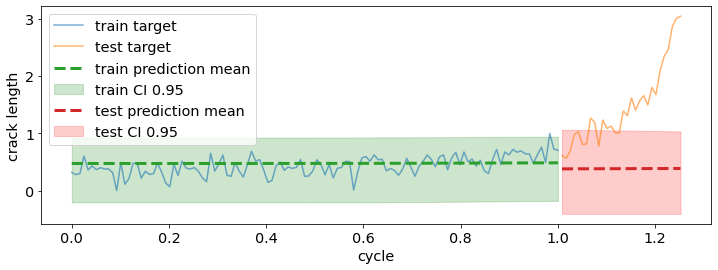

In [ ]:
%%time

model_mmd = GaussianNetworkMMD(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    likelihood_std=1,
    activation=nn.Tanh,
)

epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model_mmd.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn_mmd(
    model_mmd,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
    optim=optim,
    sample_size=10,
    divergence_coeff=1e-6,
)

train_predictions = sample_prediction(model_mmd, train_xtensor, sample_size=10)
test_predictions = sample_prediction(
    model_mmd, test_xtensor, test_ytensor, sample_size=10
)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="",
)

# test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
# uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

## Sinkhorn distance

https://dfdazac.github.io/sinkhorn.html

https://simonensemble.github.io/pluto_nbs/emd.jl.html


In [ ]:
# https://github.com/dfdazac/wassdistance/blob/master/layers.py
# Adapted from https://github.com/gpeyre/SinkhornAutoDiff
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """

    def __init__(self, eps, max_iter, reduction="none"):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        # mu = torch.empty(batch_size, x_points, dtype=torch.float,
        #                  requires_grad=False).fill_(1.0 / x_points).squeeze()
        # nu = torch.empty(batch_size, y_points, dtype=torch.float,
        #                  requires_grad=False).fill_(1.0 / y_points).squeeze()
        mu = torch.empty(
            batch_size, x_points, dtype=torch.float, requires_grad=False
        ).fill_(1.0 / x_points)
        nu = torch.empty(
            batch_size, y_points, dtype=torch.float, requires_grad=False
        ).fill_(1.0 / y_points)

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1
        # print(f"{x.shape=}, {y.shape=}")
        # print(f"{C.shape=}, {u.shape=}, {v.shape=}")

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = (
                self.eps
                * (torch.log(mu + 1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1))
                + u
            )
            v = (
                self.eps
                * (
                    torch.log(nu + 1e-8)
                    - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)
                )
                + v
            )
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == "mean":
            cost = cost.mean()
        elif self.reduction == "sum":
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [ ]:
m = 10  # sample size
x_mean = torch.zeros(2) + 1
y_mean = torch.zeros(2)
x_cov = 2 * torch.eye(2)  # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3 * torch.eye(2) - 1

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction="mean")
print(sinkhorn(x, y)[0])

torch.Size([10, 2]) torch.Size([10, 2])
tensor(2.5216)


In [ ]:
m = 10  # sample size
x_mean = torch.zeros(2)
y_mean = torch.zeros(2)
x_cov = 2 * torch.eye(2)  # IMPORTANT: Covariance matrices must be positive definite
y_cov = 2 * torch.eye(2)

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction="mean")
print(sinkhorn(x, y)[0])

torch.Size([10, 2]) torch.Size([10, 2])
tensor(1.9936)


In [ ]:
class GaussianLinearSinkhorn(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior, sinkhorn):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.sinkhorn = sinkhorn

        self.weight_mean = nn.Parameter(weight_prior.sample((inputsize, outputsize)))
        self.weight_logstd = nn.Parameter(weight_prior.sample((inputsize, outputsize)))

        self.bias_mean = nn.Parameter(bias_prior.sample((1, outputsize)))
        self.bias_logstd = nn.Parameter(bias_prior.sample((1, outputsize)))

        self.normal01 = td.Normal(0, 1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(
                inputdata.size()[0], self.outputsize
            )
            return output

        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)
        weight = (
            self.weight_mean
            + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        )
        bias = (
            self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        )

        output = torch.mm(inputdata, weight) + bias.expand(
            inputdata.size()[0], self.outputsize
        )
        # print((1, weight.shape[1], 1))
        # print(weight.shape, bias.shape)
        # distance_weight = self.sinkhorn(weight, self.weight_prior.sample(weight.shape))[0]
        # distance_bias = self.sinkhorn(bias, self.bias_prior.sample(bias.shape))[0]
        reshaped_weight = weight.reshape(-1, 1)
        reshaped_bias = bias.reshape(-1, 1)
        distance_weight = self.sinkhorn(
            reshaped_weight, self.weight_prior.sample(reshaped_weight.shape)
        )[0]
        distance_bias = self.sinkhorn(
            reshaped_bias, self.bias_prior.sample(reshaped_bias.shape)
        )[0]
        return output, distance_weight + distance_bias


class GaussianNetworkSinkhorn(nn.Module):
    def __init__(
        self,
        layer_size,
        weight_prior,
        bias_prior,
        sinkhorn,
        likelihood_std=0.1,
        activation=nn.Tanh,
        need_output_exp=False,
    ):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.sinkhorn = sinkhorn

        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(
                GaussianLinearSinkhorn(
                    layer_size[i], layer_size[i + 1], weight_prior, bias_prior, sinkhorn
                )
            )
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers,
            GaussianLinearSinkhorn(
                layer_size[-2], layer_size[-1], weight_prior, bias_prior, sinkhorn
            )
        )
        self.distance = 0

    def forward(self, indata, need_sample=True):
        outdata = indata
        self.distance = 0
        for layer in self.layers:
            if isinstance(layer, GaussianLinearSinkhorn):
                outdata, distance = layer(outdata, need_sample)
                self.distance += distance
            else:
                outdata = layer(outdata)

        if self.need_output_exp:
            outdata = torch.exp(outdata)

        return outdata, self.distance

    def forward_sample(inputdata, targetdata, sample_size=10):
        predictions = []
        for samplecount in range(sample_size):
            prediction, distance = self.forward(inputdata)
            predictions.append(prediction)

        return torch.stack(predictions, dim=0)


model_sinkhorn = GaussianNetworkSinkhorn(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    sinkhorn=SinkhornDistance(eps=0.1, max_iter=100, reduction="mean"),
    likelihood_std=1,
    activation=nn.Tanh,
)
model_sinkhorn(torch.randn(2, 1))

(tensor([[5.1921],
         [5.1921]], grad_fn=<AddBackward0>),
 tensor(48.8538, grad_fn=<AddBackward0>))

In [ ]:
def compute_data_physics_loss_gaussian_nn_sinkhorn(
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    inputdata,
    targetdata,
    inputphysics,
    inputscaler,
    outputscaler,
    physics_coeff,
    sample_size=10,
):

    (
        data_distance,
        physics_distance,
        data_samples_loglikelihood,
        physics_samples_loglikelihood,
    ) = (0.0, 0.0, 0.0, 0.0)
    inputphysics.requires_grad_(True)

    for samplecount in range(sample_size):
        # same sample for data and physics ?
        data_output = model.forward(inputdata)
        physics_output = model.forward(inputphysics)
        physics_constraint = 1 * paris_law(
            outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma
        )
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")

        data_distance += data_output[1]
        physics_distance += physics_output[1]

        derivative = torch.autograd.grad(
            outputs=physics_output[0],
            inputs=inputphysics,
            grad_outputs=torch.ones_like(inputphysics),
            retain_graph=True,
            create_graph=True,
        )[0]
        rescaled_derivative = (
            derivative
            * (outputscaler.max - outputscaler.min)
            / (inputscaler.max - inputscaler.min)
        )

        differential_norm = torch.abs(rescaled_derivative) + torch.abs(
            physics_constraint
        )
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")

        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(data_prediction, targetdata, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(rescaled_derivative, physics_constraint, model.likelihood_std).mean()

        data_samples_loglikelihood += log_gaussian(
            data_output[0] / torch.sqrt(data_norm),
            targetdata / torch.sqrt(data_norm),
            model.likelihood_std,
        ).mean()
        physics_samples_loglikelihood += log_gaussian(
            rescaled_derivative / torch.sqrt(differential_norm),
            physics_constraint / torch.sqrt(differential_norm),
            model.likelihood_std,
        ).mean()
    #         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")

    # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
    # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)

    return (
        data_distance / sample_size,
        physics_distance / sample_size,
        data_samples_loglikelihood / sample_size,
        physics_samples_loglikelihood / sample_size,
    )

In [ ]:
def train_model_physics_magnitude_norm_gaussian_nn_sinkhorn(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=5,
    physics_coeff=1,
    optim=None,
    verbose=True,
    sample_size=10,
    divergence_coeff=1,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {
        key: np.empty(epochs)
        for key in "data_loglikelihood physics_loglikelihood data_distance physics_distance".split()
    }
    model.train()

    for epoch in range(epochs):
        loss = torch.zeros(1)

        (
            data_distance,
            physics_distance,
            data_loglikelihood,
            physics_loglikelihood,
        ) = compute_data_physics_loss_gaussian_nn_sinkhorn(
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
            physics_coeff=physics_coeff,
            sample_size=sample_size,
        )

        loss = divergence_coeff * (data_distance + physics_distance) - (
            data_loglikelihood + physics_loglikelihood
        )

        optim.zero_grad()
        loss.backward()
        optim.step()
        #         scheduler.step(loss)

        metric["data_loglikelihood"][epoch] = data_loglikelihood.item()
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood.item()
        metric["data_distance"][epoch] = data_distance.item()
        metric["physics_distance"][epoch] = physics_distance.item()

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}")
            print(
                f" scaled distance = {divergence_coeff * (data_distance + physics_distance)} ; {divergence_coeff * data_distance = } ; {divergence_coeff * physics_distance = }"
            )
            print(
                f"log likelihood = {data_loglikelihood + physics_loglikelihood} ; {data_loglikelihood = } {physics_loglikelihood = }"
            )

    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)

    return metric


 Epoch 1 loss = 7.507185935974121
 scaled distance = 0.419712096452713 ; divergence_coeff * data_distance = tensor(0.3281, grad_fn=<MulBackward0>) ; divergence_coeff * physics_distance = tensor(0.0916, grad_fn=<MulBackward0>)
log likelihood = -7.0874738693237305 ; data_loglikelihood = tensor(-6.1635, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9239, grad_fn=<DivBackward0>)

 Epoch 101 loss = 3.922855854034424
 scaled distance = 0.27987000346183777 ; divergence_coeff * data_distance = tensor(0.1867, grad_fn=<MulBackward0>) ; divergence_coeff * physics_distance = tensor(0.0932, grad_fn=<MulBackward0>)
log likelihood = -3.6429858207702637 ; data_loglikelihood = tensor(-2.7191, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9239, grad_fn=<DivBackward0>)

 Epoch 201 loss = 2.5506439208984375
 scaled distance = 0.23733410239219666 ; divergence_coeff * data_distance = tensor(0.0870, grad_fn=<MulBackward0>) ; divergence_coeff * physics_distance = tensor(0.1503, grad_f

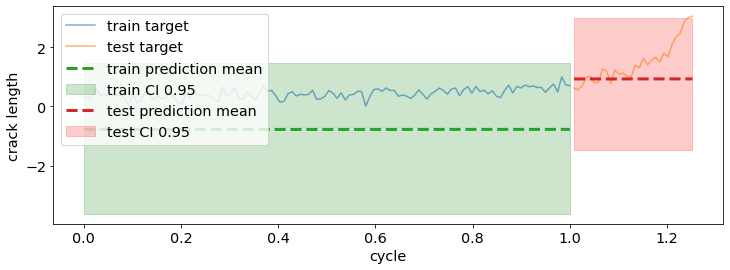

In [ ]:
%%time

model_sinkhorn = GaussianNetworkSinkhorn(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    sinkhorn=SinkhornDistance(eps=0.1, max_iter=10, reduction="mean"),
    likelihood_std=1,
    activation=nn.Tanh,
)

epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model_sinkhorn.parameters(), lr=1e-2, weight_decay=1e-6)
metric_sinkhorn = train_model_physics_magnitude_norm_gaussian_nn_sinkhorn(
    model_sinkhorn,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
    optim=optim,
    sample_size=10,
    divergence_coeff=1e-3,
)

train_predictions = sample_prediction(model_sinkhorn, train_xtensor, sample_size=10)
test_predictions = sample_prediction(
    model_sinkhorn, test_xtensor, test_ytensor, sample_size=10
)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="",
)

# test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
# uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

## Evidential Regression

\begin{align}
y_1, ..., y_n \sim \mathcal N (\mu, \sigma^2) \\
\mu \sim \mathcal N (\gamma, \sigma^2 / v) \\
\sigma^2 \sim \Gamma^{-1} (\alpha, \beta) \\
p(\mu, \sigma^2) \approx p(\mu | \gamma, v) p(\sigma^2 | \alpha, \beta) \\
\theta = (\mu, \sigma^2) ; m = (\gamma, v, \alpha, \beta) 
\\
p(y_i | m ) = \frac {p(y_i | \theta, m) p(\theta | m)} {p(\theta | y_i, m)} = \int_\mu \int_{\sigma^2} p(y_i | \mu, \sigma^2) p(\mu, \sigma^2 | m)\ d\mu\ d\sigma^2 \\
p(y_i | m ) = \text{Student-t}(y_i; \gamma, \frac {\beta (1+v)}{v \alpha}, 2\alpha) 
\\
L^{NLL}_i = ln\ p(y_i | m) = \log (\text{Student-t}(y_i; \gamma, \frac {\beta (1+v)}{v \alpha}, 2\alpha)) \\
L_i^{NLL} = \frac 1 2 \log(\frac \pi v) - \alpha \log(\Omega) + (\alpha + \frac 1 2) \log ((y - \gamma)^2v + \Omega) + \log (\frac {\Gamma(\alpha)} {\Gamma(\alpha + \frac 1 2)}) \\
\Omega = 2 \beta (1+v)
\\
L^{R}_i = \underbrace{|y_i - E[\mu_i]|}_{\text{prediction error}} \overbrace{(2v + \alpha)}^{\text{evidence or confidence}} \\
L_i = L^{NLL}_i + \lambda L^R_i
\end{align}

https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf

https://github.com/deebuls/deep_evidential_regression_loss_pytorch


In [ ]:
def predict_evidential(model, indata):
    outdata = model(indata).detach()
    gamma = outdata[:, 0].view(-1)  # first column is mu,delta, predicted value
    alpha = outdata[:, 1].view(-1) + 1.0  # alpha
    beta = outdata[:, 2].view(-1) + 0.1  # beta
    v = outdata[:, 3].view(-1) + 1.0  # v

    # a = torch.exp(a); b = torch.exp(b); l = torch.exp(l)
    aleatoric = beta / (alpha - 1)  # aleatoric uncertainty/ data uncertainty
    epistemic = aleatoric / v  # epistemic/ model/prediciton uncertaitnty

    return gamma, aleatoric, epistemic

In [ ]:
def predict_evidential1(model, indata):
    outdata = model(indata).detach()
    gamma = outdata[:, 0]
    v = outdata[:, 1]
    alpha = outdata[:, 2]
    beta = outdata[:, 3]

    # a = torch.exp(a); b = torch.exp(b); l = torch.exp(l)
    aleatoric = beta / (alpha - 1)  # aleatoric uncertainty/ data uncertainty
    epistemic = aleatoric / v  # epistemic/ model/prediciton uncertaitnty

    return gamma, aleatoric, epistemic

In [ ]:
def plot_target_prediction_evidential(
    traininput,
    traintarget,
    testinput,
    testtarget,
    train_mean,
    train_aleatoric,
    train_epistemic,
    test_mean,
    test_aleatoric,
    test_epistemic,
    title=None,
    figsize=(12, 4),
    marker=None,
):

    fig = plt.figure(figsize=figsize)
    plt.plot(
        traininput, traintarget, label="train target", marker=marker, linestyle="-"
    )
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-")

    plt.plot(
        traininput, train_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3
    )
    plt.plot(
        testinput, test_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3
    )
    plt.fill_between(
        traininput.squeeze(),
        (train_mean - 2 * np.sqrt(train_aleatoric)).squeeze(),
        (train_mean + 2 * np.sqrt(train_aleatoric)).squeeze(),
        # color="gray",
        label='train aleatoric',
        alpha=0.4,
    )
    plt.fill_between(
        testinput.squeeze(),
        (test_mean - 2 * np.sqrt(test_aleatoric)).squeeze(),
        (test_mean + 2 * np.sqrt(test_aleatoric)).squeeze(),
        # color="gray",
        label='test aleatoric',
        alpha=0.4,
    )
    plt.fill_between(
        traininput.squeeze(),
        (train_mean - 2 * np.sqrt(train_epistemic)).squeeze(),
        (train_mean + 2 * np.sqrt(train_epistemic)).squeeze(),
        # color="gray",
        label='train epistemic',
        alpha=0.4,
    )
    plt.fill_between(
        testinput.squeeze(),
        (test_mean - 2 * np.sqrt(test_epistemic)).squeeze(),
        (test_mean + 2 * np.sqrt(test_epistemic)).squeeze(),
        # color="gray",
        label='test epistemic',
        alpha=0.4,
    )

    if title:
        plt.title(title)
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig


# fig = plot_target_prediction_evidential(train_xtensor, train_ytensor, test_xtensor, test_ytensor,
#     train_mean, train_aleatoric, train_epistemic, test_mean, test_aleatoric, test_epistemic)

In [ ]:
class FullyConnectedEvidential(nn.Module):
    "Defines a fully connected neural network"

    def __init__(self, layer_size, activation=nn.Tanh):
        super().__init__()
        layers = []

        for i in range(len(layer_size) - 1):
            layers.append(nn.Linear(layer_size[i], layer_size[i + 1]))
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-1], 4)
        )
        
        # self.head1 = nn.Linear(layer_size[-1], 1) # mean gamma
        # self.head3 = nn.Linear(layer_size[-1], 3) # v, alpha, beta

    def forward(self, indata):
        outdata = self.layers(indata)
        # print(outdata.shape)
        gamma, v, alpha, beta = torch.tensor_split(outdata, 4, dim=1)
        # v, beta > 0 ; alpha > 1
        v_positive = torch.exp(v)
        alpha_plus1 = torch.exp(alpha) + 1
        beta_positive = torch.exp(beta)

        return torch.hstack((gamma, v_positive, alpha_plus1, beta_positive))


model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
model_evidential(torch.randn(2, 1))

tensor([[-0.0652,  1.1801,  2.3342,  0.9459],
        [-0.3621,  0.9586,  2.4066,  0.9748]], grad_fn=<CatBackward0>)

In [ ]:
t1 = torch.arange(8).reshape((2, 4))
t2 = torch.tensor_split(t1, 4, dim=1)
print(t1, t2)


tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]]) (tensor([[0],
        [4]]), tensor([[1],
        [5]]), tensor([[2],
        [6]]), tensor([[3],
        [7]]))


In [ ]:
class EvidentialLossSumOfSquares(nn.Module):
    """The evidential loss function on a matrix.
    This class is implemented with slight modifications from the paper. The major
    change is in the regularizer parameter mentioned in the paper. The regularizer
    mentioned in the paper didnot give the required results, so we modified it
    with the KL divergence regularizer from the paper. In orderto overcome the problem
    that KL divergence are missing near zero so we add the minimum values to alpha,
    beta and lambda and compare distance with NIG(alpha=1.0, beta=0.1, lambda=1.0)
    This class only allows for rank-4 inputs for the output `targets`, and expectes
    `inputs` be of the form [mu, alpha, beta, lambda]
    alpha, beta and lambda needs to be positive values.
    """

    def __init__(self, regularize_coeff=1e-3, debug=False, return_all=False):
        """Sets up loss function.
        Args:
          debug: When set to 'true' prints all the intermittent values
          return_all: When set to 'true' returns all loss values without taking average
        """
        super(EvidentialLossSumOfSquares, self).__init__()

        self.debug = debug
        self.return_all_values = return_all
        # Max you can go is 85 because exp(86) is nan  Now exp(5.0) is 143 which is max of a,b and l
        self.MAX_CLAMP_VALUE = 5.0
        self.regularize_coeff = regularize_coeff

    def kl_divergence_nig(self, mu1, mu2, alpha_1, beta_1, lambda_1):
        alpha_2 = torch.ones_like(mu1) * 1.0
        beta_2 = torch.ones_like(mu1) * 0.1
        lambda_2 = torch.ones_like(mu1) * 1.0

        t1 = 0.5 * (alpha_1 / beta_1) * ((mu1 - mu2) ** 2) * lambda_2
        # t1 = 0.5 * (alpha_1/beta_1) * (torch.abs(mu1 - mu2))  * lambda_2
        t2 = 0.5 * lambda_2 / lambda_1
        t3 = alpha_2 * torch.log(beta_1 / beta_2)
        t4 = -torch.lgamma(alpha_1) + torch.lgamma(alpha_2)
        t5 = (alpha_1 - alpha_2) * torch.digamma(alpha_1)
        t6 = -(beta_1 - beta_2) * (alpha_1 / beta_1)
        return t1 + t2 - 0.5 + t3 + t4 + t5 + t6

    def forward(self, inputs, targets):
        """Implements the loss function
        Args:
          inputs: The output of the neural network. inputs has 4 dimension
            in the format [mu, alpha, beta, lambda]. Must be a tensor of
            floats
          targets: The expected output
        Returns:
          Based on the `return_all` it will return mean loss of batch or individual loss
        """
        assert torch.is_tensor(inputs)
        assert torch.is_tensor(targets)
        assert (inputs[:, 1] > 0).all()
        assert (inputs[:, 2] > 0).all()
        assert (inputs[:, 3] > 0).all()

        # targets = targets.view(-1)
        # y = inputs[:,0].view(-1) #first column is mu,delta, predicted value
        # a = inputs[:,1].view(-1) + 1.0 #alpha
        # b = inputs[:,2].view(-1) + 0.1 #beta to avoid zero
        # l = inputs[:,3].view(-1) + 1.0 #lamda

        y = inputs[:, 0]  # first column is mu,delta, predicted value
        a = inputs[:, 1] + 1.0  # alpha
        b = inputs[:, 2] + 0.1  # beta to avoid zero
        l = inputs[:, 3] + 1.0  # lamda

        if self.debug:
            print("a :", a)
            print("b :", b)
            print("l :", l)

        J1 = torch.lgamma(a - 0.5)
        J2 = -torch.log(torch.tensor([4.0]))
        J3 = -torch.lgamma(a)
        J4 = -torch.log(l)
        J5 = -0.5 * torch.log(b)
        J6 = torch.log(2 * b * (1 + l) + (2 * a - 1) * l * (y - targets) ** 2)

        if self.debug:
            print("lgama(a - 0.5) :", J1)
            print("log(4):", J2)
            print("lgama(a) :", J3)
            print("log(l) :", J4)
            print("log( ---- ) :", J6)

        J = J1 + J2 + J3 + J4 + J5 + J6
        # Kl_divergence = torch.abs(y - targets) * (2*a + l)/b ######## ?????
        # Kl_divergence = ((y - targets)**2) * (2*a + l)
        # Kl_divergence = torch.abs(y - targets) * (2*a + l)
        # Kl_divergence = 0.0
        # Kl_divergence = (torch.abs(y - targets) * (a-1) *  l)/b
        Kl_divergence = self.kl_divergence_nig(y, targets, a, b, l)

        if self.debug:
            print("KL ", Kl_divergence.data.numpy())
        loss = torch.exp(J) + self.regularize_coeff * Kl_divergence

        if self.debug:
            print("loss :", loss.mean())

        if self.return_all_values:
            ret_loss = loss
        else:
            ret_loss = loss.mean()
        # if torch.isnan(ret_loss):
        #  ret_loss.item() = self.prev_loss + 10
        # else:
        #  self.prev_loss = ret_loss.item()

        return ret_loss

In [ ]:
class PaperEvidentialLossSumOfSquares(nn.Module):
    """The evidential loss function on a matrix.
    This class is implemented same as the paper.
    This class only allows for rank-4 inputs for the output `targets`, and expectes
    `inputs` be of the form [mu, alpha, beta, lambda]
    alpha, beta and lambda needs to be positive values.
    """

    def __init__(self, regularize_coeff=1e-3, debug=False, return_all=False):
        """Sets up loss function.
        Args:
          debug: When set to 'true' prints all the intermittent values
          return_all: When set to 'true' returns all loss values without taking average
        """
        super(PaperEvidentialLossSumOfSquares, self).__init__()

        self.debug = debug
        self.return_all_values = return_all
        self.MAX_CLAMP_VALUE = 5.0  # Max you can go is 85 because exp(86) is nan  Now exp(5.0) is 143 which is max of a,b and l
        self.regularize_coeff = regularize_coeff
        self.debug_dict={}

    def forward(self, inputs, targets):
        """Implements the loss function
        Args:
          inputs: The output of the neural network. inputs has 4 dimension
            in the format [mu, alpha, beta, lambda]. Must be a tensor of
            floats
          targets: The expected output
        Returns:
          Based on the `return_all` it will return mean loss of batch or individual loss
        """
        assert torch.is_tensor(inputs)
        assert torch.is_tensor(targets)
        assert (inputs[:, 1] > 0).all()
        assert (inputs[:, 2] > 0).all()
        assert (inputs[:, 3] > 0).all()

        targets = targets.view(-1)
        y = inputs[:, 0].view(-1)  # first column is mu,delta, predicted value
        a = inputs[:, 1].view(-1)  # alpha
        b = inputs[:, 2].view(-1)  # beta to avoid zero
        l = inputs[:, 3].view(-1)  # lamda

        if self.debug:
            print("a :", a)
            print("b :", b)
            print("l :", l)

        # machine epsilon for safe cases
        machine_epsilon = torch.tensor(np.finfo(np.float32).eps)
        safe_a = torch.max(machine_epsilon, a)
        safe_b = torch.max(machine_epsilon, b)
        safe_l = torch.max(machine_epsilon, l)
        J1 = torch.lgamma(torch.max(a - 0.5))
        J2 = -torch.log(torch.tensor([4.0]))
        J3 = -torch.lgamma(safe_a)
        J4 = -torch.log(safe_l)
        J5 = -0.5 * torch.log(safe_b)
        J6 = torch.log(
            torch.max(
                machine_epsilon, 2 * b * (1 + l) + (2 * a - 1) * l * (y - targets) ** 2
            )
        )

        if self.debug:
            print("lgama(a - 0.5) :", J1)
            print("log(4):", J2)
            print("lgama(a) :", J3)
            print("log(l) :", J4)
            print("log( ---- ) :", J6)

        J = J1 + J2 + J3 + J4 + J5 + J6
        Kl_divergence = torch.abs(y - targets) * (2 * safe_a + safe_l)  ######## ?????
        # Kl_divergence = ((y - targets)**2) * (2*safe_a + safe_l)
        # Kl_divergence = torch.abs(y - targets) * (2*a + l)
        # Kl_divergence = 0.0
        # Kl_divergence = (torch.abs(y - targets) * (a-1) *  l)/b
        # Kl_divergence = torch.norm(y - targets)*(2*safe_a + safe_l)

        if self.debug:
            print("KL ", Kl_divergence.data.numpy())
        loss = torch.exp(J) + self.regularize_coeff * Kl_divergence

        if self.debug:
            print("loss :", loss.mean())

        if self.return_all_values:
            ret_loss = loss
        else:
            ret_loss = loss.mean()
        # if torch.isnan(ret_loss):
        #  ret_loss.item() = self.prev_loss + 10
        # else:
        #  self.prev_loss = ret_loss.item()
        self.debug_dict['likelihood'] = torch.exp(J.detach()).mean()
        self.debug_dict['regularizer'] = torch.mean(self.regularize_coeff * Kl_divergence.detach())

        return ret_loss

In [ ]:
# https://github.com/deebuls/deep_evidential_regression_loss_pytorch


class PaperEvidentialLossSumOfSquares1(nn.Module):
    """The evidential loss function on a matrix.
    This class is implemented same as the paper.
    This class only allows for rank-4 inputs for the output `targets`, and expectes
    `inputs` be of the form [mu, alpha, beta, lambda]
    alpha, beta and lambda needs to be positive values.
    """

    def __init__(self, regularize_coeff=1e-3, need_reduced_loss=True):
        """Sets up loss function.
        Args:
          debug: When set to 'true' prints all the intermittent values
          reduce_loss: When set to 'false' returns all loss values without taking average
        """
        super().__init__()

        self.need_reduced_loss = need_reduced_loss
        # Max you can go is 85 because exp(86) is nan  Now exp(5.0) is 143 which is max of a,b and l
        self.MAX_CLAMP_VALUE = 5.0
        self.regularize_coeff = regularize_coeff
        self.debug_dict={}

    def forward(self, inputs, targets):
        """Implements the loss function
        Args:
          inputs: The output of the neural network. inputs has 4 dimension
            in the format [mu, alpha, beta, lambda]. Must be a tensor of
            floats
          targets: The expected output
        Returns:
          Based on the `return_all` it will return mean loss of batch or individual loss
        """
        # assert torch.is_tensor(inputs)
        # assert torch.is_tensor(targets)
        assert (inputs[:, 1] > 0).all()
        assert (inputs[:, 2] > 0).all()
        assert (inputs[:, 3] > 0).all()

        # targets = targets.view(-1)
        gamma = inputs[:, 0]
        v = inputs[:, 1]
        alpha = inputs[:, 2]
        beta = inputs[:, 3]
        # print(gamma.shape, v.shape, alpha.shape, beta.shape)

        # machine epsilon for safe cases
        # machine_epsilon = torch.tensor(np.finfo(np.float32).eps)
        # safe_a = torch.max(machine_epsilon, a)
        # safe_b = torch.max(machine_epsilon, b)
        # safe_l = torch.max(machine_epsilon, l)
        Omega = 2 * beta * (1 + v)
        likelihood1 = 0.5 * torch.log(np.pi/v)
        likelihood2 = -alpha * torch.log(Omega)
        likelihood3 = (alpha + 0.5) * torch.log((gamma - targets)**2 * v + Omega)
        likelihood4 = torch.lgamma(alpha) - torch.lgamma(alpha + 0.5)

        likelihood = likelihood1 + likelihood2 + likelihood3 + likelihood4
        regularizer = torch.abs(gamma - targets) * (2 * v + alpha)

        loss = likelihood + self.regularize_coeff * regularizer
        
        self.debug_dict['likelihood'] = likelihood.detach().mean()
        self.debug_dict['regularizer'] = torch.mean(self.regularize_coeff * regularizer.detach())

        return loss.mean() if self.need_reduced_loss else loss


In [ ]:
def compute_data_physics_loss_evidential(
    loss_func,
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    inputdata,
    targetdata,
    inputphysics,
    inputscaler,
    outputscaler,
):

    # data_samples_loss, physics_samples_loss = 0.0, 0.0
    inputphysics.requires_grad_(True)

    # for samplecount in range(sample_size):
    # same sample for data and physics ?
    data_output = model.forward(inputdata)
    physics_output = model.forward(inputphysics)
    physics_constraint = 1 * paris_law(
        outputscaler.inverse(physics_output[:, 0]), paris_C, paris_m, paris_dsigma
    )
    # print(f"{data_output.shape = } \n {physics_output.shape = } \n {physics_constraint.shape = }")
    # .reshape(-1, 1)
    derivative = torch.autograd.grad(
        outputs=physics_output[:, 0],
        inputs=inputphysics,
        grad_outputs=torch.ones_like(physics_output[:, 0]),
        retain_graph=True,
        create_graph=True,
    )[0]
    rescaled_derivative = (
        derivative
        * (outputscaler.max - outputscaler.min)
        / (inputscaler.max - inputscaler.min)
    )

    differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(targetdata**2)
    # print(f"{data_norm = } {differential_norm = }")

    # print(f"{(data_output[:, 0]/torch.sqrt(data_norm)).shape, data_output[:, 1:].shape = }")
    data_loss = loss_func(
        torch.hstack(
            (
                data_output[:, 0].reshape(-1, 1) / torch.sqrt(data_norm),
                data_output[:, 1:],
            )
        ),
        targetdata / torch.sqrt(data_norm),
    )
    physics_loss = loss_func(
        torch.hstack(
            (rescaled_derivative / torch.sqrt(differential_norm), physics_output[:, 1:])
        ),
        physics_constraint / torch.sqrt(differential_norm),
    )
    loss_func.debug_dict['data_norm'] = data_norm
    loss_func.debug_dict['differential_norm'] = differential_norm

    return data_loss, physics_loss

In [ ]:
def train_model_physics_magnitude_norm_evidential(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    loss_func,
    epochs=5,
    optim=None,
    verbose=True,
    # regularize_coeff=1e-3,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {
        key: np.empty(epochs)
        for key in "data_loss physics_loss".split()
    }
    model.train()

    for epoch in range(epochs):
        # loss = torch.zeros(1)

        data_loss, physics_loss = compute_data_physics_loss_evidential(
            loss_func,
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
        )

        loss = data_loss + physics_loss

        optim.zero_grad()
        loss.backward()
        optim.step()
        #         scheduler.step(loss)

        metric["data_loss"][epoch] = data_loss.detach().item()
        metric["physics_loss"][epoch] = physics_loss.detach().item()
        # metric["logprior"][epoch] = logprior
        # metric["logproposal"][epoch] = logproposal

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}")
            print(f"{data_loss = } {physics_loss = }")
            print(f"{loss_func.debug_dict['likelihood']=} ; {loss_func.debug_dict['regularizer']=}")
            print(f"{loss_func.debug_dict['data_norm']=} ; {loss_func.debug_dict['differential_norm']=}")

    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)

    return metric


 Epoch 1 loss = 2.3633151054382324
data_loss = tensor(1.1871, grad_fn=<MeanBackward0>) physics_loss = tensor(1.1762, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(1.1762) ; loss_func.debug_dict['regularizer']=tensor(4.4986e-09)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(1.3023e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = -4.939460754394531
data_loss = tensor(-1.6306, grad_fn=<MeanBackward0>) physics_loss = tensor(-3.3088, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(-3.3088) ; loss_func.debug_dict['regularizer']=tensor(2.6880e-08)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(8.9436e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = -5.219135284423828
data_loss = tensor(-1.5119, grad_fn=<MeanBackward0>) physics_loss = tensor(-3.7072, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(-3.7072) ; loss_func.debug_dic

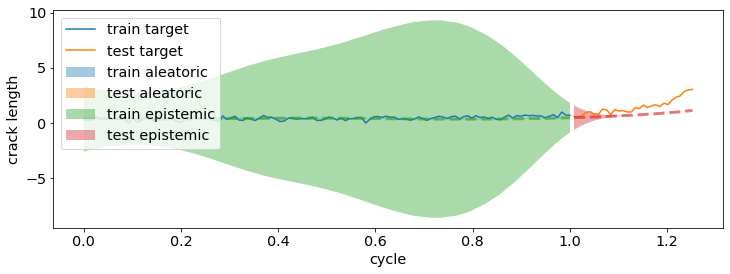

In [ ]:
%%time

model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
optim = torch.optim.Adam(model_evidential.parameters(), lr=1e-2, weight_decay=1e-6)
epochs = 20000

loss_func = PaperEvidentialLossSumOfSquares1(regularize_coeff=1e-7)
predict_func = predict_evidential1

metric = train_model_physics_magnitude_norm_evidential(
    model_evidential,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    loss_func,
    epochs=epochs,
    optim=optim,
    verbose=True,
)

train_mean, train_aleatoric, train_epistemic = predict_func(
    model_evidential, train_xtensor
)
test_mean, test_aleatoric, test_epistemic = predict_func(
    model_evidential, test_xtensor
)

fig = plot_target_prediction_evidential(
    train_xtensor,
    train_ytensor,
    test_xtensor,
    test_ytensor,
    train_mean,
    train_aleatoric,
    train_epistemic,
    test_mean,
    test_aleatoric,
    test_epistemic,
)


 Epoch 1 loss = 1.6493160724639893
data_loss = tensor(0.8291, grad_fn=<MeanBackward0>) physics_loss = tensor(0.8202, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(0.8201) ; loss_func.debug_dict['regularizer']=tensor(3.6998e-05)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(6.8698e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = -4.716060638427734
data_loss = tensor(-1.8382, grad_fn=<MeanBackward0>) physics_loss = tensor(-2.8779, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(-2.8780) ; loss_func.debug_dict['regularizer']=tensor(0.0001)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(2.8992e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = -5.144881248474121
data_loss = tensor(-1.5847, grad_fn=<MeanBackward0>) physics_loss = tensor(-3.5602, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(-3.5602) ; loss_func.debug_dict['r

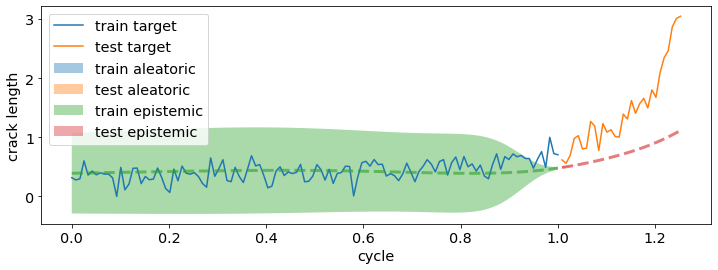

In [ ]:
%%time

model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
optim = torch.optim.Adam(model_evidential.parameters(), lr=1e-2, weight_decay=1e-6)
epochs = 20000

loss_func = PaperEvidentialLossSumOfSquares1(regularize_coeff=1e-3)
predict_func = predict_evidential1

metric = train_model_physics_magnitude_norm_evidential(
    model_evidential,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    loss_func,
    epochs=epochs,
    optim=optim,
    verbose=True,
)

train_mean, train_aleatoric, train_epistemic = predict_func(
    model_evidential, train_xtensor
)
test_mean, test_aleatoric, test_epistemic = predict_func(
    model_evidential, test_xtensor
)

fig = plot_target_prediction_evidential(
    train_xtensor,
    train_ytensor,
    test_xtensor,
    test_ytensor,
    train_mean,
    train_aleatoric,
    train_epistemic,
    test_mean,
    test_aleatoric,
    test_epistemic,
)


 Epoch 1 loss = 2.3222174644470215
data_loss = tensor(1.1649, grad_fn=<MeanBackward0>) physics_loss = tensor(1.1573, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(1.1573) ; loss_func.debug_dict['regularizer']=tensor(3.1692e-07)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(7.7927e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = -4.7797746658325195
data_loss = tensor(-1.7761, grad_fn=<MeanBackward0>) physics_loss = tensor(-3.0037, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(-3.0037) ; loss_func.debug_dict['regularizer']=tensor(3.7801e-06)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(3.9552e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = -5.602110862731934
data_loss = tensor(-1.5417, grad_fn=<MeanBackward0>) physics_loss = tensor(-4.0604, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(-4.0604) ; loss_func.debug_di

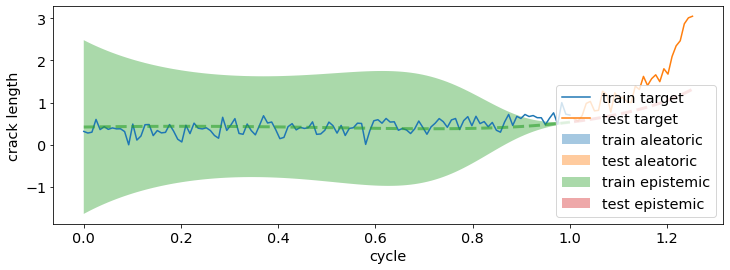

In [ ]:
%%time

model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
optim = torch.optim.Adam(model_evidential.parameters(), lr=1e-2, weight_decay=1e-6)
epochs = 20000

loss_func = PaperEvidentialLossSumOfSquares1(regularize_coeff=1e-5)
predict_func = predict_evidential1

metric = train_model_physics_magnitude_norm_evidential(
    model_evidential,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    loss_func,
    epochs=epochs,
    optim=optim,
    verbose=True,
)

train_mean, train_aleatoric, train_epistemic = predict_func(
    model_evidential, train_xtensor
)
test_mean, test_aleatoric, test_epistemic = predict_func(
    model_evidential, test_xtensor
)

fig = plot_target_prediction_evidential(
    train_xtensor,
    train_ytensor,
    test_xtensor,
    test_ytensor,
    train_mean,
    train_aleatoric,
    train_epistemic,
    test_mean,
    test_aleatoric,
    test_epistemic,
)

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

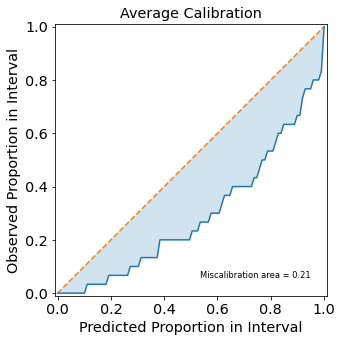

In [ ]:
uct.viz.plot_calibration(
    test_mean.numpy(), np.sqrt(test_aleatoric.numpy()), test_ytensor.numpy().squeeze()
)


 Epoch 1 loss = 4.314446449279785
data_loss = tensor(2.1590, grad_fn=<MeanBackward0>) physics_loss = tensor(2.1555, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(2.1552) ; loss_func.debug_dict['regularizer']=tensor(0.0002)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(2.4624e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.1723993718624115
data_loss = tensor(0.1048, grad_fn=<MeanBackward0>) physics_loss = tensor(0.0676, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(0.0559) ; loss_func.debug_dict['regularizer']=tensor(0.0118)
loss_func.debug_dict['data_norm']=tensor(26.2073) ; loss_func.debug_dict['differential_norm']=tensor(7.3125e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.1712207794189453
data_loss = tensor(0.1046, grad_fn=<MeanBackward0>) physics_loss = tensor(0.0666, grad_fn=<MeanBackward0>)
loss_func.debug_dict['likelihood']=tensor(0.0548) ; loss_func.debug_dict['regularizer'

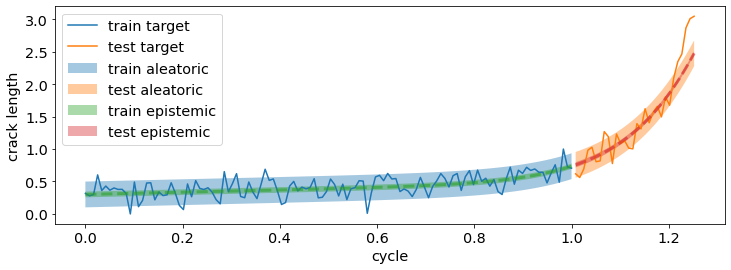

In [ ]:
%%time

model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
optim = torch.optim.Adam(model_evidential.parameters(), lr=1e-2, weight_decay=1e-6)
epochs = 20000

loss_func = PaperEvidentialLossSumOfSquares(regularize_coeff=1e-2)
predict_func = predict_evidential

metric = train_model_physics_magnitude_norm_evidential(
    model_evidential,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    loss_func,
    epochs=epochs,
    optim=optim,
    verbose=True,
)

train_mean, train_aleatoric, train_epistemic = predict_func(
    model_evidential, train_xtensor
)
test_mean, test_aleatoric, test_epistemic = predict_func(
    model_evidential, test_xtensor
)

fig = plot_target_prediction_evidential(
    train_xtensor,
    train_ytensor,
    test_xtensor,
    test_ytensor,
    train_mean,
    train_aleatoric,
    train_epistemic,
    test_mean,
    test_aleatoric,
    test_epistemic,
)

## Stein variational gradient descent

https://github.com/hejj16/Stein-Variational-Gradient-Descent-PyTorch/blob/main/Example_of_SVGD.ipynb

https://github.com/shwangtangjun/SVGD-PyTorch/blob/master/svgd.py

https://github.com/LMikeH/svgd-torch/blob/master/svgd_bnn/svgd.py

https://www.cs.utexas.edu/~lqiang/PDF/svgd_aabi2016.pdf

https://www.cs.utexas.edu/~lqiang/PDF/steinslides16.pdf

https://arxiv.org/pdf/1608.04471/pdf


Initialize ${x_i} \sim q_0$ to approximate p(x). Iterative transform $\phi(x)$ as in Normalizing Flow
\begin{align}
x_i \leftarrow x_i + \epsilon \phi(x_i) \\
\phi = \arg \max_{\phi \in F} -\nabla_\epsilon KL[q_{\epsilon \phi} || p]\ |_{\epsilon=0} 
= \arg \max_{\phi \in F} E_{x \sim q} [T_p \phi(x)]
\end{align}

$q_{\epsilon \phi}$ = density of $x' = x + \epsilon \phi(x)$ \
F = set of functions in Reproducing Kernel Hilbert Space with unit norm \
Stein operator $T_p \phi(x) = \nabla_x \log p(x) ^T \phi(x) + \nabla_x \phi(x)$ \
With positive definite kernel $k(x, x')$, the optimum is Kernelized Stein Discrepancy

\begin{align}
KSD( q || p) = \max_{\phi \in F} E_{x \sim q} [T_p \phi(x)] \\
\phi^*(x') \propto E_{x \sim q} [T_p\ k(x, x')] = E_{x \sim q} [\nabla_x \log p(x) k(x, x') + \nabla_x k(x, x')] \\
x_i \leftarrow x_i + \epsilon \hat E_{x_i} [\underbrace{\nabla_x \log p(x) . k(x, x_i)}_\text{ascent to high probability} + \underbrace{\nabla_x k(x, x_i)}_\text{repulsive diversity}]
\end{align}

$\hat E_{x_i}[.]$ is empirical average approximation with particle set ${x_i}$

For RBF kernel
\begin{align}
k(x, x_i) = exp(-\frac 1 h || x - x_i ||^2 ) \\
\nabla_x k(x, x_i) = \frac 2 h (x - x_i) k(x, x_i)
\end{align}

Repulsive diversity: Add the difference between particles in the update, scaled by similarity. If strong similarity => add the difference times a big multiplier

In [ ]:
t1 = torch.randn((2, 2), requires_grad=True)
t2 = 2 * t1
t3 = 3 * t1
t2.sum().backward(retain_graph=True)
t3.sum().backward(retain_graph=True)
print(t1, t1.grad)
print(torch.autograd.grad(t3.sum(), t1))
print(torch.autograd.grad(t2.sum(), t1))

tensor([[2.0743, 0.4655],
        [1.1987, 0.1172]], requires_grad=True) tensor([[5., 5.],
        [5., 5.]])
(tensor([[3., 3.],
        [3., 3.]]),)
(tensor([[2., 2.],
        [2., 2.]]),)


In [ ]:
# https://github.com/shwangtangjun/SVGD-PyTorch/blob/master/svgd.py

def median(tensor):
    """
    torch.median() acts differently from np.median(). We want to simulate numpy implementation.
    """
    tensor = tensor.detach().flatten()
    tensor_max = tensor.max()[None]
    return (torch.cat((tensor, tensor_max)).median() + tensor.median()) / 2.0


def kernel_rbf(inputs):
    n = inputs.shape[0]
    pairwise_distance = torch.norm(inputs[:, None] - inputs, dim=2).pow(2)
    h = median(pairwise_distance) / math.log(n)
    kernel_matrix = torch.exp(-pairwise_distance / h)
    return kernel_matrix


def get_gradient(model, inputs):
    n = inputs.size(0)
    inputs = inputs.detach().requires_grad_(True)

    log_prob = model.log_prob(inputs)
    log_prob_grad = torch.autograd.grad(log_prob.sum(), inputs)[0]

    # See https://github.com/activatedgeek/svgd/issues/1#issuecomment-649235844 for why there is a factor -0.5
    kernel = kernel_rbf(inputs)
    kernel_grad = -0.5 * torch.autograd.grad(kernel.sum(), inputs)[0]

    gradient = -(kernel.mm(log_prob_grad) + kernel_grad) / n

    return gradient

In [ ]:
# https://github.com/hejj16/Stein-Variational-Gradient-Descent-PyTorch/blob/main/Example_of_SVGD.ipynb

class SVGD:
    def __init__(self, n_particles, n_dim):
        """
        :param n_particles: int
        :param n_dim: int
        """
        self.n_particles = n_particles
        self.particles = torch.randn(self.n_particles, n_dim) * 5

    def step(self, target_distribution_logprob, kernel, learning_rate=0.1):
        """
        :param target_distribution_logprob: pytorch/pyro callable, return log_prob for each input x
        :param kernel: pytorch callable, need to be able to broadcast for one input
        :param learning_rate: float
        :return: None
        """

        def dlog():
            particles = self.particles.clone().detach()
            particles.requires_grad_()
            torch.sum(
                target_distribution_logprob(particles)
            ).backward()  # Because sum is linear
            return particles.grad

        def dkernel(x):
            particles = self.particles.clone().detach()
            particles.requires_grad_()
            torch.sum(kernel(particles, x)).backward()
            return particles.grad

        def phi(x):
            return torch.mean(
                kernel(self.particles, x).reshape(-1, 1) * dlog() + dkernel(x), dim=0
            )

        phis = torch.stack(
            [phi(self.particles[i, :]) for i in range(self.n_particles)], dim=0
        )
        self.particles = self.particles + learning_rate * phis

        return self.particles

In [ ]:
# https://sanyamkapoor.com/kb/the-stein-gradient

class SVGD:
  def __init__(self, P, K, optimizer):
    self.P = P
    self.K = K
    self.optim = optimizer

  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.P.log_prob(X)
    score_func = autograd.grad(log_prob.sum(), X)[0]

    K_XX = self.K(X, X.detach())
    grad_K = -autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()
    

def RBF_kernel(X, Y, sigma=None):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if sigma is None:
      np_dnorm2 = dnorm2.detach().cpu().numpy()
      h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
      sigma = np.sqrt(h).item()

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return K_XY

In [ ]:
t1 = torch.randn((4, 3))#; t2 = torch.randn((3, 3))
print(t1, sep='\n')
print( RBF_kernel(t1, t1), rbf_kernel(t1, t1), kernel_rbf(t1), sep='\n')

tensor([[-1.2643, -0.3988,  0.5479],
        [ 0.2551, -1.0421,  0.4691],
        [-0.0620, -2.0520, -0.1874],
        [ 0.3868, -0.7173, -0.1970]])
tensor([[1.0000, 0.0834, 0.0136, 0.0460],
        [0.0834, 1.0000, 0.2434, 0.5970],
        [0.0136, 0.2434, 1.0000, 0.1643],
        [0.0460, 0.5970, 0.1643, 1.0000]])
tensor(1.)
tensor([[1.0000, 0.1176, 0.0247, 0.0704],
        [0.1176, 1.0000, 0.2961, 0.6412],
        [0.0247, 0.2961, 1.0000, 0.2111],
        [0.0704, 0.6412, 0.2111, 1.0000]])


In [ ]:
kernel_rbf(torch.stack([t1, t2]))

tensor([[[1.0000e+00, 1.0000e+00, 1.0000e+00],
         [2.5000e-01, 1.1243e-03, 8.0086e-04]],

        [[2.5000e-01, 1.1243e-03, 8.0086e-04],
         [1.0000e+00, 1.0000e+00, 1.0000e+00]]])

In [ ]:
def dlikelihood(initial_particles, target_distribution_logprob):
    particles = initial_particles.clone().detach()
    particles.requires_grad_()
    torch.sum(
        target_distribution_logprob(particles)
    ).backward()  # Because sum is linear
    return particles.grad


def dkernel(x, initial_particles, kernel):
    particles = initial_particles.clone().detach()
    particles.requires_grad_()
    torch.sum(kernel(particles, x)).backward()
    return particles.grad


def update_particles(particles, target_distribution_logprob, kernel, learning_rate=0.1):
    """
    :param target_distribution_logprob: pytorch/pyro callable, return log_prob for each input x
    :param kernel: pytorch callable, need to be able to broadcast for one input
    :param learning_rate: float
    :return: None
    """

    def phi(x):
        return torch.mean(
            kernel(particles, x).reshape(-1, 1)
            * dlikelihood(particles, target_distribution_logprob)
            + dkernel(x, particles, kernel),
            dim=0,
        )

    phis = torch.stack([phi(particles[i, :]) for i in range(particles.shape[0])], dim=0)
    new_particles = particles + learning_rate * phis

    return new_particles


particles = torch.rand((2, 4, 4))
target_logprob = torch.distributions.Normal(1, 2).log_prob
particles, update_particles(particles, target_logprob, rbf_kernel, learning_rate=1)

(tensor([[[0.6948, 0.4085, 0.0070, 0.3211],
          [0.7051, 0.8977, 0.5137, 0.9667],
          [0.1833, 0.1308, 0.2309, 0.6095],
          [0.6206, 0.8341, 0.7255, 0.4215]],
 
         [[0.8275, 0.8824, 0.0474, 0.0640],
          [0.8674, 0.3351, 0.6407, 0.4081],
          [0.5303, 0.0803, 0.4633, 0.6583],
          [0.0684, 0.4155, 0.7645, 0.8801]]]),
 tensor([[[0.6922, 0.3497, 0.0953, 0.4520],
          [0.6942, 1.0471, 0.5304, 1.1083],
          [0.1783, 0.2294, 0.2495, 0.6361],
          [0.7949, 0.9542, 0.7430, 0.3653]],
 
         [[0.8774, 1.0114, 0.1517, 0.0930],
          [0.9207, 0.2617, 0.7077, 0.3285],
          [0.6627, 0.1588, 0.5740, 0.7042],
          [0.0240, 0.3697, 0.7974, 1.0055]]]))

In [ ]:
t1 = torch.randn((4, 3, 3))
t1, t1.reshape(4, -1)

(tensor([[[ 1.6572, -1.8554,  1.1539],
          [ 1.0323, -0.0691, -1.1962],
          [ 1.1477,  0.5311,  0.6774]],
 
         [[ 0.6040, -0.8837, -0.4629],
          [ 0.2482,  1.5823,  0.5963],
          [-0.5280,  0.5769,  0.0709]],
 
         [[ 1.0352,  0.2200,  0.0460],
          [ 1.1133, -1.2890,  0.7901],
          [ 1.3520, -0.6169, -0.5169]],
 
         [[-1.1721,  0.0629, -1.3240],
          [-0.1821,  0.4556,  1.4249],
          [ 0.4376,  0.1813, -1.0516]]]),
 tensor([[ 1.6572, -1.8554,  1.1539,  1.0323, -0.0691, -1.1962,  1.1477,  0.5311,
           0.6774],
         [ 0.6040, -0.8837, -0.4629,  0.2482,  1.5823,  0.5963, -0.5280,  0.5769,
           0.0709],
         [ 1.0352,  0.2200,  0.0460,  1.1133, -1.2890,  0.7901,  1.3520, -0.6169,
          -0.5169],
         [-1.1721,  0.0629, -1.3240, -0.1821,  0.4556,  1.4249,  0.4376,  0.1813,
          -1.0516]]))

In [ ]:
class GaussianLinearStein(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior, n_particles):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.n_particles = n_particles

        self.weight_mean = nn.Parameter(
            weight_prior.sample((n_particles, inputsize, outputsize))
        )
        self.weight_logstd = nn.Parameter(
            weight_prior.sample((n_particles, inputsize, outputsize))
        )

        self.bias_mean = nn.Parameter(bias_prior.sample((n_particles, 1, outputsize)))
        self.bias_logstd = nn.Parameter(bias_prior.sample((n_particles, 1, outputsize)))

        self.normal01 = td.Normal(0, 1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = (
                torch.bmm(inputdata.expand(self.n_particles, -1, -1), self.weight_mean)
                + self.bias_mean
            )
            return output

        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)
        self.weight = (
            self.weight_mean + torch.exp(self.weight_logstd) * epsilon_weight
            # + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        )
        self.bias = (
            # self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
            self.bias_mean + torch.exp(self.bias_logstd) * epsilon_bias
        )
        # print(f'{inputdata.expand(self.n_particles, -1, -1).shape=} ; {weight.shape=} ; {bias.shape=}')
        output = (
            torch.bmm(inputdata.expand(self.n_particles, -1, -1), self.weight)
            + self.bias
        )
        return output


class GaussianNetworkStein(nn.Module):
    def __init__(
        self,
        layer_size,
        weight_prior,
        bias_prior,
        n_particles,
        likelihood_std=0.1,
        activation=nn.Tanh,
        need_output_exp=False,
    ):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.n_particles = n_particles

        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(
                GaussianLinearStein(
                    layer_size[i],
                    layer_size[i + 1],
                    weight_prior,
                    bias_prior,
                    n_particles,
                )
            )
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers,
            GaussianLinearStein(
                layer_size[-2], layer_size[-1], weight_prior, bias_prior, n_particles
            )
        )

    def forward(self, indata, need_sample=True):
        outdata = indata
        for layer in self.layers:
            if isinstance(layer, GaussianLinearStein):
                outdata = layer(outdata, need_sample)
            else:
                outdata = layer(outdata)

        if self.need_output_exp:
            outdata = torch.exp(outdata)

        return outdata

#     def forward_sample(inputdata, targetdata, sample_size=10):
#         predictions = []
#         for samplecount in range(sample_size):
#             prediction = self.forward(inputdata)
#             predictions.append(prediction)

#         return torch.stack(predictions, dim=0)

    def kernel_backward(self, kernel):
        for layer in self.layers:
            if isinstance(layer, GaussianLinearStein):
                kernel(layer.weight_mean).mean().backward(retain_graph=True)
                kernel(layer.weight_logstd).mean().backward(retain_graph=True)
                kernel(layer.bias_mean).mean().backward(retain_graph=True)
                kernel(layer.bias_logstd).mean().backward(retain_graph=True)
                # kernel(layer.weight).mean().backward(retain_graph=True)
                # kernel(layer.bias).mean().backward(retain_graph=True)


model_stein = GaussianNetworkStein(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    n_particles=2,
    likelihood_std=1,
    activation=nn.Tanh,
)
print(model_stein(torch.randn(3, 1)))
model_stein.kernel_backward(kernel_rbf)

tensor([[[-8.9382],
         [-8.9360],
         [-8.9382]],

        [[ 9.0332],
         [ 9.0332],
         [ 9.0332]]], grad_fn=<AddBackward0>)


In [ ]:
class LinearStein(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior, n_particles):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.n_particles = n_particles

        self.weight = nn.Parameter(
            weight_prior.sample((n_particles, inputsize, outputsize))
        )

        self.bias = nn.Parameter(bias_prior.sample((n_particles, 1, outputsize)))

    def forward(self, inputdata):
        output = (
            torch.bmm(inputdata.expand(self.n_particles, -1, -1), self.weight)
            + self.bias
        )
        return output

class FullyConnectedStein(nn.Module):
    def __init__(
        self,
        layer_size,
        weight_prior,
        bias_prior,
        n_particles,
        likelihood_std=0.1,
        activation=nn.Tanh,
        need_output_exp=False,
    ):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.n_particles = n_particles

        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(
                LinearStein(
                    layer_size[i],
                    layer_size[i + 1],
                    weight_prior,
                    bias_prior,
                    n_particles,
                )
            )
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers,
            LinearStein(
                layer_size[-2], layer_size[-1], weight_prior, bias_prior, n_particles
            )
        )

    def forward(self, indata):
        outdata = self.layers(indata)

        if self.need_output_exp:
            outdata = torch.exp(outdata)

        return outdata

    def kernel_backward(self, kernel):
        for layer in self.layers:
            if isinstance(layer, LinearStein):
                self.compute_grad(kernel, layer.weight)
                self.compute_grad(kernel, layer.bias)
#                 weight_shape = layer.weight.shape
#                 reshaped_weight = layer.weight.reshape(self.n_particles, -1)
#                 print(layer.weight.shape, kernel(layer.weight.reshape(self.n_particles, -1)).shape)
                
#                 kernel_weight = kernel(reshaped_weight)
#                 layer.weight.grad = torch.matmul(kernel_weight.detach(), reshaped_weight).reshape(weight_shape)
#                 kernel_weight.mean().backward(retain_graph=True)
                # kernel(layer.bias.reshape(self.n_particles, -1)).mean().backward(retain_graph=True)
                # kernel(layer.weight).mean().backward(retain_graph=True)
                # kernel(layer.bias).mean().backward(retain_graph=True)
    
    def compute_grad(self, kernel, parameter):
        param_shape = parameter.shape
        reshaped_param = parameter.reshape(self.n_particles, -1)

        # print(parameter.shape, kernel(parameter.reshape(self.n_particles, -1)).shape)
        # print(torch.matmul(kernel_param.detach(), reshaped_param).reshape(param_shape).shape, param.grad.shape)

        kernel_param = kernel(reshaped_param)
        # https://github.com/pytorch/pytorch/issues/25814#issuecomment-748599393
        parameter.grad = torch.matmul(kernel_param.detach(), reshaped_param).reshape(param_shape).clone()
        kernel_param.sum().backward(retain_graph=True)


model_stein = FullyConnectedStein(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    n_particles=2,
    likelihood_std=1,
    activation=nn.Tanh,
)

tnf.mse_loss(model_stein(torch.randn(3, 1)), torch.randn((2, 3, 1))).backward()
model_stein.kernel_backward(kernel_rbf)

In [ ]:
t1 = torch.randn((2, 3))
t1, kernel_rbf(t1), rbf_kernel(t1, t1), RBF_kernel(t1, t1)

(tensor([[ 0.0581, -0.8245,  1.4309],
         [ 0.7201,  1.8355, -0.5988]]),
 tensor([[1.0000, 0.2500],
         [0.2500, 1.0000]]),
 tensor(1.),
 tensor([[1.0000, 0.1111],
         [0.1111, 1.0000]]))

In [ ]:
def compute_data_physics_loss_gaussian_nn_stein(
    paris_C,
    paris_m,
    paris_dsigma,
    model,
    inputdata,
    targetdata,
    inputphysics,
    inputscaler,
    outputscaler,
    physics_coeff,
):

    inputphysics.requires_grad_(True)

    # same sample for data and physics ?
    data_output = model.forward(inputdata)
    physics_output = model.forward(inputphysics)
    # print(f"{data_output.shape = } ; {physics_output.shape = }")
    physics_constraint = 1 * paris_law(
        outputscaler.inverse(physics_output), paris_C, paris_m, paris_dsigma
    )
    # print(f"{data_output.shape = } ; {physics_output.shape = } ; {physics_constraint.shape = }")

    derivative = torch.autograd.grad(
        outputs=physics_output,
        inputs=inputphysics,
        grad_outputs=torch.ones_like(physics_output),
        retain_graph=True,
        create_graph=True,
    )[0]
    rescaled_derivative = (
        derivative
        * (outputscaler.max - outputscaler.min)
        / (inputscaler.max - inputscaler.min)
    )
    # print(f'{derivative.shape=} ; {rescaled_derivative.shape=}')
    differential_norm = torch.abs(rescaled_derivative.detach()) + torch.abs(physics_constraint.detach())
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(targetdata**2)
    #         print(f"{data_norm = } {differential_norm = }")

    data_loglikelihood = log_gaussian(data_output/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
    physics_loglikelihood = log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
    # data_loglikelihood = log_gaussian(
    #     data_output, targetdata, model.likelihood_std
    # ).mean()
    # physics_loglikelihood = log_gaussian(
    #     rescaled_derivative, physics_constraint, model.likelihood_std
    # ).mean()
    
    return (
        data_loglikelihood,
        physics_loglikelihood,
        data_norm,
        differential_norm,
    )

In [ ]:
def train_model_physics_magnitude_norm_gaussian_nn_stein(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=5,
    physics_coeff=1,
    optim=None,
    verbose=True,
    n_stein_iter=10,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {
        key: np.empty(epochs)
        for key in "data_loglikelihood physics_loglikelihood".split()
    }
    model.train()

    for epoch in range(epochs):

        (
            data_loglikelihood,
            physics_loglikelihood,
            data_norm,
            differential_norm,
        ) = compute_data_physics_loss_gaussian_nn_stein(
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
            physics_coeff=physics_coeff,
        )

        optim.zero_grad()
        # with torch.autograd.set_detect_anomaly(True):
        data_loglikelihood.backward(retain_graph=True)
        physics_loglikelihood.backward(retain_graph=True)
        model.kernel_backward(kernel_rbf)
        optim.step()

        metric["data_loglikelihood"][epoch] = data_loglikelihood.item()
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood.item()

        #         scheduler.step(loss)

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} ")
            print(
                f"log likelihood = {data_loglikelihood + physics_loglikelihood} ; {data_loglikelihood = } {physics_loglikelihood = }"
            )
            print(f"{data_norm=} ; {differential_norm=}")

    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)

    return metric


 Epoch 1 
log likelihood = -2.6679322719573975 ; data_loglikelihood = tensor(-1.7485, grad_fn=<MeanBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<MeanBackward0>)
data_norm=tensor(26.2073) ; differential_norm=tensor(0.0055)

 Epoch 2001 
log likelihood = -1.8866440057754517 ; data_loglikelihood = tensor(-0.9673, grad_fn=<MeanBackward0>) physics_loglikelihood = tensor(-0.9193, grad_fn=<MeanBackward0>)
data_norm=tensor(26.2073) ; differential_norm=tensor(2.3361e-05)

 Epoch 4001 
log likelihood = -1.89296293258667 ; data_loglikelihood = tensor(-0.9736, grad_fn=<MeanBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<MeanBackward0>)
data_norm=tensor(26.2073) ; differential_norm=tensor(3.1978e-05)

 Epoch 6001 
log likelihood = -1.8921791315078735 ; data_loglikelihood = tensor(-0.9728, grad_fn=<MeanBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<MeanBackward0>)
data_norm=tensor(26.2073) ; differential_norm=tensor(3.1742e-05)

 Epoch 8001 
log likelihood 

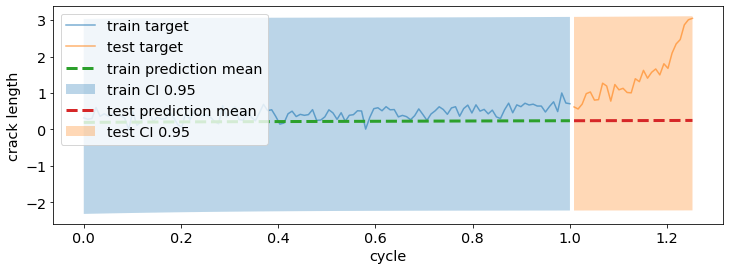

In [ ]:
%%time

model_stein = FullyConnectedStein(
    [1, 4, 4, 1],
    weight_prior=td.Normal(0, 1),
    bias_prior=td.Uniform(-10, 10),
    n_particles=10,
    likelihood_std=1,
    activation=nn.Tanh,
)

epochs = 10000
physics_coeff = 1

optim = torch.optim.AdamW(model_stein.parameters(), lr=1e-2, weight_decay=1e-6)
metric_stein = train_model_physics_magnitude_norm_gaussian_nn_stein(
    model_stein,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
    optim=optim,
)

train_predictions = model_stein(train_xtensor).detach().numpy()
test_predictions = model_stein(test_xtensor).detach().numpy()
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
    marker="",
)

# test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
# uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

In [ ]:
for param in model.parameters():
    print(param.shape, kernel_rbf(param))

torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([4, 4]) tensor([[1.0000, 0.9880, 0.0041, 0.2557],
        [0.9880, 1.0000, 0.0036, 0.2444],
        [0.0041, 0.0036, 1.0000, 0.0043],
        [0.2557, 0.2444, 0.0043, 1.0000]], grad_fn=<ExpBackward0>)
torch.Size([4, 4]) tensor([[1.0000e+00, 7.5553e-01, 7.7018e-04, 4.2971e-01],
        [7.5553e-01, 1.0000e+00, 3.7671e-05, 1.4545e-01],
        [7.7018e-04, 3.7671e-05, 1.0000e+00, 1.8948e-02],
        [4.2971e-01, 1.4545e-01, 1.8948e-02, 1.0000e+00]],
       grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([4, 1]) tensor([[1.0000, 0.3078, 0.9691, 0.0000],
        [0.3078, 1.0000, 0.2031, 0.0000],
        [0.9691, 0.2031, 1.0000, 0.0000],
      

In [ ]:
t1 = torch.randn((3, 1, 4))
t1, kernel_rbf(t1)

(tensor([[[ 1.0848,  1.3573,  0.0661,  1.3923]],
 
         [[ 1.4156,  0.8592,  0.5603, -0.6566]],
 
         [[ 0.7340,  1.1530,  0.9769, -0.7197]]]),
 tensor([[[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
          [2.9279e-01, 6.1750e-02, 6.4473e-02, 3.4231e-21],
          [2.5125e-01, 6.2601e-01, 9.0241e-05, 1.7921e-22]],
 
         [[2.9279e-01, 6.1750e-02, 6.4473e-02, 3.4231e-21],
          [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
          [5.4361e-03, 3.7949e-01, 1.4245e-01, 9.5622e-01]],
 
         [[2.5125e-01, 6.2601e-01, 9.0241e-05, 1.7921e-22],
          [5.4361e-03, 3.7949e-01, 1.4245e-01, 9.5622e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]]]))

In [ ]:
# https://github.com/shwangtangjun/SVGD-PyTorch/blob/master/bayesian_nn.py
"""
Sample code to reproduce results for the Bayesian neural network example.
https://arxiv.org/abs/1502.05336
p(y | W, X, gamma) = prod_i^N  Normal(y_i | f(x_i; W), gamma^-1)
p(W | lambda) = prod_i^N Normal(w_i | 0, lambda^-1)
p(gamma) = Gamma(gamma | a0, b0)
p(lambda) = Gamma(lambda | a0, b0)
    
The posterior distribution is as follows:
p(W, gamma, lambda) = p(y | W, X, gamma) p(W | lambda) p(gamma) p(lambda) 
To avoid negative values of gamma and lambda, we update log(gamma) and log(lambda) instead.

theta=[w1,b1,w2,b2,log(gamma),log(lambda)]
w1: n_features * hidden_dim
b1: hidden_dim
w2: hidden_dim * 1
b2: 1
log(gamma),log(lambda): 1, 1
Actually, every parameter has num_particles rows.

Currently, we can not directly use nn.Module and construct a network, because we have many networks, each parametrized 
by a particle.
"""


class BayesianNN:
    def __init__(self, num_particles):
        self.gamma_prior = Gamma(
            torch.tensor(1.0, device=device), torch.tensor(1 / 0.1, device=device)
        )
        self.lambda_prior = Gamma(
            torch.tensor(1.0, device=device), torch.tensor(1 / 0.1, device=device)
        )
        self.num_particles = num_particles

    def forward(self, inputs, theta):
        # Unpack theta
        w1 = theta[:, 0 : self.n_features * self.hidden_dim].reshape(
            -1, self.n_features, self.hidden_dim
        )
        b1 = theta[
            :,
            self.n_features * self.hidden_dim : (self.n_features + 1) * self.hidden_dim,
        ].unsqueeze(1)
        w2 = theta[
            :,
            (self.n_features + 1)
            * self.hidden_dim : (self.n_features + 2)
            * self.hidden_dim,
        ].unsqueeze(2)
        b2 = theta[:, -3].reshape(-1, 1, 1)
        # log_gamma, log_lambda = theta[-2], theta[-1]

        # num_particles times of forward
        inputs = inputs.unsqueeze(0).repeat(self.num_particles, 1, 1)
        inter = F.relu(torch.bmm(inputs, w1) + b1)
        out = torch.bmm(inter, w2) + b2
        out = out.squeeze()
        return out

    def log_prob(self, theta):
        model_gamma = torch.exp(theta[:, -2])
        model_lambda = torch.exp(theta[:, -1])
        model_w = theta[:, :-2]
        # w_prior should be decided based on current lambda (not sure)
        w_prior = Normal(0, torch.sqrt(torch.ones_like(model_lambda) / model_lambda))

        random_idx = random.sample(
            [i for i in range(self.X_train.shape[0])], self.batch_size
        )
        X_batch = self.X_train[random_idx]
        y_batch = self.y_train[random_idx]

        outputs = self.forward(X_batch, theta)  # [num_particles, batch_size]
        model_gamma_repeat = model_gamma.unsqueeze(1).repeat(1, self.batch_size)
        y_batch_repeat = y_batch.unsqueeze(0).repeat(self.num_particles, 1)
        distribution = Normal(
            outputs,
            torch.sqrt(torch.ones_like(model_gamma_repeat) / model_gamma_repeat),
        )
        log_p_data = distribution.log_prob(y_batch_repeat).sum(dim=1)

        log_p0 = (
            w_prior.log_prob(model_w.t()).sum(dim=0)
            + self.gamma_prior.log_prob(model_gamma)
            + self.lambda_prior.log_prob(model_lambda)
        )
        log_p = log_p0 + log_p_data * (
            self.X_train.shape[0] / self.batch_size
        )  # (8) in paper
        return log_p


def test(model, theta, X_test, y_test):
    prob = model.forward(X_test, theta)
    y_pred = prob.mean(
        dim=0
    )  # Average among outputs from different network parameters(particles)

    print(y_pred)
    print(y_test)
    rmse = torch.norm(y_pred - y_test) / math.sqrt(y_test.shape[0])

    print("RMSE: {}".format(rmse))

In [ ]:
def main():
    data = np.loadtxt("data/boston_housing")

    X, y = data[:, :-1], data[:, -1]
    X = torch.from_numpy(X).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # Normalization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )
    X_train_mean, X_train_std = torch.mean(X_train, dim=0), torch.std(X_train, dim=0)
    y_train_mean, y_train_std = torch.mean(y_train, dim=0), torch.std(y_train, dim=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    num_particles, batch_size, hidden_dim = 100, 200, 50

    model = BayesianNN(X_train, y_train, batch_size, num_particles, hidden_dim)

    # Random initialization (based on expectation of gamma distribution)
    theta = torch.cat(
        [
            torch.zeros(
                [num_particles, (X.shape[1] + 2) * hidden_dim + 1], device=device
            ).normal_(0, math.sqrt(10)),
            torch.log(0.1 * torch.ones([num_particles, 2], device=device)),
        ],
        dim=1,
    )

    for epoch in range(2000):
        optimizer = Adam([theta], lr=0.1)
        optimizer.zero_grad()
        theta.grad = get_gradient(model, theta)
        optimizer.step()
        if epoch % 100 == 0:
            test(model, theta, X_test, y_test)

    test(model, theta, X_test, y_test)


if __name__ == "__main__":
    main()

## harmonic oscillator test

In [ ]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * x)
    sin = torch.sin(phi + w * x)
    exp = torch.exp(-d * x)
    y = exp * 2 * A * cos
    return y

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


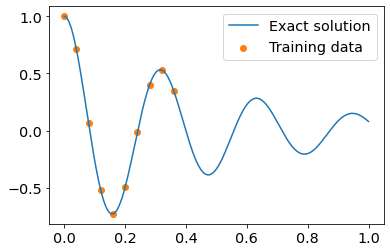

In [ ]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0, 1, 500).view(-1, 1)
y = oscillator(d, w0, x).view(-1, 1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [ ]:
def plot_result(x, y, x_data, y_data, yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(
        x,
        yh,
        color="tab:blue",
        linewidth=4,
        alpha=0.8,
        label="Neural network prediction",
    )
    plt.scatter(
        x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training data"
    )
    if xp is not None:
        plt.scatter(
            xp,
            -0 * torch.ones_like(xp),
            s=60,
            color="tab:green",
            alpha=0.4,
            label="Physics loss training locations",
        )
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    #     plt.ylim(-1.1, 1.1)
    #     plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [ ]:
def train_oscillator():

    x_physics = (
        torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
    )  # sample locations over the problem domain
    mu, k = 2 * d, w0**2

    torch.manual_seed(2022)
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    files = []
    epochs = 4000
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(x_data)
        loss1 = torch.mean((yh - y_data) ** 2)  # use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx = torch.autograd.grad(
            yhp, x_physics, torch.ones_like(yhp), create_graph=True
        )[
            0
        ]  # computes dy/dx
        dx2 = torch.autograd.grad(
            dx, x_physics, torch.ones_like(dx), create_graph=True
        )[
            0
        ]  # computes d^2y/dx^2
        physics = (
            dx2 + mu * dx + k * yhp
        )  # computes the residual of the 1D harmonic oscillator differential equation
        loss2 = (1e-4) * torch.mean(physics**2)

        # backpropagate joint loss
        loss = loss1 + loss2  # add two loss terms together
        loss.backward()
        optimizer.step()

        # plot the result as training progresses
        #         if (i+1) % 10 == 0:
        if (i + 1) % (epochs // 5) == 0:

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x, y, x_data, y_data, yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
            #             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(mu * dx + k * yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
            #             print(dx)
            #             print(dx2, '\n',  mu*dx + k*yhp)
            print(loss1, loss2)


#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")

In [ ]:
figs = []
# train_oscillator()

## linear regression

In [ ]:
linreg = sklearn.linear_model.LinearRegression()
linreg.fit(train_input.reshape(-1, 1), train_target.reshape(-1, 1))

LinearRegression()

In [ ]:
linreg_train_prediction = linreg.predict(train_input.reshape(-1, 1))
linreg_test_prediction = linreg.predict(test_input.reshape(-1, 1))

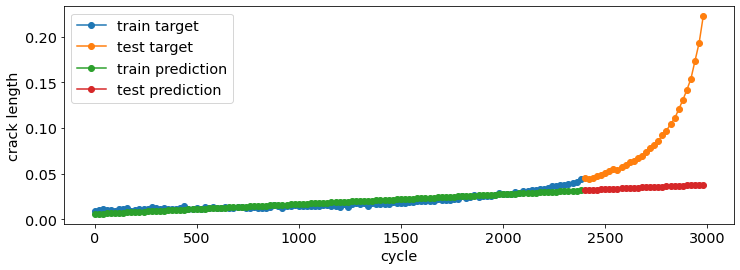

In [ ]:
fig = plot_target_prediction(
    train_input,
    train_target,
    linreg_train_prediction,
    test_input,
    test_target,
    linreg_test_prediction,
)

## tolerant differential loss

In [ ]:
def tolerant_l2_loss(prediction, target, tolerance):
    mse = tnf.mse_loss(prediction, target, reduction="none")
    loss = torch.max(torch.zeros(1).to(device), mse - tolerance**2 * target**2)
    return torch.mean(loss)


def train_model_physics_tolerant_mse(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=5,
    physics_coeff=1,
    optim=None,
    verbose=True,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)

    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()

    for epoch in range(epochs):
        optim.zero_grad()

        (
            dataloss,
            physicsloss,
            rescaled_derivative,
            physics_constraint,
            prediction_physics,
        ) = compute_data_physics_loss(
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
            physics_coeff=physics_coeff,
        )

        tolerant_physicsloss = tolerant_l2_loss(
            rescaled_derivative, physics_constraint, tolerance=0.01
        )
        loss = dataloss + physics_coeff * tolerant_physicsloss
        loss.backward()
        optim.step()
        #         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}")
            print(
                f" data loss = {(dataloss).detach().item()} ; tolerant physics loss = {(tolerant_physicsloss).detach().item()}"
            )

            #             print(f"physic loss 2 = {physicsloss2.detach().item()}")
            #             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
            #                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8, 4))
            plt.plot(
                tensor_to_array(physicsinput),
                tensor_to_array(rescaled_derivative),
                label="rescaled derivative",
                marker="o",
            )
            plt.plot(
                tensor_to_array(physicsinput),
                tensor_to_array(physics_constraint),
                label="paris",
                marker="o",
            )
            plt.legend()
            figs.append(fig)

            plt.close()
    return losses


 Epoch 1 loss = 0.036873284727334976
 data loss = 0.036873284727334976 ; tolerant physics loss = 4.719213908543907e-10

 Epoch 1001 loss = 0.018119441345334053
 data loss = 0.018119441345334053 ; tolerant physics loss = 3.648717994408912e-10

 Epoch 2001 loss = 0.018115293234586716
 data loss = 0.018115293234586716 ; tolerant physics loss = 3.947015769778517e-10

 Epoch 3001 loss = 0.018115047365427017
 data loss = 0.018115047365427017 ; tolerant physics loss = 3.9755843062039276e-10

 Epoch 4001 loss = 0.018351422622799873
 data loss = 0.018351422622799873 ; tolerant physics loss = 3.521916369653155e-10

 Epoch 5001 loss = 0.018137488514184952
 data loss = 0.018137488514184952 ; tolerant physics loss = 3.692227634743972e-10

 Epoch 6001 loss = 0.01821591518819332
 data loss = 0.01821591518819332 ; tolerant physics loss = 3.2910502101302086e-10

 Epoch 7001 loss = 0.018022069707512856
 data loss = 0.018022069707512856 ; tolerant physics loss = 3.1955540991113196e-10

 Epoch 8001 loss 

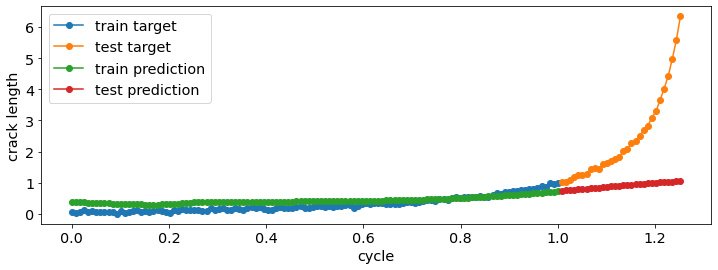

In [ ]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs = []
epochs = 10000
physics_coeff = 1

losses = train_model_physics_tolerant_mse(
    model,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions),
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(
    train_xscaled,
    train_yscaled,
    train_predictions,
    test_xscaled,
    test_yscaled,
    test_predictions,
)

print(f"{test_loss = }")

## Inverse dirichlet loss weight

https://iopscience.iop.org/article/10.1088/2632-2153/ac3712/pdf

In [ ]:
def gradient_variance(loss, model):
    allgrad = torch.tensor([]).to(device)
    for module in model.modules():
        if not isinstance(module, nn.Linear):
            continue
        weightgrad = torch.autograd.grad(loss, module.weight, retain_graph=True)[0]
        biasgrad = torch.autograd.grad(loss, module.bias, retain_graph=True)[0]
        #         print(f"{allgrad.shape = } {weightgrad.shape = } {biasgrad.shape = }")
        allgrad = torch.cat((allgrad, weightgrad.view(-1), biasgrad))
    #     print(f"{allgrad.shape = }")

    return torch.std(allgrad)


def dirichlet_weight(
    dataloss, physicsloss, model, old_dataweight, old_physicsweight, moving_oldcoeff
):
    data_gradvar = gradient_variance(dataloss, model)
    physics_gradvar = gradient_variance(physicsloss, model)
    #     print(f"{data_gradvar = } {physics_gradvar = }")

    # max_gradvar = torch.max(data_gradvar.detach(), physics_gradvar.detach())
    max_gradvar = torch.max(data_gradvar, physics_gradvar)
    dataweight = max_gradvar / data_gradvar
    physicsweight = max_gradvar / physics_gradvar
    #     print(f"{dataweight = } {physicsweight = }")
    #     weightedloss =  dataweight * dataloss +  physicsweight * physicsloss

    new_dataweight = old_dataweight * moving_oldcoeff + dataweight * (
        1 - moving_oldcoeff
    )
    new_physicsweight = old_physicsweight * moving_oldcoeff + physicsweight * (
        1 - moving_oldcoeff
    )

    return new_dataweight, new_physicsweight


def train_model_physics_dirichlet(
    model,
    traininput,
    trainlabel,
    physicsinput,
    xscaler,
    yscaler,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=5,
    physics_coeff=1,
    optim=None,
    verbose=True,
):

    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
    #         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    dataweight = 1
    physicsweight = 1
    moving_oldcoeff = 0.5

    for epoch in range(epochs):
        optim.zero_grad()

        (
            dataloss,
            physicsloss,
            rescaled_derivative,
            physics_constraint,
            prediction_physics,
        ) = compute_data_physics_loss(
            paris_C,
            paris_m,
            paris_dsigma,
            model,
            traininput,
            trainlabel,
            physicsinput,
            xscaler,
            yscaler,
            physics_coeff=physics_coeff,
        )

        dataweight, physicsweight = dirichlet_weight(
            dataloss, physicsloss, model, dataweight, physicsweight, moving_oldcoeff
        )
        loss = dataweight * dataloss + physics_coeff * physicsweight * physicsloss
        loss.backward()
        optim.step()
        #         scheduler.step(loss)
        losses["dataloss"].append((dataweight * dataloss).detach().item())
        losses["physicsloss"].append(
            (physics_coeff * physicsweight * physicsloss).detach().item()
        )

        if verbose and (epochs < 10 or epoch % (epochs // 10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}")
            #             print(f"weighted data loss = {(dataweight * dataloss).detach().item()} ; weighted physics loss = {(physicsweight * physicsloss).detach().item()}")
            print(
                f"weighted data loss = {losses['dataloss'][-1]} ; weighted physics loss = {losses['physicsloss'][-1]}"
            )

            print(f"{dataweight = } {physicsweight = }")

            #             print(f"physic loss 2 = {physicsloss2.detach().item()}")
            #             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
            #                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8, 4))
            plt.plot(
                tensor_to_array(physicsinput),
                tensor_to_array(rescaled_derivative),
                label="rescaled derivative",
                marker="o",
            )
            plt.plot(
                tensor_to_array(physicsinput),
                tensor_to_array(physics_constraint),
                label="paris",
                marker="o",
            )
            plt.legend()
            figs.append(fig)

            plt.close()
    return losses

In [ ]:
# for module in model.modules():
#     if isinstance(module, nn.Linear):
#         print(module.weight.grad)


 Epoch 1 loss = 0.5484089851379395
weighted data loss = 0.5241439938545227 ; weighted physics loss = 0.02426496520638466
dataweight = tensor(1.) physicsweight = tensor(1.3643e+11)

 Epoch 1001 loss = 0.09558746218681335
weighted data loss = 0.08872537314891815 ; weighted physics loss = 0.006862089037895203
dataweight = tensor(1.) physicsweight = tensor(1.5072e+10)

 Epoch 2001 loss = 0.057990193367004395
weighted data loss = 0.04773721471428871 ; weighted physics loss = 0.010252978652715683
dataweight = tensor(1.) physicsweight = tensor(1.8687e+09)

 Epoch 3001 loss = 0.04231680929660797
weighted data loss = 0.03216211870312691 ; weighted physics loss = 0.010154691524803638
dataweight = tensor(1.) physicsweight = tensor(6.4757e+08)

 Epoch 4001 loss = 0.05381068214774132
weighted data loss = 0.04619936645030975 ; weighted physics loss = 0.007611316163092852
dataweight = tensor(1.) physicsweight = tensor(2.7215e+09)

 Epoch 5001 loss = 0.05163545161485672
weighted data loss = 0.0444194

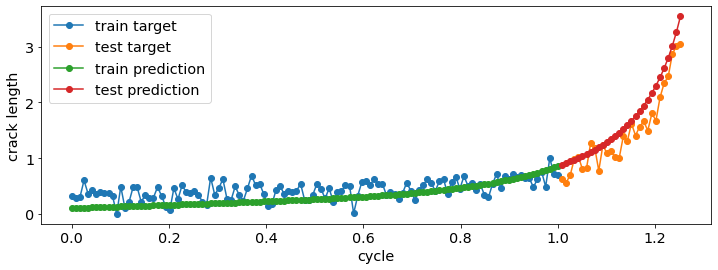

In [ ]:
%%time

model = FullyConnected([1, 4, 4, 1]).to(device)
figs = []
epochs = 10000
physics_coeff = 1

losses = train_model_physics_dirichlet(
    model,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions),
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(
    train_xtensor,
    train_ytensor,
    train_predictions,
    test_xtensor,
    test_ytensor,
    test_predictions,
)

print(f"{test_loss = }")

In [ ]:
figs[-1]

In [ ]:
fig = plot_twinx(
    np.arange(epochs),
    losses["dataloss"],
    "dataloss",
    losses["physicsloss"],
    "physicsloss",
)

In [ ]:
model = FullyConnectedExp([1, 4, 4, 1]).to(device)
figs = []
epochs = 100
physics_coeff = 1

losses = train_model_physics_dirichlet(
    model,
    train_xtensor,
    train_ytensor,
    physics_xtensor,
    train_xscaler_torch,
    train_yscaler_torch,
    paris_C,
    paris_m,
    paris_dsigma,
    epochs=epochs,
    physics_coeff=physics_coeff,
)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions),
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(
    train_xscaled,
    train_yscaled,
    train_predictions,
    test_xscaled,
    test_yscaled,
    test_predictions,
)

print(f"{test_loss = }")

In [ ]:
figs[-1]

In [ ]:
fig = plot_twinx(
    np.arange(epochs),
    losses["dataloss"],
    "dataloss",
    losses["physicsloss"],
    "physicsloss",
)